In [1]:
import pickle
import time
from IPython.display import clear_output
import sys
import os
import copy

import pandas as pd
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
import mpl_scatter_density
from tqdm import tqdm
from astropy.table import Table
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import DeepEnsemble
import metrics

In [123]:
data_dir = 'data/q_photo_z_train'
models_dir = 'trained_models'
with open(f'{data_dir}/feature_lists/features_sdssdr16+wise_deacls8tr_QSO+GALAXY_20201212141009.pkl', 'rb') as f:
    features_18 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_sdssdr16+all_deacls8tr_QSO+GALAXY_20201212143658.pkl', 'rb') as f:
    features_20 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_psdr2+all_deacls8tr_QSO+GALAXY_20201212142333.pkl', 'rb') as f:
    features_21 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_deacls8tr_QSO+GALAXY_20201212135641.pkl', 'rb') as f:
    features_22 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl', 'rb') as f:
    features_35 = pickle.load(f)

features_dict = {
    '18': features_18,
    '20': features_20,
    '21': features_21,
    '22': features_22,
    '35': features_35,
}

np.random.seed(2)
torch.manual_seed(2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# train 20

In [4]:
train_20_01 = pd.read_csv(f'{data_dir}/train_20_01.csv')
train_20_02 = pd.read_csv(f'{data_dir}/train_20_02.csv')

In [5]:
train_20_01.shape, train_20_02.shape

((288298, 92), (292158, 92))

In [6]:
train_20_01

RA        DEC         Z  decals8tr_Lw1  decals8tr_Lw1-Lw2  \
0       170.455790  19.878579 -0.009112      19.606560          -0.592985   
1        18.832807  25.355562 -0.002058      20.385595          -0.869850   
2       340.711120  27.224917 -0.000798      25.333775           5.583276   
3       184.390621  12.388094 -0.000515      19.394200          -0.214132   
4       321.698292  -7.647149 -0.000503      21.393800           0.345580   
...            ...        ...       ...            ...                ...   
288293    5.131124 -36.894948  6.834000      19.553581          -0.145996   
288294   41.732917 -52.330528  6.900000      20.298117          -0.100112   
288295  129.945333  39.003194  6.905000      19.109840           0.112651   
288296  357.461364   6.252772  6.949000      18.987589           0.589668   
288297  190.684389  45.911862  6.968027      18.811224          -0.673457   

        decals8tr_Lw2  decals8tr_g  decals8tr_g-Lw1  decals8tr_g-Lw2  \
0           20.199544    19.441993        -0.164566        -0.757551   
1           21.255445    19.100432        -1.285163        -2.155013   
2           19.750499    23.207197        -2.126578         3.456698   
3           19.608331    20.193367         0.799168         0.585036   
4           21.048220    20.429209        -0.964591        -0.619011   
...               ...          ...              ...              ...   
288293      19.699577    26.872133         7.318552         7.172555   
288294      20.398229    26.798456         6.500339         6.400227   
288295      18.997189    25.515129         6.405289         6.517940   
288296      18.397922    21.990789         3.003200         3.592867   
288297      19.484681    22.557081         3.745857         3.072400   

        decals8tr_g-r  ...  sdssdr16_z_cmodel-decals8tr_z  sdssdr16_z_psf  \
0            0.688502  ...                      -0.037778       18.425744   
1            0.302125  ...                      -0.026118       18.721188   
2            0.953378  ...                      -1.056814       21.029142   
3           -0.103131  ...                      -6.233982       19.040828   
4            0.434528  ...                      -0.086464       19.911721   
...               ...  ...                            ...             ...   
288293       1.077387  ...                            NaN             NaN   
288294       0.368550  ...                            NaN             NaN   
288295      -0.259710  ...                            NaN             NaN   
288296       0.985898  ...                      -0.187273       20.220181   
288297       1.379864  ...                       0.371519       20.657546   

        sdssdr16_z_psf-cmodel   max21_z  conf21_z   max22_z  conf22_z  \
0                    0.026430  2.498000  0.204978  0.100268  0.117886   
1                    0.018640  1.459070  0.220922  1.552094  0.202644   
2                    0.649879  1.815000  0.275649  0.457317  0.299660   
3                    4.697799  0.059143  0.150713  0.016712  0.167079   
4                    0.140220  0.250512  0.083852  0.265134  0.106204   
...                       ...       ...       ...       ...       ...   
288293                    NaN       NaN       NaN  6.390070  0.383488   
288294                    NaN       NaN       NaN  6.123234  0.618998   
288295                    NaN  2.243832  0.142105  6.377000  0.431664   
288296               0.107895  2.095132  0.363373  1.550000  0.523302   
288297               0.868814  0.799996  0.439501  0.606367  0.225533   

         max35_z  conf35_z  fold  
0       3.230971  0.244179     1  
1       2.388000  0.213741     1  
2       1.489938  0.138860     1  
3       0.037960  0.279932     1  
4       0.147753  0.086424     1  
...          ...       ...   ...  
288293       NaN       NaN     1  
288294       NaN       NaN     1  
288295       NaN       NaN     1  
288296  2.055263  0.320846     1  
288297  0.790324  0.840807     1  

[28

In [7]:
train_20_02

RA        DEC         Z  decals8tr_Lw1  decals8tr_Lw1-Lw2  \
0        24.196261 -10.109838 -0.011447      19.960258          -0.137297   
1       184.240161   0.634044 -0.007947      19.350478          -0.636057   
2       122.091429  30.926546 -0.005114      21.271493           0.929939   
3       147.244138  27.849499 -0.000810      22.807423           1.597843   
4       257.835533  37.789509 -0.000705      21.445772          -0.684682   
...            ...        ...       ...            ...                ...   
292153  129.407666  49.483444  6.710000      19.948461           0.635476   
292154  166.089958  21.574667  6.740000      19.919157           0.006301   
292155  127.383208  41.294556  6.768000      20.104586           0.048389   
292156   62.869291  -9.130500  6.810000      19.508455           0.136622   
292157  332.752500 -63.348833  6.880000      21.076493           0.266804   

        decals8tr_Lw2  decals8tr_g  decals8tr_g-Lw1  decals8tr_g-Lw2  \
0           20.097554    19.708072        -0.252185        -0.389482   
1           19.986535    18.620714        -0.729763        -1.365821   
2           20.341554    21.105814        -0.165679         0.764260   
3           21.209581    21.861513        -0.945910         0.651933   
4           22.130455    21.154559        -0.291213        -0.975895   
...               ...          ...              ...              ...   
292153      19.312985    25.340844         5.392383         6.027859   
292154      19.912856    26.031365         6.112208         6.118510   
292155      20.056197    25.727275         5.622690         5.671078   
292156      19.371833    26.801125         7.292670         7.429292   
292157      20.809688    26.352327         5.275834         5.542639   

        decals8tr_g-r  ...  sdssdr16_z_cmodel-decals8tr_z  sdssdr16_z_psf  \
0            0.525462  ...                      -0.039920       18.921812   
1            0.257748  ...                      -0.058617       18.306308   
2            0.861072  ...                       0.031030       19.888133   
3            0.067944  ...                      -2.930384       22.067579   
4            0.691582  ...                       0.120755       20.312108   
...               ...  ...                            ...             ...   
292153       0.377814  ...                            NaN             NaN   
292154      -0.615328  ...                            NaN             NaN   
292155      -0.619201  ...                            NaN             NaN   
292156      -0.936220  ...                            NaN             NaN   
292157       0.203734  ...                            NaN             NaN   

        sdssdr16_z_psf-cmodel   max21_z  conf21_z   max22_z  conf22_z  \
0                    0.009676  0.050839  0.118156  0.087129  0.142408   
1                    0.049146  0.151387  0.117320  0.055640  0.200341   
2                    0.057526  2.556220  0.221226  0.268127  0.130353   
3                    3.063558  3.018800  0.710388  3.071691  0.646613   
4                    0.046655  0.250221  0.194149  0.229429  0.137957   
...                       ...       ...       ...       ...       ...   
292153                    NaN  0.906495  0.093949  6.200000  0.447981   
292154                    NaN  2.236000  0.176007  6.654000  0.642608   
292155                    NaN  1.823777  0.166808  6.663754  0.511770   
292156                    NaN  6.502475  0.348167  6.020939  0.486409   
292157                    NaN       NaN       NaN  6.314515  0.617858   

         max35_z  conf35_z  fold  
0       0.076411  0.167270     2  
1       0.112295  0.151217     2  
2       0.289233  0.102691     2  
3       3.146000  0.719703     2  
4       1.807045  0.143804     2  
...          ...       ...   ...  
292153       NaN       NaN     2  
292154       NaN       NaN     2  
292155       NaN       NaN     2  
292156       NaN       NaN     2  
292157       NaN       NaN     2  

[29

Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-0.25187, 0.07801, 0.72832, -0.77447, -0.89157]
AVG train loss: -0.22232
Train S_nmad: 0.02976	Train out_rate: 0.06423	Train S_nmad_z5: 0.01322	Train out_rate_z5: 0.03391	
----------------------------------------
Test losses: [-0.20077, 0.02573, 0.57245, 14.76225, -0.21994]
AVG test loss: 2.98794
Test S_nmad: 0.03585	Test out_rate: 0.07116	Test S_nmad_z5: 0.03491	Test out_rate_z5: 0.10145	
----------------------------------------
Time: 3.493


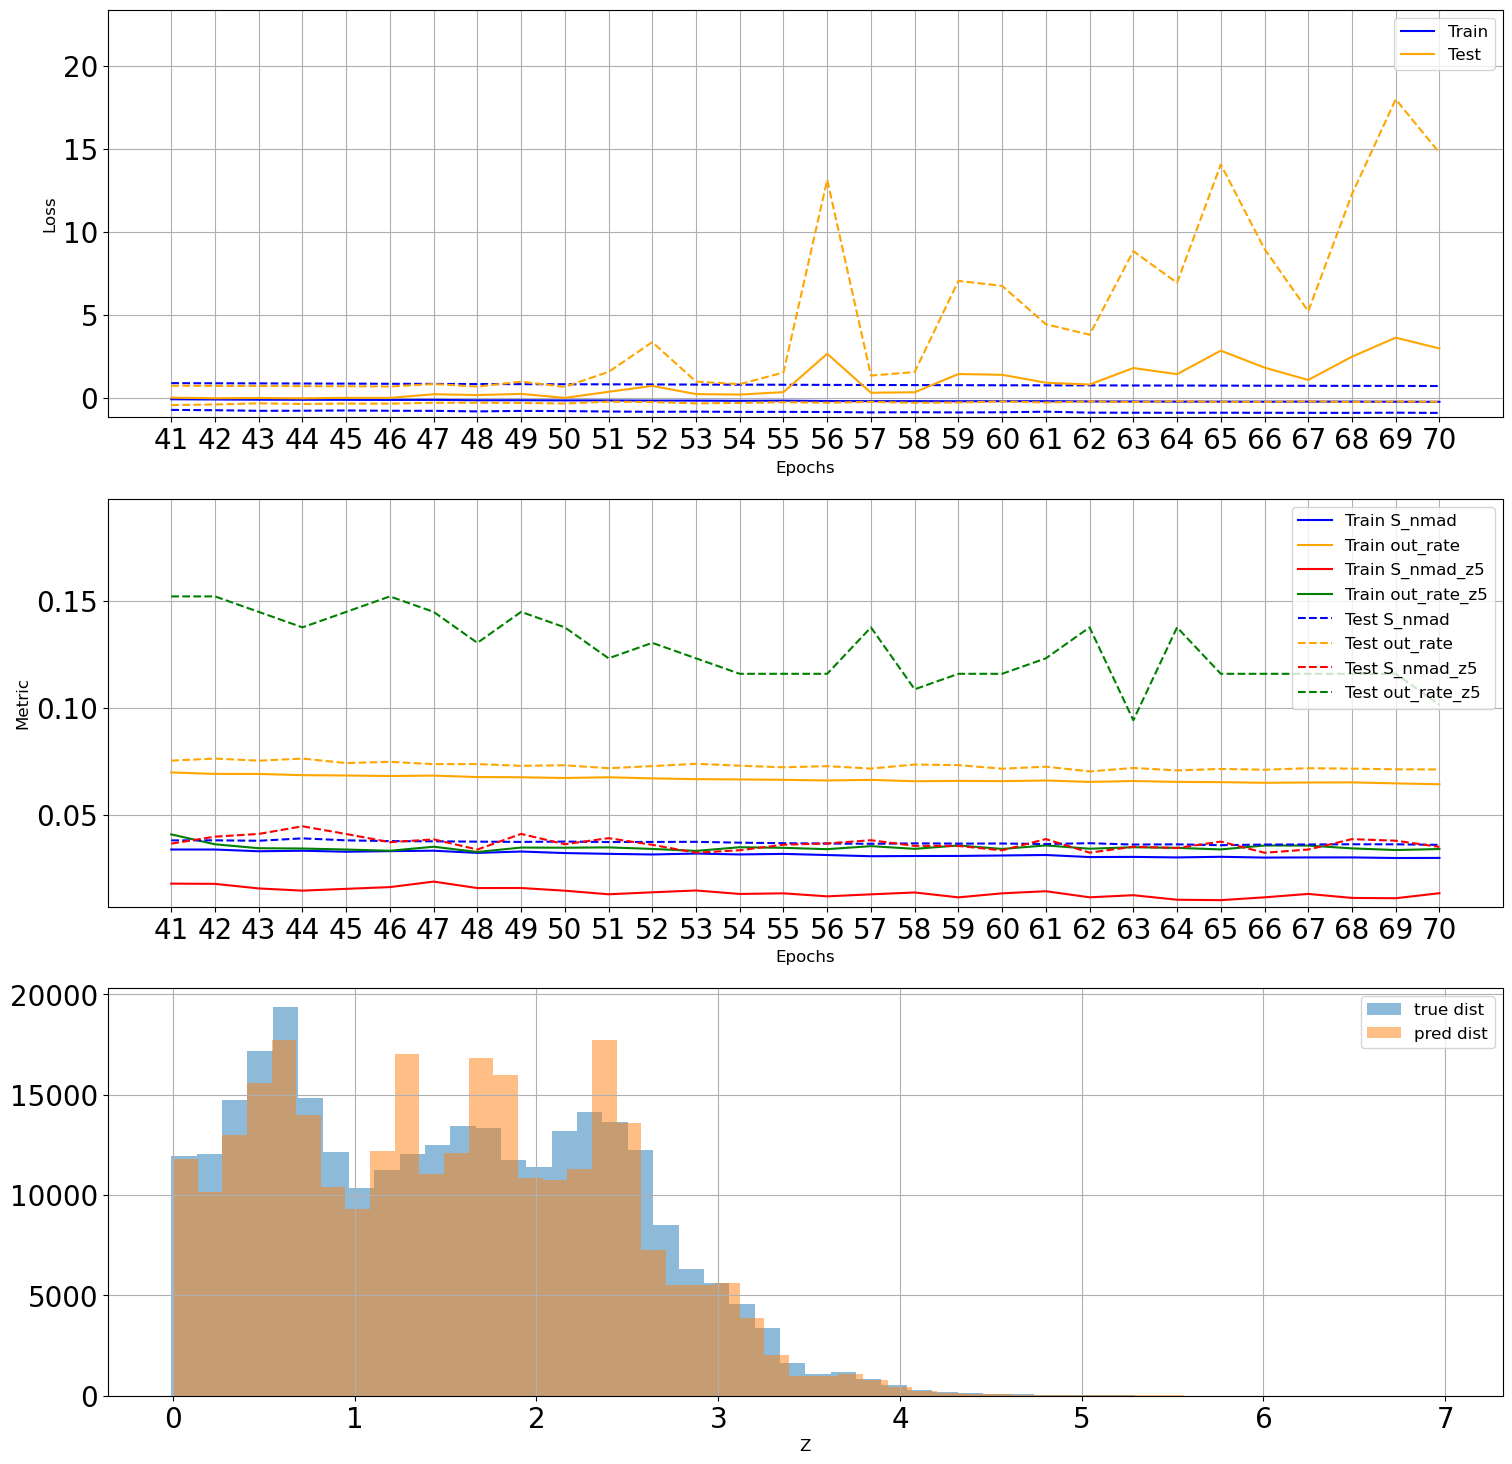

(286201, 5)
(286201, 5)
(289975, 5)
(289975, 5)


RA        DEC         Z  fold  sdssdr16_u_psf  sdssdr16_g_psf  \
0        24.196261 -10.109838 -0.011447     2       20.842147       19.756733   
1       170.455790  19.878579 -0.009112     1       21.240596       19.528449   
2       184.240161   0.634044 -0.007947     2       19.550209       18.671965   
3       122.091429  30.926546 -0.005114     2       22.468104       21.251481   
4        18.832807  25.355562 -0.002058     1       19.957126       19.084415   
...            ...        ...       ...   ...             ...             ...   
576171   36.507807   3.049838  6.541200     2       24.312627       24.815416   
576172   16.619326  18.475668  6.578712     1       21.326311       21.173190   
576173  174.891806  49.894562  6.795398     1       24.230143       24.980301   
576174  357.461364   6.252772  6.949000     1       22.151268       21.827504   
576175  190.684389  45.911862  6.968027     1       23.725394       23.692442   

        sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  \
0            19.267105       19.053641       18.921812          20.784370   
1            18.831749       18.584223       18.425744          21.187583   
2            18.413090       18.318118       18.306308          19.526882   
3            20.282878       20.080934       19.888133          19.921550   
4            18.829452       18.737669       18.721188          19.828226   
...                ...             ...             ...                ...   
576171       24.377670       23.445890       20.656290          24.437056   
576172       20.940946       20.570890       19.888027          20.803366   
576173       23.235294       22.281788       20.942590          20.276665   
576174       21.142139       20.551375       20.220181          21.855427   
576175       22.682931       21.596302       20.657546          22.140958   

        ...  sample_279  sample_280  sample_281  sample_282  sample_283  \
0       ...    0.249938    2.542357    1.430183    2.970297    2.048598   
1       ...    2.177551    1.231564    4.192979    1.685769    0.929399   
2       ...    1.312031    0.209410    1.483546    2.468737    2.897198   
3       ...    0.702772    1.964386    2.671674    3.036468    1.826480   
4       ...    2.759276   -0.868488    3.201064    0.889684   -1.779146   
...     ...         ...         ...         ...         ...         ...   
576171  ...    4.035238   -4.779972   -3.859349   53.005130   -1.438088   
576172  ...    1.340626    1.767903    2.397251    1.844678    1.894373   
576173  ...    0.532693    1.060076    0.662903    0.815399    0.824299   
576174  ...    1.934177    2.716178    1.464338    1.233985    3.491139   
576175  ...    1.296500    0.481930    0.417695    0.587699    1.115463   

        sample_284  sample_285  sample_286  sample_287     zConf  
0         2.169729    1.819967    1.109614    2.335221  0.104167  
1         0.788035   -1.722464    3.119001    2.317048  0.097222  
2         0.537695   -0.033293    3.287216    0.926085  0.065972  
3         2.958289    0.762325    2.522504    0.426121  0.079861  
4         1.287984   -1.916426    1.438265   -0.028388  0.062500  
...            ...         ...         ...         ...       ...  
576171    4.218656    5.272581    6.488322    4.054586  0.229167  
576172    2.109802    1.883703    1.498699    2.162920  0.465278  
576173    0.621162    0.368403    1.043096   -0.439741  0.145833  
576174    0.903801    2.085417    2.654006    2.090515  0.208333  
576175    0.288755    0.681932    1.133987    1.099896  0.201389  

[576176 rows x 408 columns]

In [13]:
features_no = '35'
features = features_dict[features_no]
n_gauss = 1

#===========

n_dup = 500
z_thr = 4.5
n_epoch = 70
n_models = 5

#===========

name = f'train20_{features_no}_g{n_gauss}_m{n_models}'

def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6)))# + 0.00002*np.exp((-6)*(z-1)**2) + 0.00002*np.exp((-3)*(z-2)**2)

rf_features = ['max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z',]

t_01 = train_20_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_01 = t_01[features].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_20_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_02 = t_02[features].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

X_full = np.concatenate([X_01, X_02], axis=0)
y_full = np.concatenate([y_01, y_02], axis=0)

#===========

np.random.seed(1)
torch.manual_seed(1)

ens_full = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_full.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_full.save_pickle(f'{name}_model_full.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_01 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_01.save_pickle(f'{name}_model_01.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_02 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_02.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_02.save_pickle(f'{name}_model_02.pkl');

#===========

ens_01 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_01.pkl')
ens_02 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_02.pkl')
import warnings
warnings.filterwarnings('ignore')

result_01 = ens_02.predict(X_01)
result_01 = pd.concat([t_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_01], axis=1)
result_02 = ens_01.predict(X_02)
result_02 = pd.concat([t_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_02], axis=1)
result = pd.concat([result_01, result_02])
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

0.04440796520112587
0.09237108105856544
0.04824211040325707
0.13383958234456572
0.052060701804315095
0.11510791366906475


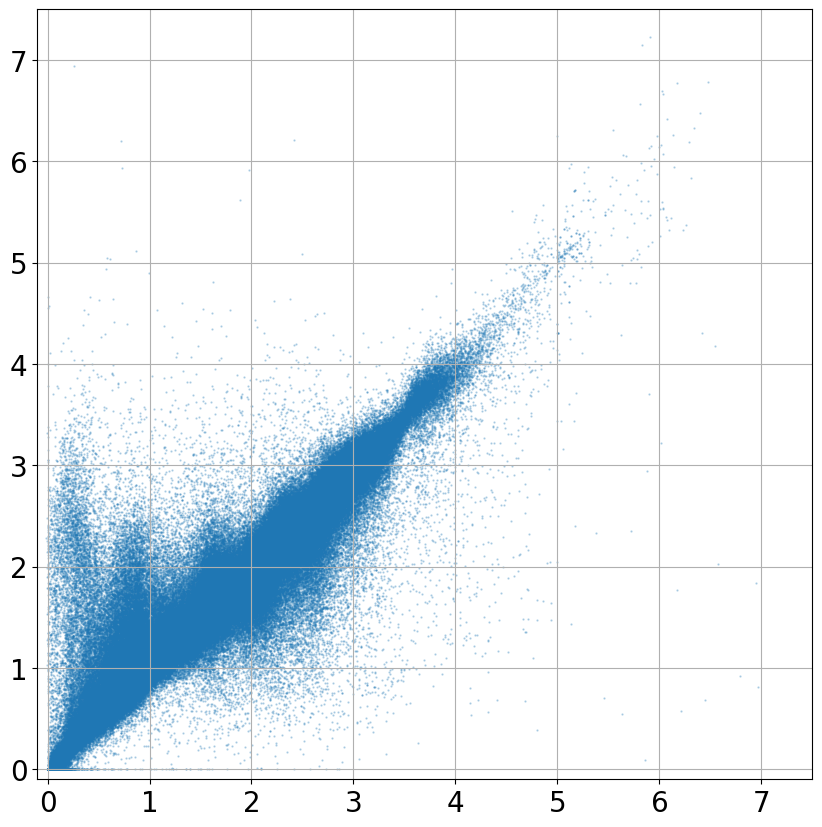

In [14]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result['Z'], result['mode'], s=0.4, alpha=0.3);

Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-1.16134, -1.2164, -1.24503, -1.20233, -1.22494]
AVG train loss: -1.21001
Train S_nmad: 0.02087	Train out_rate: 0.02899	Train S_nmad_z5: 0.00892	Train out_rate_z5: 0.0	
----------------------------------------
Test losses: [-1.03338, -1.06392, -1.04374, -1.02401, -1.05978]
AVG test loss: -1.04497
Test S_nmad: 0.02643	Test out_rate: 0.03682	Test S_nmad_z5: 0.02103	Test out_rate_z5: 0.10145	
----------------------------------------
Time: 4.851


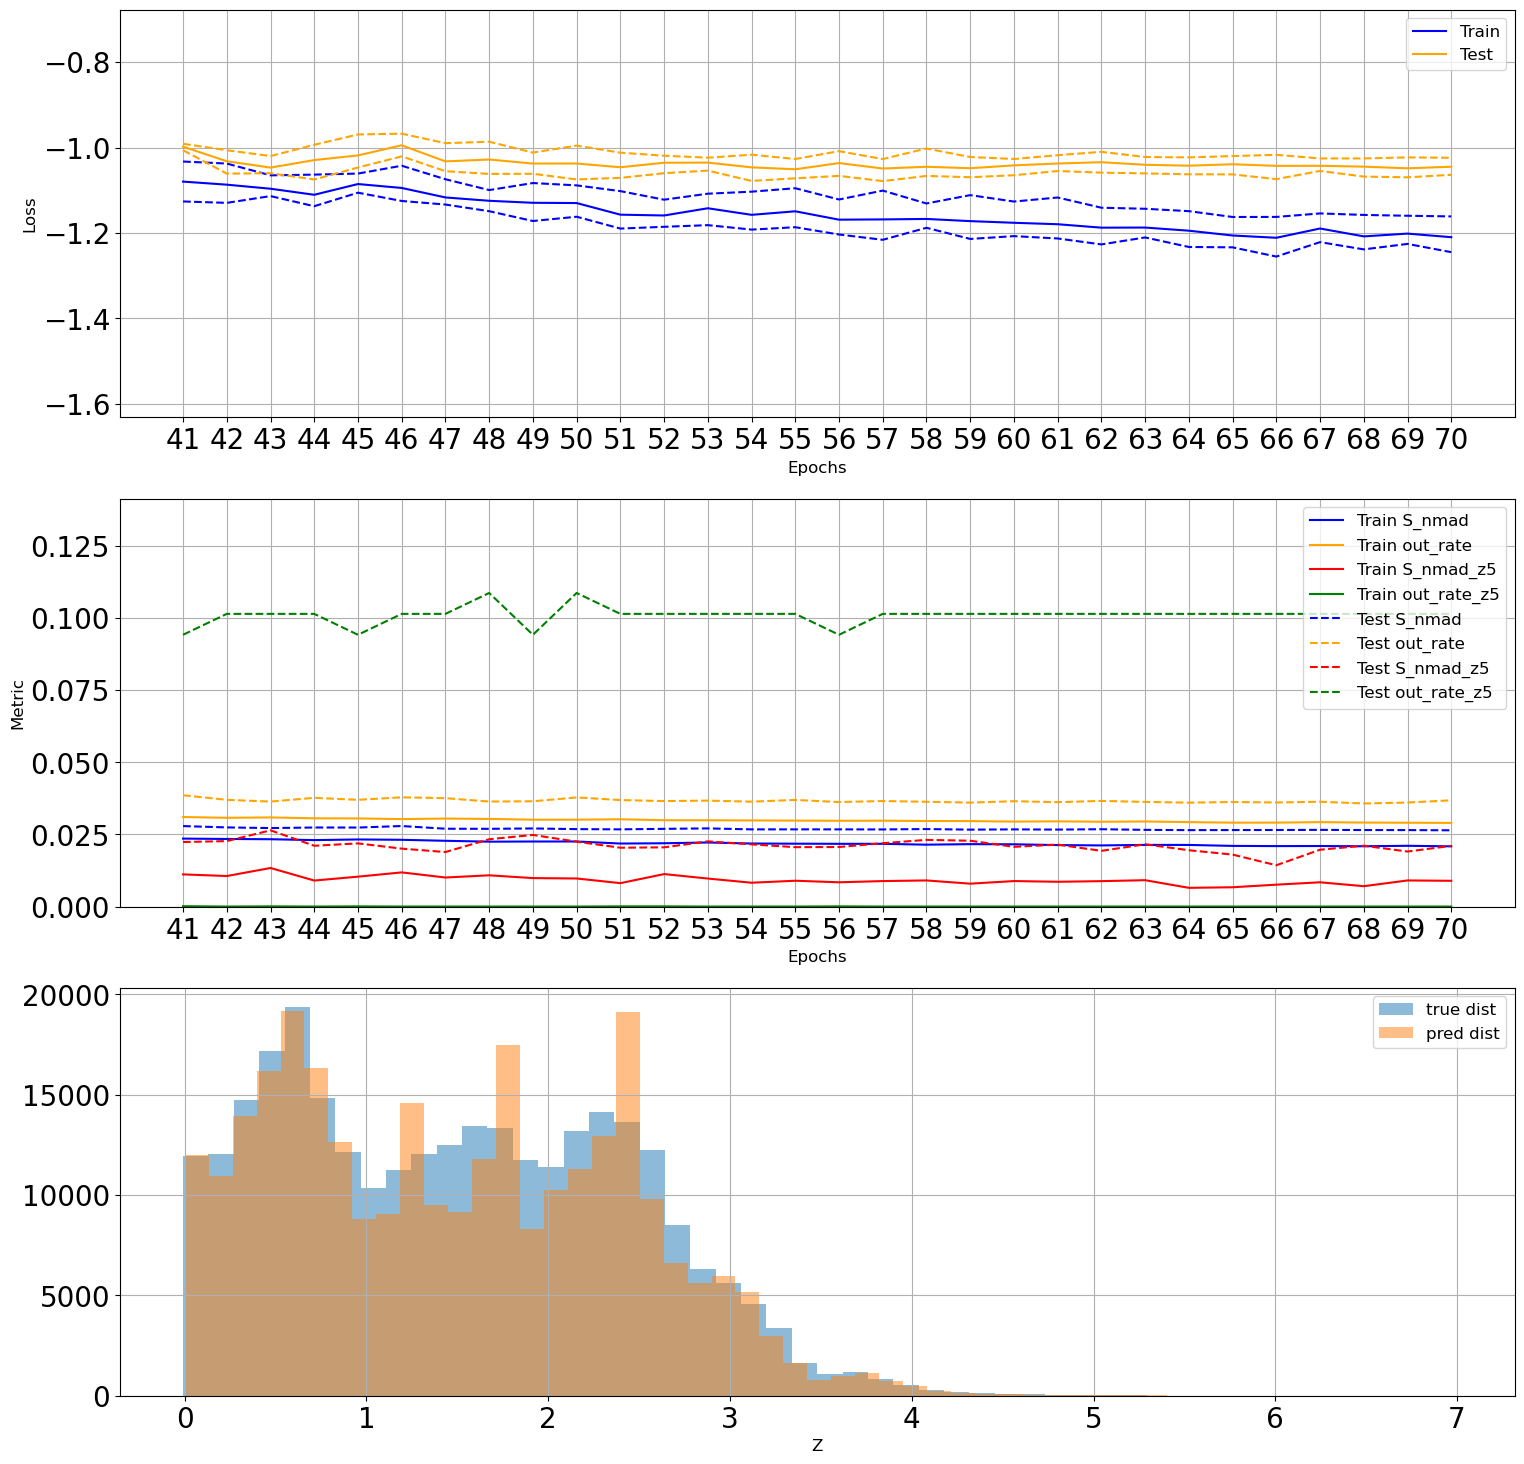

(286201, 5)
(286201, 5)
(289975, 5)
(289975, 5)


RA        DEC         Z  fold  sdssdr16_u_psf  sdssdr16_g_psf  \
0        24.196261 -10.109838 -0.011447     2       20.842147       19.756733   
1       170.455790  19.878579 -0.009112     1       21.240596       19.528449   
2       184.240161   0.634044 -0.007947     2       19.550209       18.671965   
3       122.091429  30.926546 -0.005114     2       22.468104       21.251481   
4        18.832807  25.355562 -0.002058     1       19.957126       19.084415   
...            ...        ...       ...   ...             ...             ...   
576171   36.507807   3.049838  6.541200     2       24.312627       24.815416   
576172   16.619326  18.475668  6.578712     1       21.326311       21.173190   
576173  174.891806  49.894562  6.795398     1       24.230143       24.980301   
576174  357.461364   6.252772  6.949000     1       22.151268       21.827504   
576175  190.684389  45.911862  6.968027     1       23.725394       23.692442   

        sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  \
0            19.267105       19.053641       18.921812          20.784370   
1            18.831749       18.584223       18.425744          21.187583   
2            18.413090       18.318118       18.306308          19.526882   
3            20.282878       20.080934       19.888133          19.921550   
4            18.829452       18.737669       18.721188          19.828226   
...                ...             ...             ...                ...   
576171       24.377670       23.445890       20.656290          24.437056   
576172       20.940946       20.570890       19.888027          20.803366   
576173       23.235294       22.281788       20.942590          20.276665   
576174       21.142139       20.551375       20.220181          21.855427   
576175       22.682931       21.596302       20.657546          22.140958   

        ...  sample_279  sample_280  sample_281  sample_282  sample_283  \
0       ...    1.430577    2.708640    0.665056    0.227030    1.857656   
1       ...    2.046843    2.113758    0.920588    2.313479    2.947925   
2       ...    2.915971    1.599807    0.025007    0.114615    2.690588   
3       ...    2.694464    3.305928    3.361197    3.458352    3.044110   
4       ...    2.339431   -0.206234    2.274009    0.453755    1.997476   
...     ...         ...         ...         ...         ...         ...   
576171  ...    5.148534    6.496082    4.979801    6.841374    6.516051   
576172  ...    1.981457    1.988655    2.135649    2.006587    2.039876   
576173  ...    0.707261    0.828951    0.712796    0.719277    0.708982   
576174  ...    1.642158    1.713059    1.502248    1.418972    1.786392   
576175  ...    0.832783    0.757609    0.812382    0.821762    0.800334   

        sample_284  sample_285  sample_286  sample_287     zConf  
0         2.467237    1.064330    0.584100    0.189800  0.072917  
1         1.918731    0.562065    0.333088    2.137400  0.138889  
2         1.991671    1.310101    3.269117    2.455280  0.194444  
3         3.862961    2.698957    2.831772    3.314524  0.541667  
4         1.197667    1.987132    2.304118    2.129390  0.166667  
...            ...         ...         ...         ...       ...  
576171    5.925167    5.319542    5.873673    5.710116  0.482639  
576172    2.118937    2.037261    1.942916    2.080918  0.975694  
576173    0.737683    0.699655    0.826042    0.689004  0.791667  
576174    1.463873    1.546744    1.715917    1.728619  0.697917  
576175    0.704060    0.755715    0.868382    0.808128  0.958333  

[576176 rows x 437 columns]

In [15]:
features_no = '35'
features = features_dict[features_no]
n_gauss = 3

#===========

n_dup = 500
z_thr = 4.5
n_epoch = 70
n_models = 5

#===========

name = f'train20_{features_no}_g{n_gauss}_m{n_models}'

def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6)))# + 0.00002*np.exp((-6)*(z-1)**2) + 0.00002*np.exp((-3)*(z-2)**2)

rf_features = ['max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z',]

t_01 = train_20_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_01 = t_01[features].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_20_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_02 = t_02[features].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

X_full = np.concatenate([X_01, X_02], axis=0)
y_full = np.concatenate([y_01, y_02], axis=0)

#===========

np.random.seed(1)
torch.manual_seed(1)

ens_full = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_full.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_full.save_pickle(f'{name}_model_full.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_01 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_01.save_pickle(f'{name}_model_01.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_02 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_02.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_02.save_pickle(f'{name}_model_02.pkl');

#===========

ens_01 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_01.pkl')
ens_02 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_02.pkl')
import warnings
warnings.filterwarnings('ignore')

result_01 = ens_02.predict(X_01)
result_01 = pd.concat([t_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_01], axis=1)
result_02 = ens_01.predict(X_02)
result_02 = pd.concat([t_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_02], axis=1)
result = pd.concat([result_01, result_02])
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

0.026498578732958047
0.036693649162755824
0.023136909765419666
0.05268153773137162
0.021676446589302695
0.08273381294964029


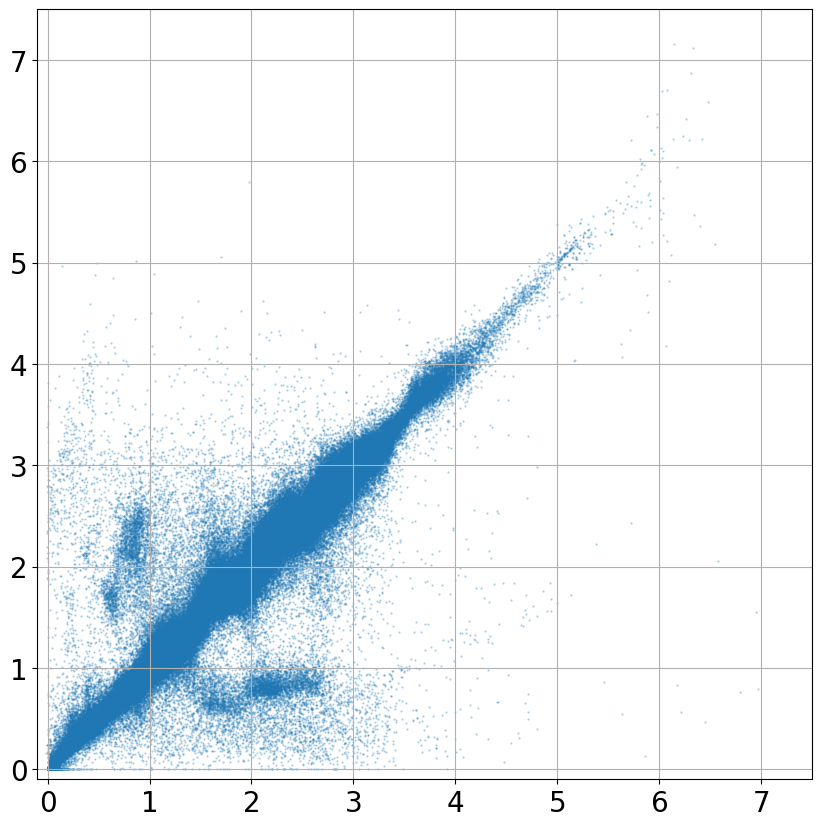

In [16]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result['Z'], result['mode'], s=0.4, alpha=0.3);

Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-1.25896, -1.26658, -1.2617, -1.25795, -1.22616]
AVG train loss: -1.25427
Train S_nmad: 0.02004	Train out_rate: 0.02817	Train S_nmad_z5: 0.00742	Train out_rate_z5: 0.00018	
----------------------------------------
Test losses: [-1.0611, -1.04801, -1.06342, -1.06725, -1.07413]
AVG test loss: -1.06278
Test S_nmad: 0.02594	Test out_rate: 0.03603	Test S_nmad_z5: 0.0185	Test out_rate_z5: 0.08696	
----------------------------------------
Time: 7.796


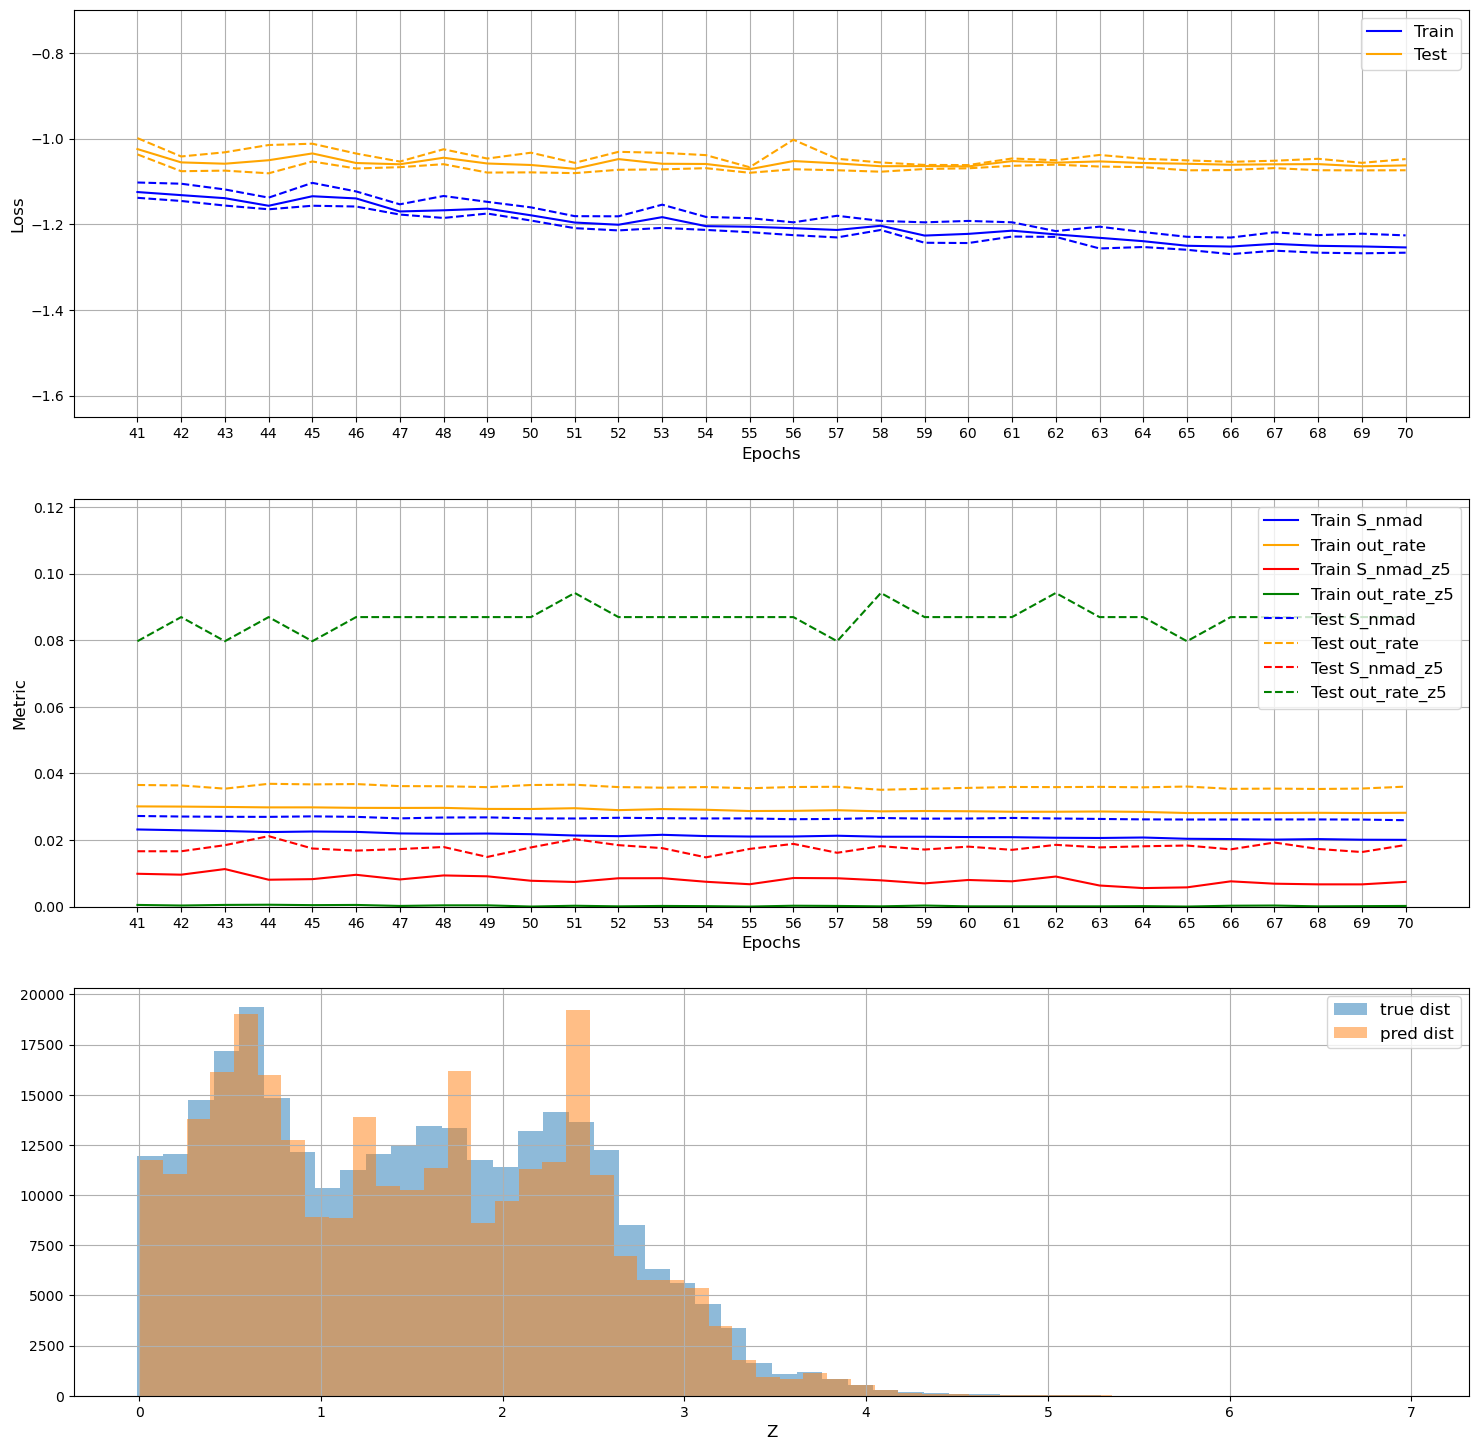

(286201, 5)
(286201, 5)
(289975, 5)
(289975, 5)


RA        DEC         Z  fold  sdssdr16_u_psf  sdssdr16_g_psf  \
0        24.196261 -10.109838 -0.011447     2       20.842147       19.756733   
1       170.455790  19.878579 -0.009112     1       21.240596       19.528449   
2       184.240161   0.634044 -0.007947     2       19.550209       18.671965   
3       122.091429  30.926546 -0.005114     2       22.468104       21.251481   
4        18.832807  25.355562 -0.002058     1       19.957126       19.084415   
...            ...        ...       ...   ...             ...             ...   
576171   36.507807   3.049838  6.541200     2       24.312627       24.815416   
576172   16.619326  18.475668  6.578712     1       21.326311       21.173190   
576173  174.891806  49.894562  6.795398     1       24.230143       24.980301   
576174  357.461364   6.252772  6.949000     1       22.151268       21.827504   
576175  190.684389  45.911862  6.968027     1       23.725394       23.692442   

        sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  \
0            19.267105       19.053641       18.921812          20.784370   
1            18.831749       18.584223       18.425744          21.187583   
2            18.413090       18.318118       18.306308          19.526882   
3            20.282878       20.080934       19.888133          19.921550   
4            18.829452       18.737669       18.721188          19.828226   
...                ...             ...             ...                ...   
576171       24.377670       23.445890       20.656290          24.437056   
576172       20.940946       20.570890       19.888027          20.803366   
576173       23.235294       22.281788       20.942590          20.276665   
576174       21.142139       20.551375       20.220181          21.855427   
576175       22.682931       21.596302       20.657546          22.140958   

        ...  sample_279  sample_280  sample_281  sample_282  sample_283  \
0       ...    1.461405    3.668910    0.015997    2.978041    0.025786   
1       ...    2.022964    2.880911    3.425345    3.021823    1.902180   
2       ...    0.196027    1.901141    0.827450    1.122102    0.114831   
3       ...    3.065017    1.232181    2.934979    3.245102    2.927220   
4       ...    1.698431    0.262802    2.073996    1.050063    1.981039   
...     ...         ...         ...         ...         ...         ...   
576171  ...    6.273175    5.519974    6.172780    6.016911    5.548713   
576172  ...    1.907011    1.966760    2.075982    1.980084    1.977163   
576173  ...    0.737743    0.899390    0.743921    0.751157    0.687507   
576174  ...    1.693139    1.653815    1.359185    1.075869    1.872644   
576175  ...    0.862960    0.768525    0.750911    0.763788    0.814086   

        sample_284  sample_285  sample_286  sample_287     zConf  
0         3.298098    0.845936    2.243153    0.070714  0.211806  
1         2.743311    0.700718    1.854377    2.783898  0.184028  
2         2.097408    1.756040    3.022454    2.329609  0.222222  
3         3.450558    3.069589    3.454762    2.951475  0.607639  
4         1.437109    1.968896    2.780497    2.135898  0.239583  
...            ...         ...         ...         ...       ...  
576171    4.922027    5.867753    6.292321    4.684452  0.559028  
576172    2.580447    1.975249    1.906179    2.035314  0.965278  
576173    0.733368    0.705460    0.897843    0.831465  0.576389  
576174    1.533348    1.596604    1.805006    1.763640  0.579861  
576175    0.726749    0.700369    0.841556    0.755503  0.892361  

[576176 rows x 467 columns]

In [8]:
features_no = '35'
features = features_dict[features_no]
n_gauss = 5

#===========

n_dup = 500
z_thr = 4.5
n_epoch = 70
n_models = 5

#===========

name = f'train20_{features_no}_g{n_gauss}_m{n_models}'

def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6)))# + 0.00002*np.exp((-6)*(z-1)**2) + 0.00002*np.exp((-3)*(z-2)**2)

rf_features = ['max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z',]

t_01 = train_20_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_01 = t_01[features].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_20_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_02 = t_02[features].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

X_full = np.concatenate([X_01, X_02], axis=0)
y_full = np.concatenate([y_01, y_02], axis=0)

#===========

np.random.seed(1)
torch.manual_seed(1)

ens_full = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_full.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_full.save_pickle(f'{name}_model_full.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_01 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_01.save_pickle(f'{name}_model_01.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_02 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_02.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_02.save_pickle(f'{name}_model_02.pkl');

#===========

ens_01 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_01.pkl')
ens_02 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_02.pkl')
import warnings
warnings.filterwarnings('ignore')

result_01 = ens_02.predict(X_01)
result_01 = pd.concat([t_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_01], axis=1)
result_02 = ens_01.predict(X_02)
result_02 = pd.concat([t_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_02], axis=1)
result = pd.concat([result_01, result_02])
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

0.026110561017283405
0.03587271944683569
0.022842714551468957
0.05173232083531087
0.018943985382555147
0.06115107913669065


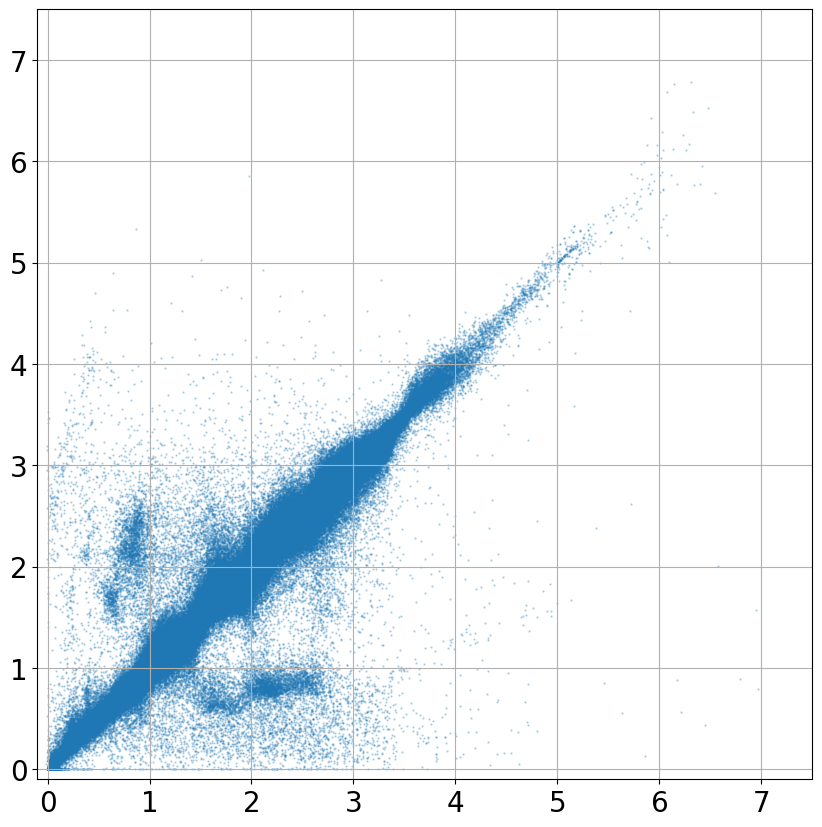

In [9]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result['Z'], result['mode'], s=0.4, alpha=0.3);

Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-1.27466, -1.25221, -1.24239, -1.24825, -1.23242]
AVG train loss: -1.24999
Train S_nmad: 0.02003	Train out_rate: 0.02834	Train S_nmad_z5: 0.00667	Train out_rate_z5: 0.0	
----------------------------------------
Test losses: [-1.05514, -1.06252, -1.07927, -1.04858, -1.07391]
AVG test loss: -1.06388
Test S_nmad: 0.02588	Test out_rate: 0.03614	Test S_nmad_z5: 0.02031	Test out_rate_z5: 0.10145	
----------------------------------------
Time: 12.537


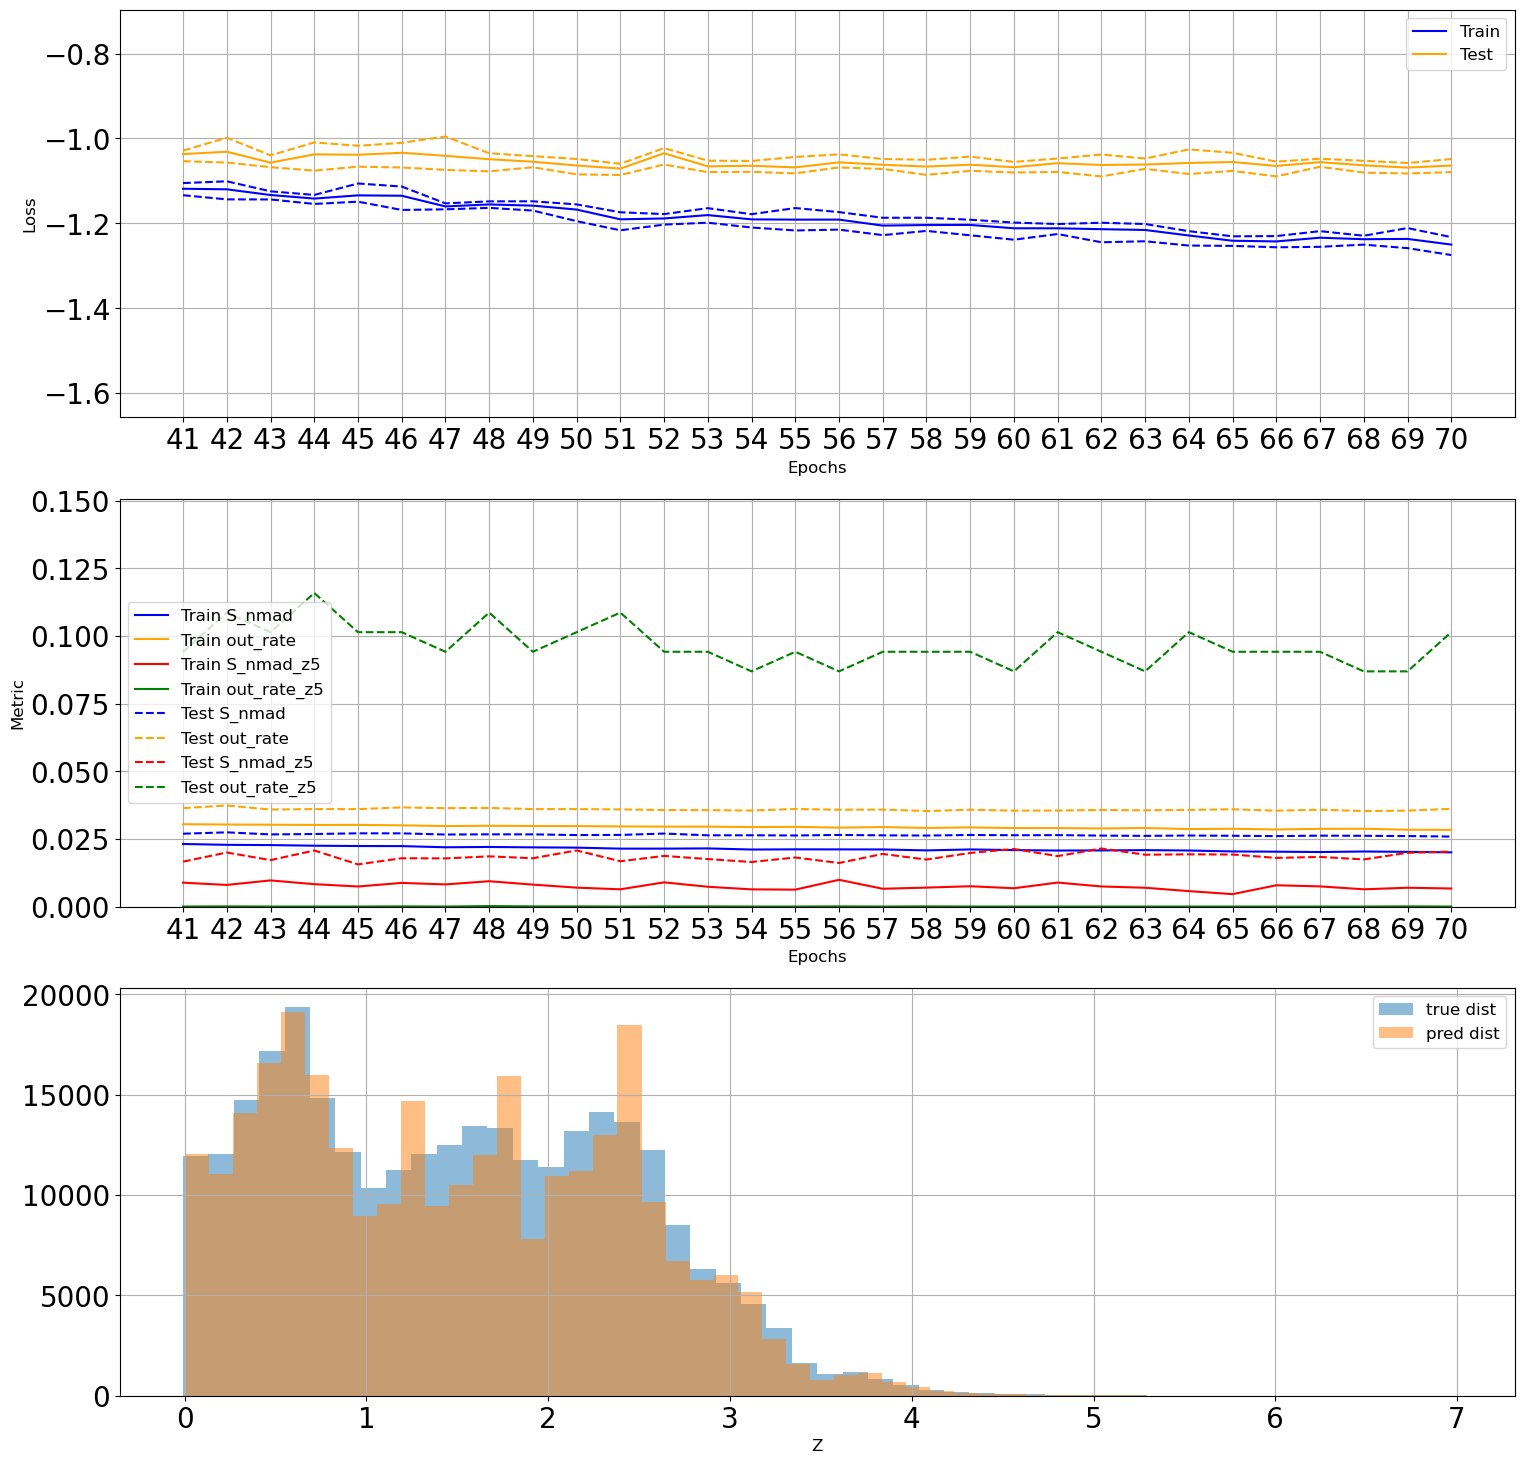

(286201, 5)
(286201, 5)
(289975, 5)
(289975, 5)


RA        DEC         Z  fold  sdssdr16_u_psf  sdssdr16_g_psf  \
0        24.196261 -10.109838 -0.011447     2       20.842147       19.756733   
1       170.455790  19.878579 -0.009112     1       21.240596       19.528449   
2       184.240161   0.634044 -0.007947     2       19.550209       18.671965   
3       122.091429  30.926546 -0.005114     2       22.468104       21.251481   
4        18.832807  25.355562 -0.002058     1       19.957126       19.084415   
...            ...        ...       ...   ...             ...             ...   
576171   36.507807   3.049838  6.541200     2       24.312627       24.815416   
576172   16.619326  18.475668  6.578712     1       21.326311       21.173190   
576173  174.891806  49.894562  6.795398     1       24.230143       24.980301   
576174  357.461364   6.252772  6.949000     1       22.151268       21.827504   
576175  190.684389  45.911862  6.968027     1       23.725394       23.692442   

        sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  \
0            19.267105       19.053641       18.921812          20.784370   
1            18.831749       18.584223       18.425744          21.187583   
2            18.413090       18.318118       18.306308          19.526882   
3            20.282878       20.080934       19.888133          19.921550   
4            18.829452       18.737669       18.721188          19.828226   
...                ...             ...             ...                ...   
576171       24.377670       23.445890       20.656290          24.437056   
576172       20.940946       20.570890       19.888027          20.803366   
576173       23.235294       22.281788       20.942590          20.276665   
576174       21.142139       20.551375       20.220181          21.855427   
576175       22.682931       21.596302       20.657546          22.140958   

        ...  sample_279  sample_280  sample_281  sample_282  sample_283  \
0       ...    2.143721    3.293201   -0.077284    3.054499    2.344204   
1       ...    0.908392    2.135932    0.464404    2.369649    2.137885   
2       ...    2.709592    0.149576    0.780569    1.573481    0.274393   
3       ...    3.481019    3.307975    3.455347    3.327992    0.151072   
4       ...    2.471614    0.287110    2.497947    1.284207    1.664433   
...     ...         ...         ...         ...         ...         ...   
576171  ...    5.313594    5.616664    5.151895    6.190598    5.649856   
576172  ...    1.984937    1.928583    2.052077    1.948699    2.040991   
576173  ...    0.783252    0.714175    0.765711    0.682663    1.771651   
576174  ...    1.778532    1.561253    1.390910    3.077094    4.661854   
576175  ...    0.872965    0.729483    0.685818    0.695044    0.788228   

        sample_284  sample_285  sample_286  sample_287     zConf  
0         0.175092    1.703448    2.387270    1.302745  0.114583  
1         1.907709    0.621007    2.755539    1.822914  0.038194  
2         0.170680    1.897261    2.699413    0.195647  0.156250  
3         3.698040    3.482464    3.459812    3.060384  0.496528  
4         1.854786    1.640017    2.344522    1.975813  0.118056  
...            ...         ...         ...         ...       ...  
576171    6.176948    6.107475    6.454980    6.026163  0.704861  
576172    2.070876    2.039038    1.968569    2.008237  0.975694  
576173    0.708496    0.676850    0.710039    0.727491  0.680556  
576174    1.520964    1.879783    1.652404    1.588423  0.451389  
576175    0.716661    0.804949    0.828506    0.858610  0.826389  

[576176 rows x 497 columns]

In [11]:
features_no = '35'
features = features_dict[features_no]
n_gauss = 7

#===========

n_dup = 500
z_thr = 4.5
n_epoch = 70
n_models = 5

#===========

name = f'train20_{features_no}_g{n_gauss}_m{n_models}'

def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6)))# + 0.00002*np.exp((-6)*(z-1)**2) + 0.00002*np.exp((-3)*(z-2)**2)

rf_features = ['max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z',]

t_01 = train_20_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_01 = t_01[features].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_20_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_02 = t_02[features].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

X_full = np.concatenate([X_01, X_02], axis=0)
y_full = np.concatenate([y_01, y_02], axis=0)

#===========

np.random.seed(1)
torch.manual_seed(1)

ens_full = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_full.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_full.save_pickle(f'{name}_model_full.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_01 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_01.save_pickle(f'{name}_model_01.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_02 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_02.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_02.save_pickle(f'{name}_model_02.pkl');

#===========

ens_01 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_01.pkl')
ens_02 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_02.pkl')
import warnings
warnings.filterwarnings('ignore')

result_01 = ens_02.predict(X_01)
result_01 = pd.concat([t_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_01], axis=1)
result_02 = ens_01.predict(X_02)
result_02 = pd.concat([t_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_02], axis=1)
result = pd.concat([result_01, result_02])
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

0.025967817256205422
0.035846685734914334
0.022536165685293576
0.05173232083531087
0.02033880634326974
0.07194244604316546


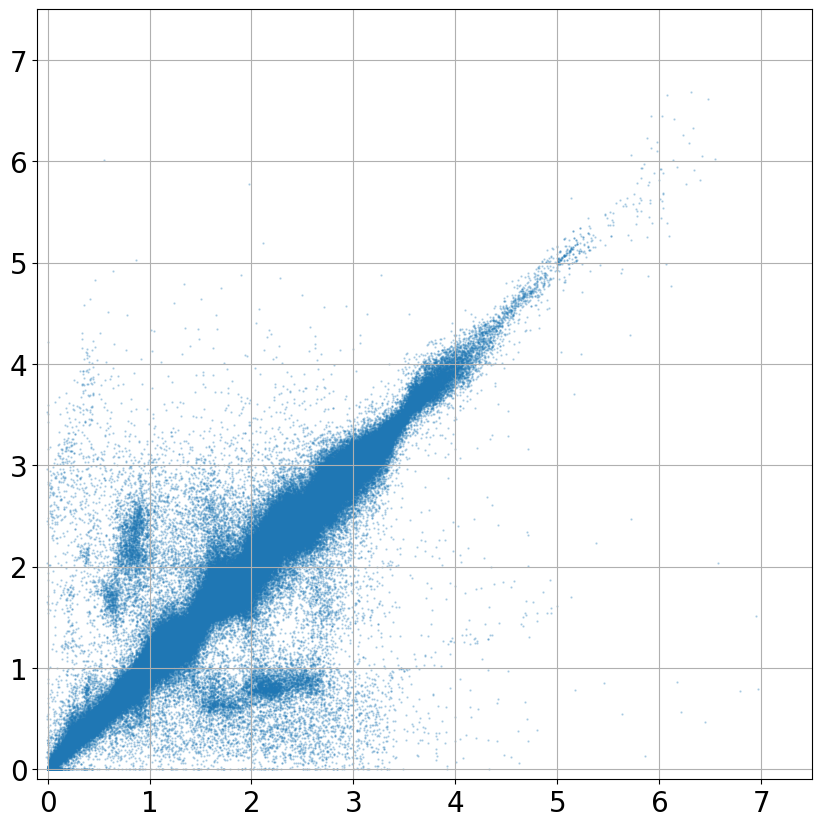

In [12]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result['Z'], result['mode'], s=0.4, alpha=0.3);

In [18]:
result_g1 = pd.read_csv('train20_35_g1_m5_result_cv2.gz_csv', compression='gzip')
result_g3 = pd.read_csv('train20_35_g3_m5_result_cv2.gz_csv', compression='gzip')
result_g5 = pd.read_csv('train20_35_g5_m5_result_cv2.gz_csv', compression='gzip')
result_g7 = pd.read_csv('train20_35_g7_m5_result_cv2.gz_csv', compression='gzip')

In [20]:
def step_metric(true, pred, z, step, metric):
    p = np.arange(z.min(), z.max()+0.001, step)
    values = []
    for i in range(len(p)):
        m = (z >= p[i]) & (z <= (p[i] + step))
        try:
            values.append(metric(true[m], pred[m]))
        except Exception:
            values.append(-1)
    return values, p

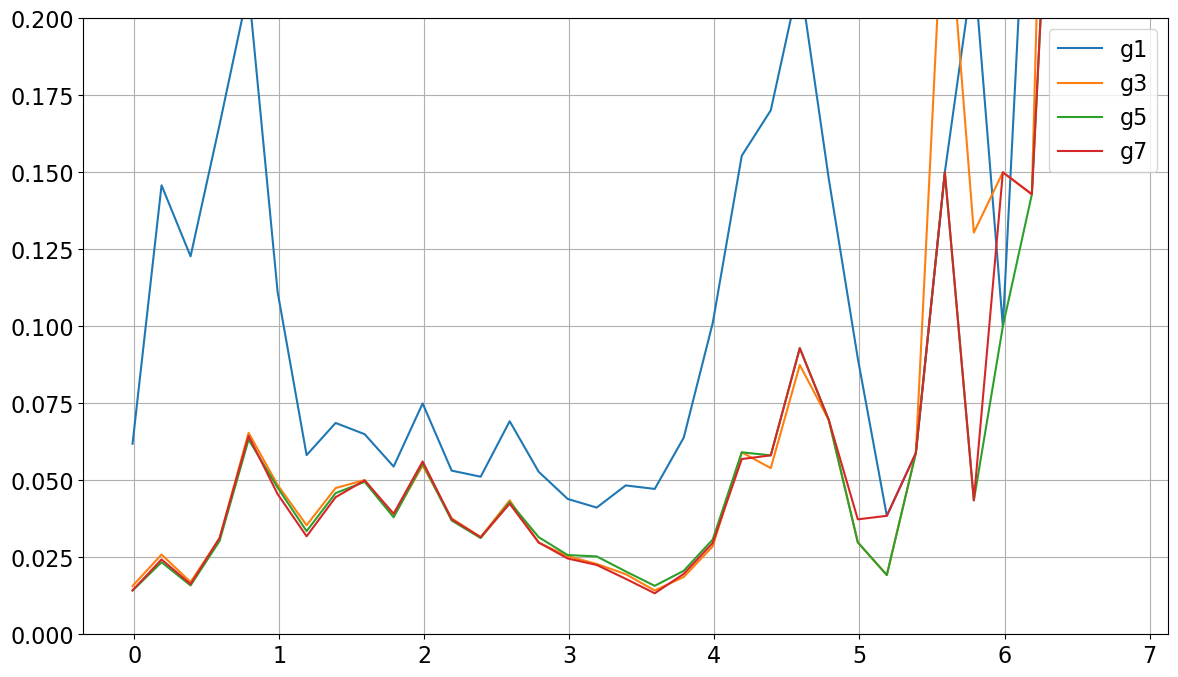

In [22]:
out_g1, p_g1 = step_metric(result_g1['Z'], result_g1['mode'], result_g1['Z'], 0.2, metrics.out_rate)
out_g3, p_g3 = step_metric(result_g3['Z'], result_g3['mode'], result_g3['Z'], 0.2, metrics.out_rate)
out_g5, p_g5 = step_metric(result_g5['Z'], result_g5['mode'], result_g5['Z'], 0.2, metrics.out_rate)
out_g7, p_g7 = step_metric(result_g7['Z'], result_g7['mode'], result_g7['Z'], 0.2, metrics.out_rate)

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 8))
plt.ylim(0, 0.2)
plt.grid()

plt.plot(p_g1, out_g1, label='g1')
plt.plot(p_g3, out_g3, label='g3')
plt.plot(p_g5, out_g5, label='g5')
plt.plot(p_g7, out_g7, label='g7')
plt.legend()

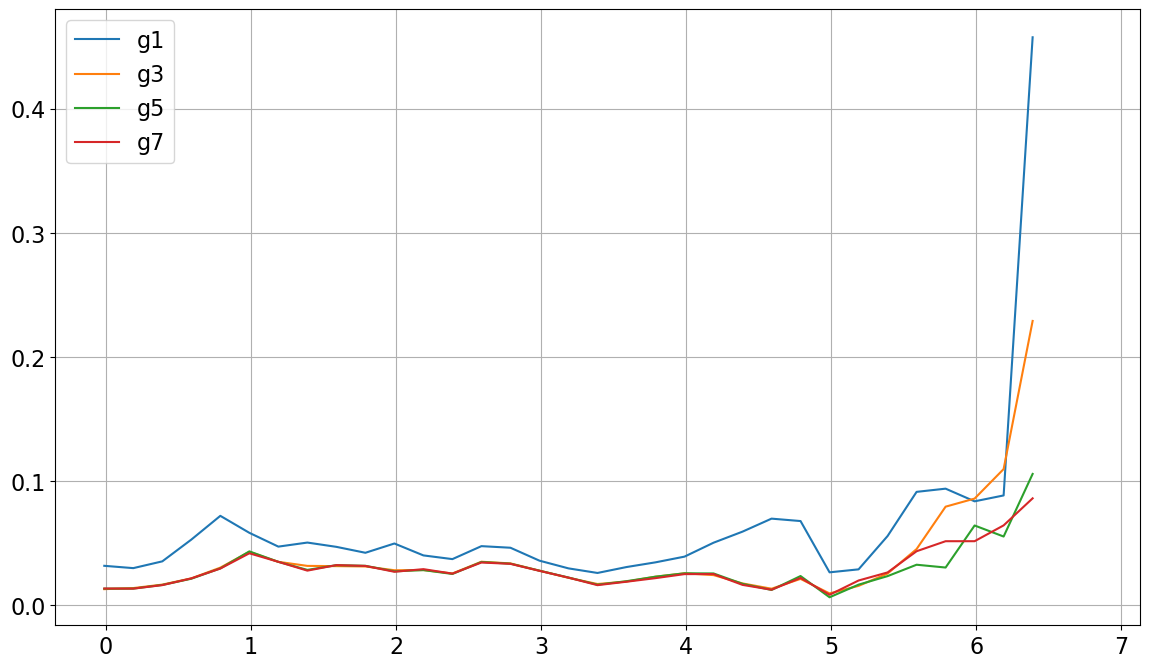

In [24]:
sigma_g1, p_g1 = step_metric(result_g1['Z'], result_g1['mode'], result_g1['Z'], 0.2, metrics.sigma_nmad)
sigma_g3, p_g3 = step_metric(result_g3['Z'], result_g3['mode'], result_g3['Z'], 0.2, metrics.sigma_nmad)
sigma_g5, p_g5 = step_metric(result_g5['Z'], result_g5['mode'], result_g5['Z'], 0.2, metrics.sigma_nmad)
sigma_g7, p_g7 = step_metric(result_g7['Z'], result_g7['mode'], result_g7['Z'], 0.2, metrics.sigma_nmad)

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 8))
plt.grid()

plt.plot(p_g1, sigma_g1, label='g1')
plt.plot(p_g3, sigma_g3, label='g3')
plt.plot(p_g5, sigma_g5, label='g5')
plt.plot(p_g7, sigma_g7, label='g7')
plt.legend()

Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-0.92079, -0.9376, -0.92709, -0.92843, -0.90964]
AVG train loss: -0.92471
Train S_nmad: 0.02858	Train out_rate: 0.04758	Train S_nmad_z5: 0.00603	Train out_rate_z5: 0.0	
----------------------------------------
Test losses: [-0.76156, -0.76687, -0.76255, -0.77798, -0.77309]
AVG test loss: -0.76841
Test S_nmad: 0.03608	Test out_rate: 0.05851	Test S_nmad_z5: 0.02749	Test out_rate_z5: 0.10145	
----------------------------------------
Time: 7.509


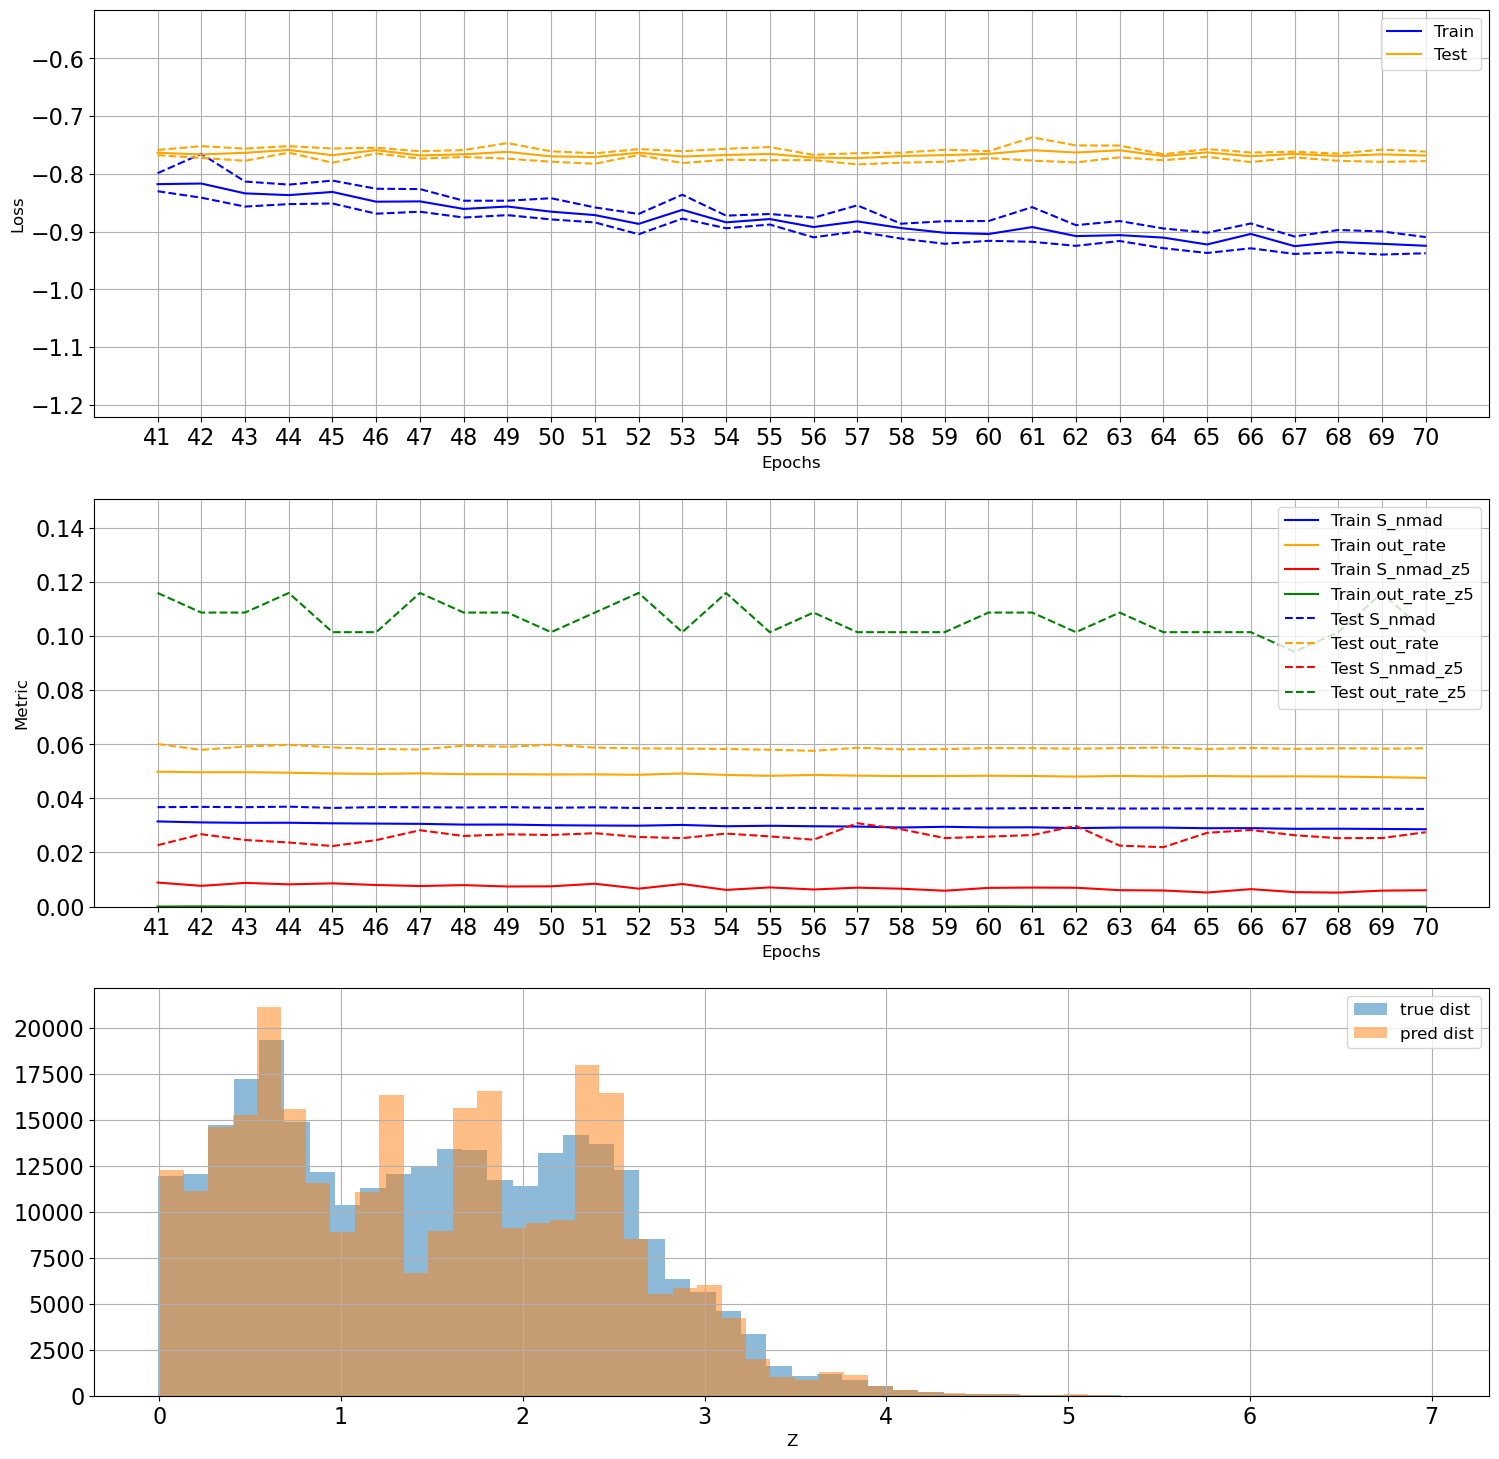

(286201, 5)
(286201, 5)
(289975, 5)
(289975, 5)


RA        DEC         Z  fold  sdssdr16_u_psf  sdssdr16_g_psf  \
0        24.196261 -10.109838 -0.011447     2       20.842147       19.756733   
1       170.455790  19.878579 -0.009112     1       21.240596       19.528449   
2       184.240161   0.634044 -0.007947     2       19.550209       18.671965   
3       122.091429  30.926546 -0.005114     2       22.468104       21.251481   
4        18.832807  25.355562 -0.002058     1       19.957126       19.084415   
...            ...        ...       ...   ...             ...             ...   
576171   36.507807   3.049838  6.541200     2       24.312627       24.815416   
576172   16.619326  18.475668  6.578712     1       21.326311       21.173190   
576173  174.891806  49.894562  6.795398     1       24.230143       24.980301   
576174  357.461364   6.252772  6.949000     1       22.151268       21.827504   
576175  190.684389  45.911862  6.968027     1       23.725394       23.692442   

        sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  \
0            19.267105       19.053641       18.921812          20.784370   
1            18.831749       18.584223       18.425744          21.187583   
2            18.413090       18.318118       18.306308          19.526882   
3            20.282878       20.080934       19.888133          19.921550   
4            18.829452       18.737669       18.721188          19.828226   
...                ...             ...             ...                ...   
576171       24.377670       23.445890       20.656290          24.437056   
576172       20.940946       20.570890       19.888027          20.803366   
576173       23.235294       22.281788       20.942590          20.276665   
576174       21.142139       20.551375       20.220181          21.855427   
576175       22.682931       21.596302       20.657546          22.140958   

        ...  sample_279  sample_280  sample_281  sample_282  sample_283  \
0       ...    2.408568    3.087265    1.355446    2.199546    0.951638   
1       ...    0.307071    2.828424    0.573817    2.975813    1.712198   
2       ...    1.923305    1.194818    2.821838    3.167291    1.461490   
3       ...    3.284697    1.581068    2.056425    3.535364    3.491516   
4       ...    2.190220    0.290555    1.808210    0.717274    1.529893   
...     ...         ...         ...         ...         ...         ...   
576171  ...    5.746573    4.063348    5.619317    5.600282    4.967692   
576172  ...    1.583889    1.867891    1.944379    1.561921    1.869681   
576173  ...    0.851385    0.914325    0.864395    0.879631    0.971625   
576174  ...    1.723995    1.845490    1.499553    0.824188    1.944948   
576175  ...    0.824383    0.673409    0.778811    0.791993    0.764122   

        sample_284  sample_285  sample_286  sample_287     zConf  
0         0.141926    0.055262    2.868631    0.098498  0.194444  
1         2.684499   -0.300087    0.601592    1.831216  0.072917  
2         1.462278    0.997084    2.148776    1.778707  0.083333  
3         3.572195    3.287858    2.084522    3.405826  0.468750  
4         1.500365    1.509919    2.672408    1.784623  0.173611  
...            ...         ...         ...         ...       ...  
576171    5.257406    5.123387    5.413699    5.075664  0.541667  
576172    1.848811    1.862719    1.611504    1.782189  0.524306  
576173    0.909025    0.868239    0.910849    0.855756  0.805556  
576174    1.547213    1.793019    2.040995    1.707387  0.673611  
576175    0.640792    0.704498    0.800275    0.786031  0.885417  

[576176 rows x 440 columns]

In [27]:
features_no = '18'
features = features_dict[features_no]
n_gauss = 5

#===========

n_dup = 500
z_thr = 4.5
n_epoch = 70
n_models = 5

#===========

name = f'train20_{features_no}_g{n_gauss}_m{n_models}'

def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6)))# + 0.00002*np.exp((-6)*(z-1)**2) + 0.00002*np.exp((-3)*(z-2)**2)

rf_features = ['max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z',]

t_01 = train_20_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_01 = t_01[features].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_20_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_02 = t_02[features].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

X_full = np.concatenate([X_01, X_02], axis=0)
y_full = np.concatenate([y_01, y_02], axis=0)

#===========

np.random.seed(1)
torch.manual_seed(1)

ens_full = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_full.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_full.save_pickle(f'{name}_model_full.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_01 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_01.save_pickle(f'{name}_model_01.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_02 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_02.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_02.save_pickle(f'{name}_model_02.pkl');

#===========

ens_01 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_01.pkl')
ens_02 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_02.pkl')
import warnings
warnings.filterwarnings('ignore')

result_01 = ens_02.predict(X_01)
result_01 = pd.concat([t_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_01], axis=1)
result_02 = ens_01.predict(X_02)
result_02 = pd.concat([t_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_02], axis=1)
result = pd.concat([result_01, result_02])
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

0.03602916902177793
0.058929910305184525
0.027526944979178573
0.05030849549121975
0.022293766615182377
0.06115107913669065


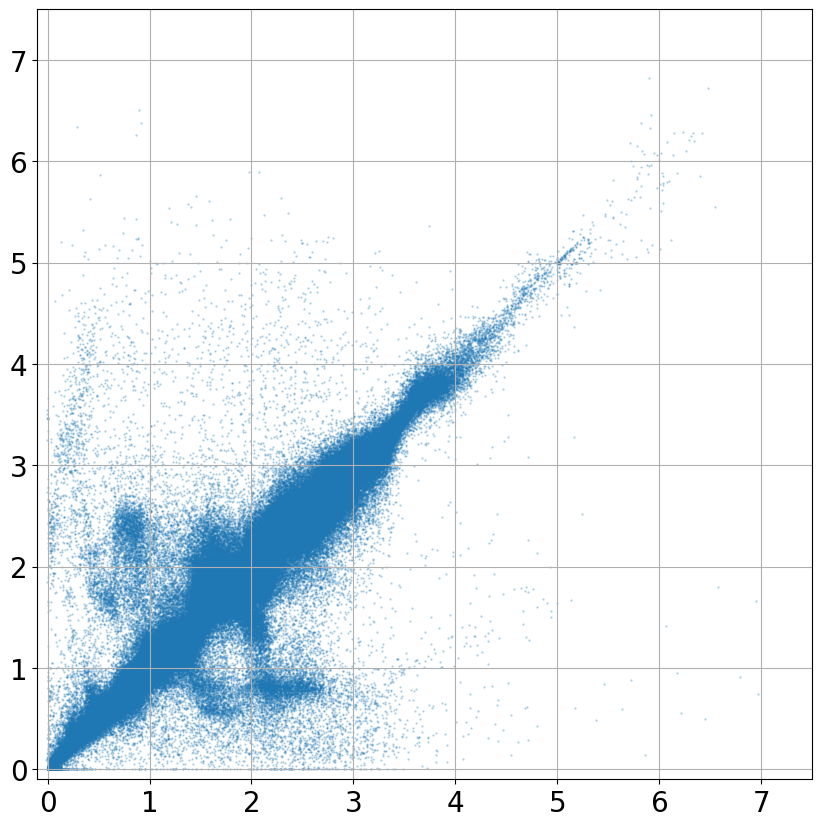

In [28]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result['Z'], result['mode'], s=0.4, alpha=0.3);

Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-1.11849, -1.1096, -1.10651, -1.12725, -1.11113]
AVG train loss: -1.11459
Train S_nmad: 0.02354	Train out_rate: 0.03446	Train S_nmad_z5: 0.00637	Train out_rate_z5: 0.0	
----------------------------------------
Test losses: [-0.96482, -0.97241, -0.96823, -0.97629, -0.97864]
AVG test loss: -0.97208
Test S_nmad: 0.02946	Test out_rate: 0.04268	Test S_nmad_z5: 0.0145	Test out_rate_z5: 0.10145	
----------------------------------------
Time: 8.366


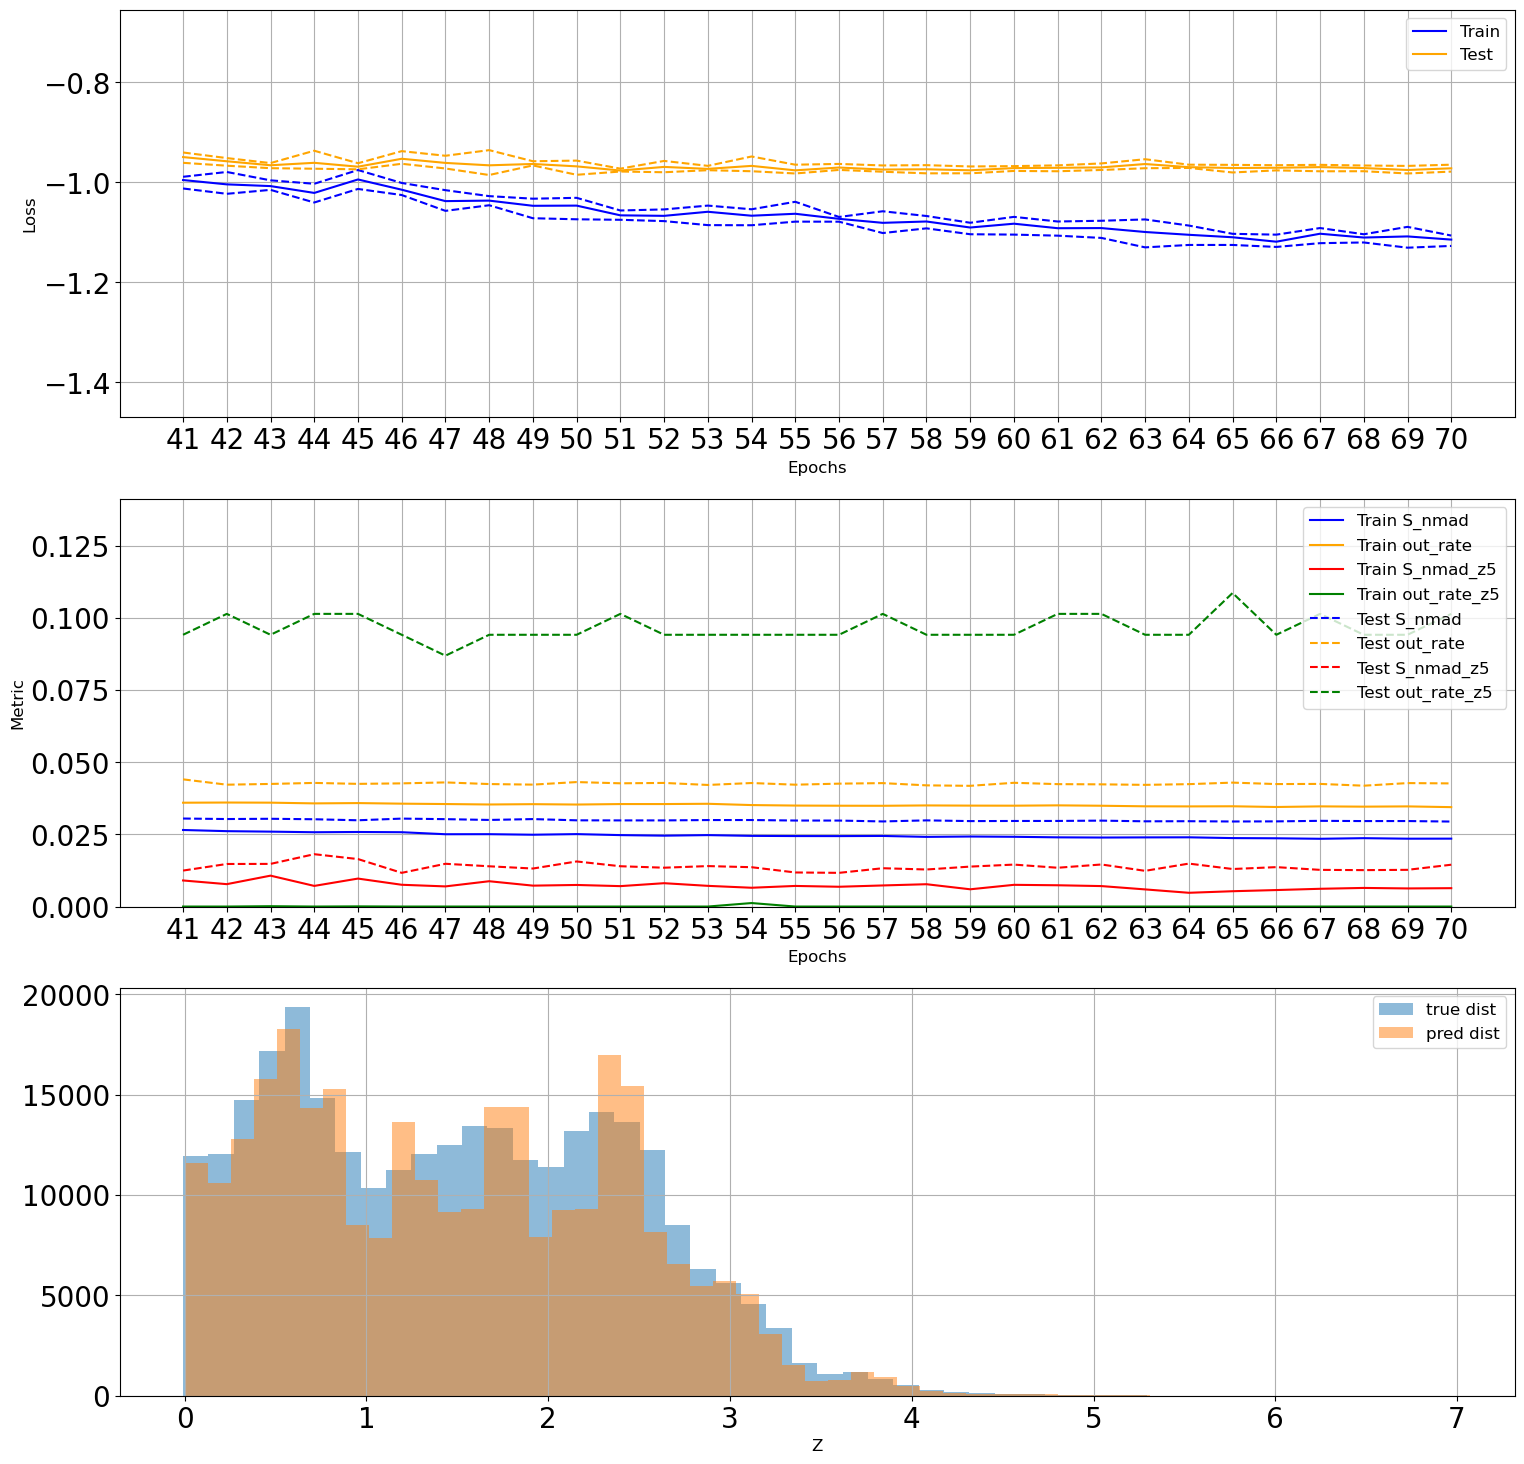

(286201, 5)
(286201, 5)
(289975, 5)
(289975, 5)


RA        DEC         Z  fold  sdssdr16_u_psf  sdssdr16_g_psf  \
0        24.196261 -10.109838 -0.011447     2       20.842147       19.756733   
1       170.455790  19.878579 -0.009112     1       21.240596       19.528449   
2       184.240161   0.634044 -0.007947     2       19.550209       18.671965   
3       122.091429  30.926546 -0.005114     2       22.468104       21.251481   
4        18.832807  25.355562 -0.002058     1       19.957126       19.084415   
...            ...        ...       ...   ...             ...             ...   
576171   36.507807   3.049838  6.541200     2       24.312627       24.815416   
576172   16.619326  18.475668  6.578712     1       21.326311       21.173190   
576173  174.891806  49.894562  6.795398     1       24.230143       24.980301   
576174  357.461364   6.252772  6.949000     1       22.151268       21.827504   
576175  190.684389  45.911862  6.968027     1       23.725394       23.692442   

        sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  \
0            19.267105       19.053641       18.921812          20.784370   
1            18.831749       18.584223       18.425744          21.187583   
2            18.413090       18.318118       18.306308          19.526882   
3            20.282878       20.080934       19.888133          19.921550   
4            18.829452       18.737669       18.721188          19.828226   
...                ...             ...             ...                ...   
576171       24.377670       23.445890       20.656290          24.437056   
576172       20.940946       20.570890       19.888027          20.803366   
576173       23.235294       22.281788       20.942590          20.276665   
576174       21.142139       20.551375       20.220181          21.855427   
576175       22.682931       21.596302       20.657546          22.140958   

        ...  sample_279  sample_280  sample_281  sample_282  sample_283  \
0       ...    1.626722    0.050494    1.222410    2.911736    1.704936   
1       ...    2.009381    2.587418    0.467679    2.759647    1.865791   
2       ...    0.124383    1.990884    1.446143    0.238181    2.462763   
3       ...    3.082868    1.265657    1.956636    0.297309    0.157598   
4       ...    2.197639    0.051605    1.754927    0.070407    1.567056   
...     ...         ...         ...         ...         ...         ...   
576171  ...    6.388409    6.344747    6.235407    7.200814    6.394256   
576172  ...    1.786491    1.813372    2.077574    1.849713    2.076379   
576173  ...    0.823997    0.859312    0.827502    0.831607    1.004371   
576174  ...    1.588980    1.617948    1.422375    1.376626    1.682334   
576175  ...    1.050881    0.506817    0.811185    0.824115    0.781517   

        sample_284  sample_285  sample_286  sample_287     zConf  
0         0.031905    1.888451   -0.020979    1.458922  0.145833  
1         2.419238   -0.316047    2.331807    1.869737  0.156250  
2         0.122098    1.830244    2.517395    0.157035  0.190972  
3         3.573821    3.088546    0.207678    0.257758  0.312500  
4        -0.108391    1.547982    2.594013    1.810312  0.159722  
...            ...         ...         ...         ...       ...  
576171    6.165243    6.356160    6.585910    6.057245  0.819444  
576172    2.045626    2.073032    1.952284    1.954203  0.746528  
576173    0.806119    0.761403    0.856164    0.775306  0.753472  
576174    1.436514    1.694484    1.937071    1.546734  0.701389  
576175    0.690108    0.700208    0.826890    0.777814  0.722222  

[576176 rows x 441 columns]

In [29]:
features_no = '20'
features = features_dict[features_no]
n_gauss = 5

#===========

n_dup = 500
z_thr = 4.5
n_epoch = 70
n_models = 5

#===========

name = f'train20_{features_no}_g{n_gauss}_m{n_models}'

def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6)))# + 0.00002*np.exp((-6)*(z-1)**2) + 0.00002*np.exp((-3)*(z-2)**2)

rf_features = ['max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z',]

t_01 = train_20_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_01 = t_01[features].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_20_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_02 = t_02[features].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

X_full = np.concatenate([X_01, X_02], axis=0)
y_full = np.concatenate([y_01, y_02], axis=0)

#===========

np.random.seed(1)
torch.manual_seed(1)

ens_full = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_full.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_full.save_pickle(f'{name}_model_full.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_01 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_01.save_pickle(f'{name}_model_01.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_02 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_02.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_02.save_pickle(f'{name}_model_02.pkl');

#===========

ens_01 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_01.pkl')
ens_02 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_02.pkl')
import warnings
warnings.filterwarnings('ignore')

result_01 = ens_02.predict(X_01)
result_01 = pd.concat([t_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_01], axis=1)
result_02 = ens_01.predict(X_02)
result_02 = pd.concat([t_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_02], axis=1)
result = pd.concat([result_01, result_02])
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

0.02952038514940473
0.04267966732387326
0.023571645526378315
0.052206929283341245
0.014438008193507509
0.06474820143884892


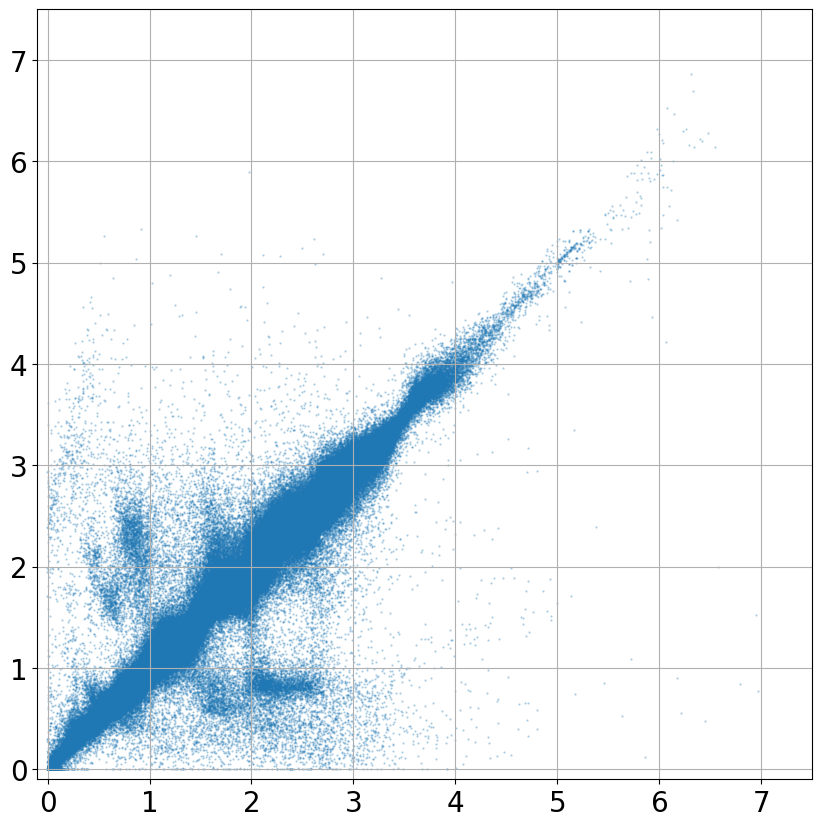

In [30]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result['Z'], result['mode'], s=0.4, alpha=0.3);

Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-0.91988, -0.9241, -0.92037, -0.93251, -0.93507]
AVG train loss: -0.92639
Train S_nmad: 0.02691	Train out_rate: 0.05552	Train S_nmad_z5: 0.00657	Train out_rate_z5: 0.0003	
----------------------------------------
Test losses: [-0.76288, -0.76132, -0.74939, -0.74761, -0.77192]
AVG test loss: -0.75862
Test S_nmad: 0.0343	Test out_rate: 0.0672	Test S_nmad_z5: 0.01631	Test out_rate_z5: 0.08696	
----------------------------------------
Time: 8.235


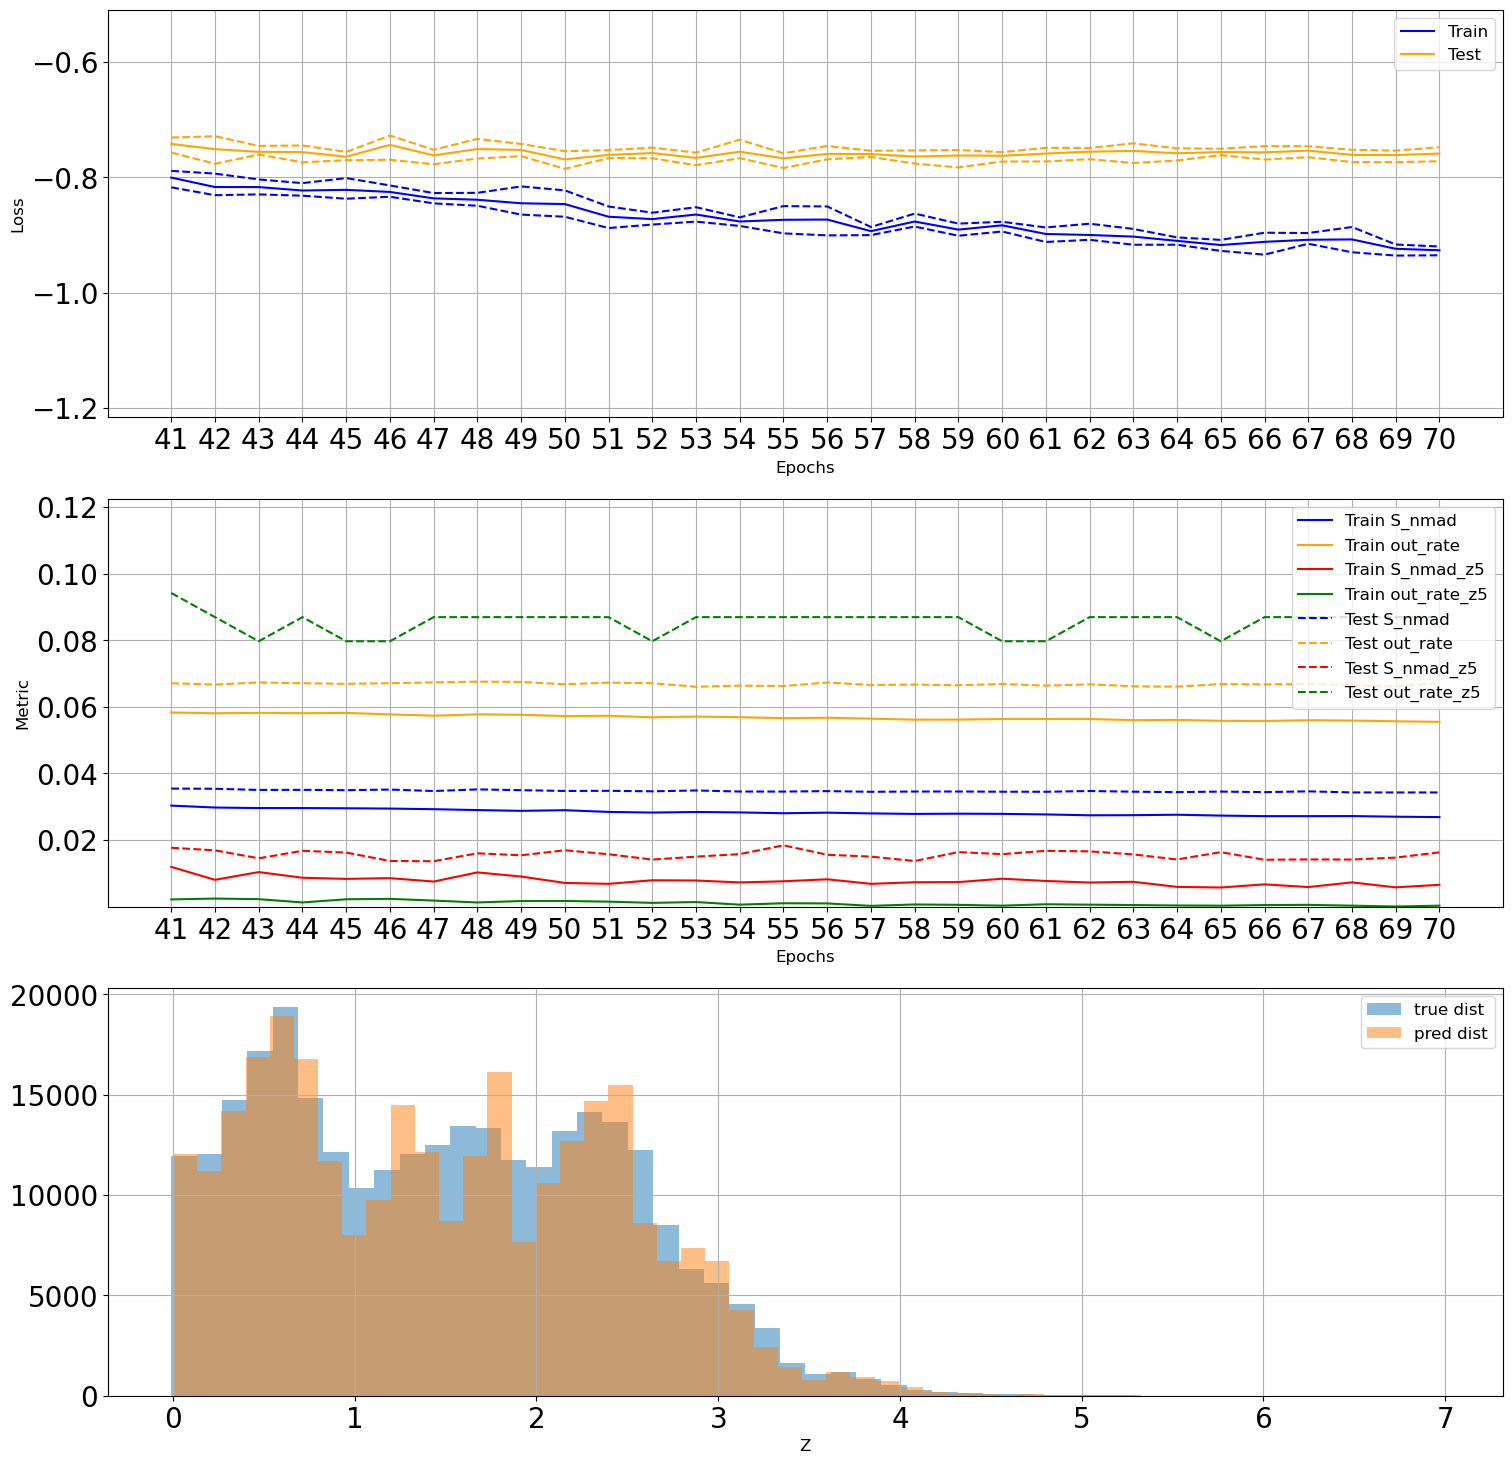

(286201, 5)
(286201, 5)
(289975, 5)
(289975, 5)


RA        DEC         Z  fold  psdr2_i_kron  psdr2_y_kron  \
0        24.196261 -10.109838 -0.011447     2     19.116320     19.068058   
1       170.455790  19.878579 -0.009112     1     18.687397     18.681302   
2       184.240161   0.634044 -0.007947     2     18.379780     18.474655   
3       122.091429  30.926546 -0.005114     2     20.276420     19.863299   
4        18.832807  25.355562 -0.002058     1     18.920195     18.969720   
...            ...        ...       ...   ...           ...           ...   
576171   36.507807   3.049838  6.541200     2     23.469465     19.334743   
576172   16.619326  18.475668  6.578712     1     20.719711     21.028206   
576173  174.891806  49.894562  6.795398     1     21.231303     20.173883   
576174  357.461364   6.252772  6.949000     1     20.599356     20.023176   
576175  190.684389  45.911862  6.968027     1     20.901826     20.291515   

        psdr2_g_psf  psdr2_r_psf  psdr2_i_psf  psdr2_z_psf  ...  sample_279  \
0         19.627118    19.232438    19.028416    19.044834  ...    2.704366   
1         19.416708    18.778855    18.585054    18.448668  ...    1.812028   
2         18.600041    18.511219    18.306770    18.392407  ...    1.279110   
3         21.026230    20.352606    19.979666    19.799399  ...    3.189671   
4         19.055118    18.827369    18.581013    18.792287  ...    2.428422   
...             ...          ...          ...          ...  ...         ...   
576171    23.155930    24.193542    23.469465    21.443734  ...    6.276309   
576172    21.492578    21.041115    20.829462    20.368639  ...    1.973409   
576173    23.850854    22.523995    21.486908    21.368529  ...    0.758926   
576174    21.837908    20.968045    20.592318    20.199249  ...    1.799167   
576175    23.809905    22.707770    21.660339    20.932233  ...    0.788934   

        sample_280  sample_281  sample_282  sample_283  sample_284  \
0         2.303937    1.924521    3.283681    2.465700    2.037367   
1         0.343730    4.215315    0.390303    2.117322    1.998167   
2         1.706342    1.413427    2.494734    0.316083    1.660410   
3         2.947003    3.240963    3.122048    2.899087    4.067726   
4         0.421692    2.233126    1.057595    1.768969    1.100583   
...            ...         ...         ...         ...         ...   
576171    6.086181    6.105029    6.589382    6.115283    6.652743   
576172    1.688862    2.124056    1.980140    2.073186    2.139187   
576173    0.777643    0.763346    0.768523    0.736133    0.747361   
576174    2.090422    1.510918    1.054916    2.214959    2.384104   
576175    0.707173    0.849751    0.860222    0.719738    0.762166   

        sample_285  sample_286  sample_287     zConf  
0         2.223880    1.278982    2.210324  0.180556  
1         0.374037    1.928498    2.481422  0.111111  
2         1.461946    3.072128    2.113491  0.100694  
3         2.073276    0.464246    2.791510  0.357639  
4         1.749021    2.997729    2.023362  0.159722  
...            ...         ...         ...       ...  
576171    6.084498    6.404276    6.472050  0.781250  
576172    2.069697    1.943792    2.063025  0.850694  
576173    0.715103    0.775464    0.744741  0.875000  
576174    3.218307    2.139001    1.676989  0.378472  
576175    0.736574    0.835985    0.800084  0.767361  

[576176 rows x 440 columns]

In [31]:
features_no = '21'
features = features_dict[features_no]
n_gauss = 5

#===========

n_dup = 500
z_thr = 4.5
n_epoch = 70
n_models = 5

#===========

name = f'train20_{features_no}_g{n_gauss}_m{n_models}'

def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6)))# + 0.00002*np.exp((-6)*(z-1)**2) + 0.00002*np.exp((-3)*(z-2)**2)

rf_features = ['max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z',]

t_01 = train_20_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_01 = t_01[features].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_20_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_02 = t_02[features].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

X_full = np.concatenate([X_01, X_02], axis=0)
y_full = np.concatenate([y_01, y_02], axis=0)

#===========

np.random.seed(1)
torch.manual_seed(1)

ens_full = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_full.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_full.save_pickle(f'{name}_model_full.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_01 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_01.save_pickle(f'{name}_model_01.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_02 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_02.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_02.save_pickle(f'{name}_model_02.pkl');

#===========

ens_01 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_01.pkl')
ens_02 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_02.pkl')
import warnings
warnings.filterwarnings('ignore')

result_01 = ens_02.predict(X_01)
result_01 = pd.concat([t_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_01], axis=1)
result_02 = ens_01.predict(X_02)
result_02 = pd.concat([t_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_02], axis=1)
result = pd.concat([result_01, result_02])
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

0.034513825990732334
0.06709755352531172
0.022367629539584398
0.04935927859515899
0.01691620506289091
0.050359712230215826


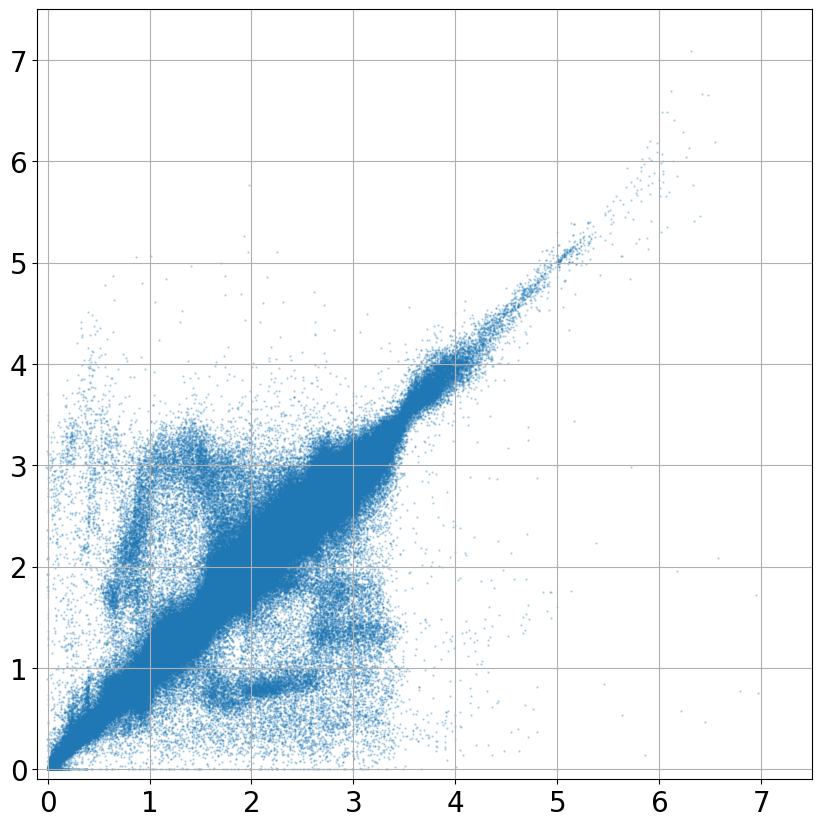

In [32]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result['Z'], result['mode'], s=0.4, alpha=0.3);

Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-0.51195, -0.52586, -0.50935, -0.50619, -0.50257]
AVG train loss: -0.51118
Train S_nmad: 0.04451	Train out_rate: 0.09973	Train S_nmad_z5: 0.00612	Train out_rate_z5: 0.0126	
----------------------------------------
Test losses: [-0.45506, -0.46153, -0.4663, -0.45735, -0.45917]
AVG test loss: -0.45988
Test S_nmad: 0.05238	Test out_rate: 0.10745	Test S_nmad_z5: 0.01843	Test out_rate_z5: 0.07246	
----------------------------------------
Time: 7.96


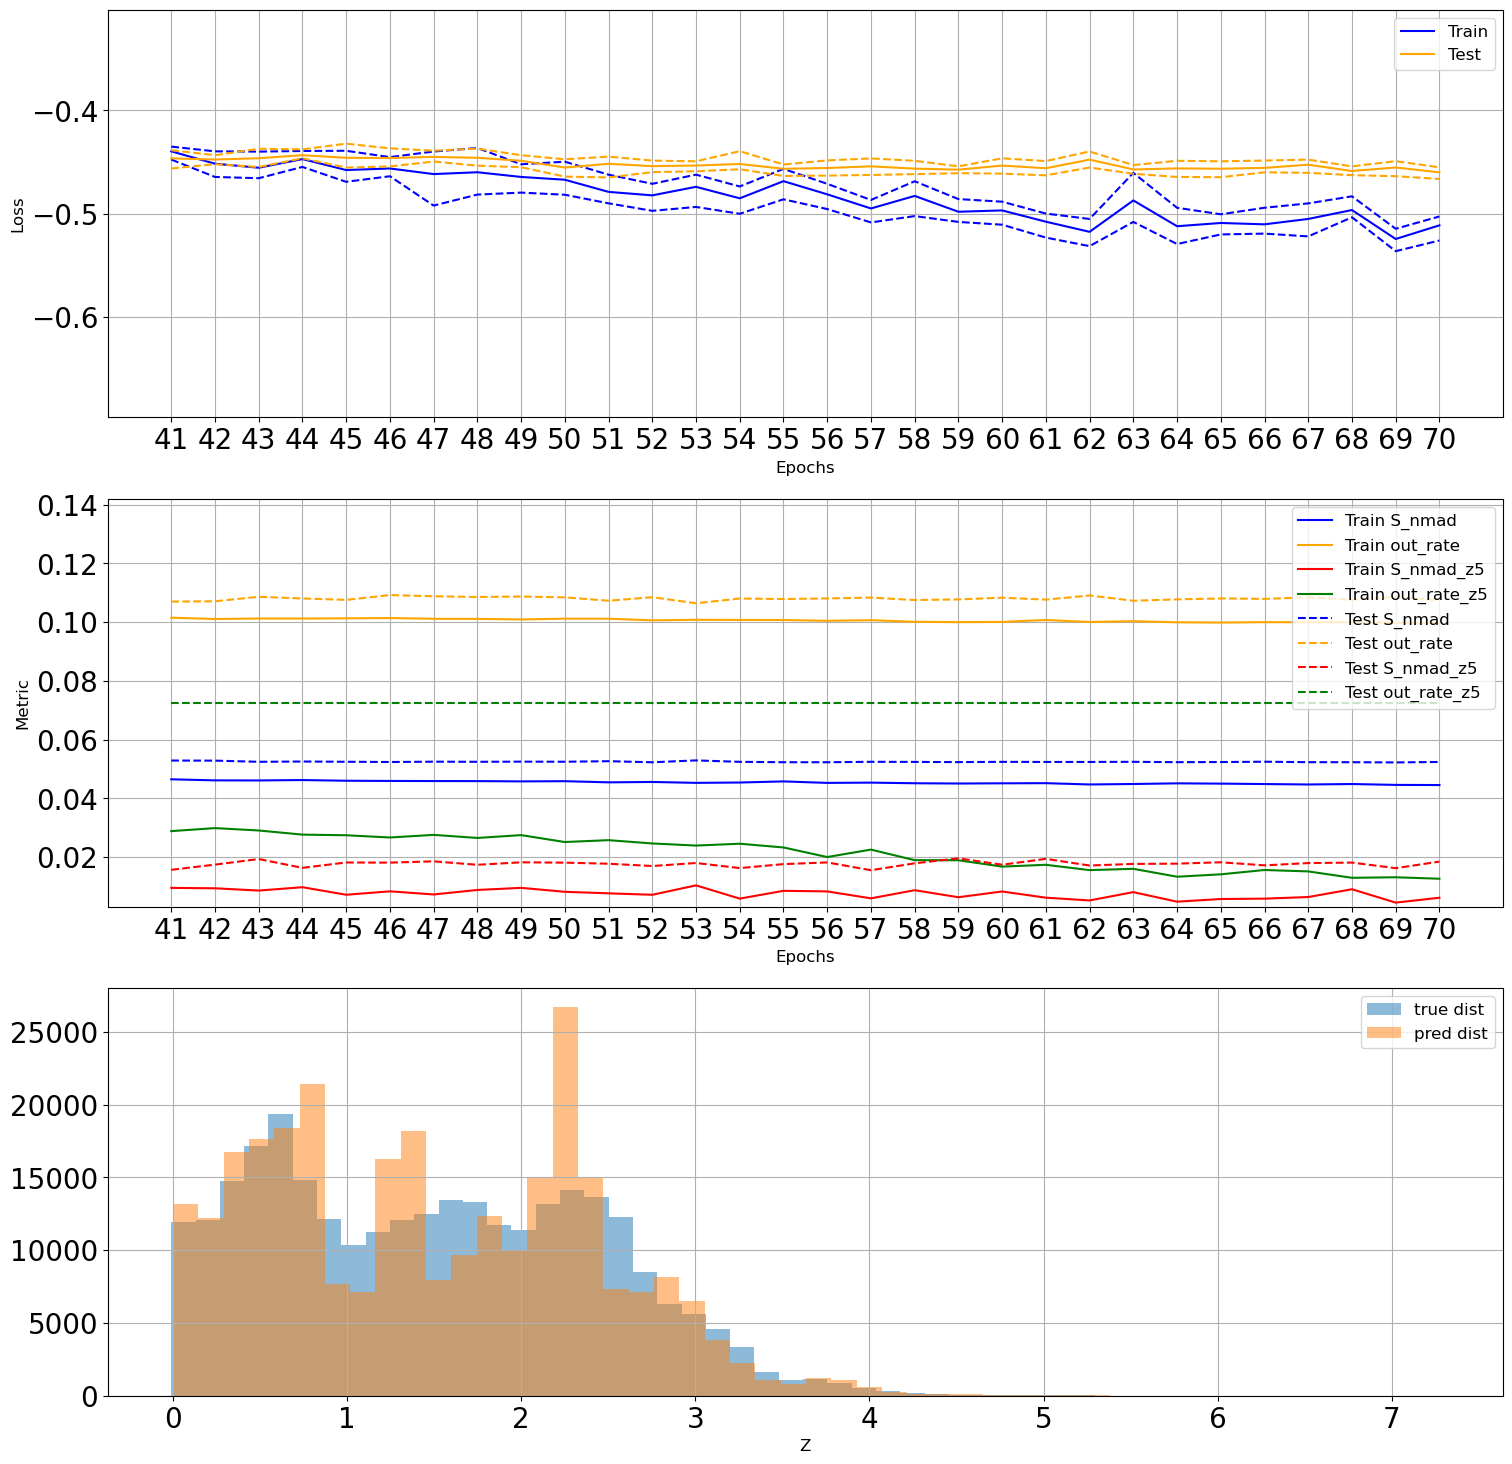

(286201, 5)
(286201, 5)
(289975, 5)
(289975, 5)


RA        DEC         Z  fold  decals8tr_Lw1-Lw2  \
0        24.196261 -10.109838 -0.011447     2          -0.137297   
1       170.455790  19.878579 -0.009112     1          -0.592985   
2       184.240161   0.634044 -0.007947     2          -0.636057   
3       122.091429  30.926546 -0.005114     2           0.929939   
4        18.832807  25.355562 -0.002058     1          -0.869850   
...            ...        ...       ...   ...                ...   
576171   36.507807   3.049838  6.541200     2          -0.122253   
576172   16.619326  18.475668  6.578712     1           0.700824   
576173  174.891806  49.894562  6.795398     1          -0.520175   
576174  357.461364   6.252772  6.949000     1           0.589668   
576175  190.684389  45.911862  6.968027     1          -0.673457   

        decals8tr_Lw1  decals8tr_Lw2  decals8tr_g  decals8tr_r  decals8tr_z  \
0           19.960258      20.097554    19.708072    19.182611    18.952056   
1           19.606560      20.199544    19.441993    18.753491    18.437092   
2           19.350478      19.986535    18.620714    18.362966    18.315778   
3           21.271493      20.341554    21.105814    20.244741    19.799577   
4           20.385595      21.255445    19.100432    18.798307    18.728667   
...               ...            ...          ...          ...          ...   
576171      19.298994      19.421248    26.223082    26.277044    20.027368   
576172      19.876354      19.175530    21.424010    20.911987    20.366477   
576173      18.780787      19.300962    23.706961    22.230237    20.638693   
576174      18.987589      18.397922    21.990789    21.004891    20.299559   
576175      18.811224      19.484681    22.557081    21.177217    19.417213   

        ...  sample_279  sample_280  sample_281  sample_282  sample_283  \
0       ...   -0.284496    0.232260   -0.000977    0.136711   -0.047334   
1       ...    2.248067    1.543320    3.827828    1.842321    1.627425   
2       ...    0.054164   -0.007643   -0.021553    0.070867    0.111060   
3       ...    2.622574    1.927325    2.537264    3.071236    1.030701   
4       ...    0.018461   -0.122716    2.310924    0.524121    1.426006   
...     ...         ...         ...         ...         ...         ...   
576171  ...    7.134406    6.781764    7.008371    7.094009    6.799822   
576172  ...    1.792963    1.833943    2.385675    1.901250    2.105776   
576173  ...    0.781334    0.813069    0.786733    0.793056    0.750109   
576174  ...    1.604706    1.757499    1.501095    1.126975    1.850313   
576175  ...    0.956501    0.657076    0.817458    0.842358    0.781409   

        sample_284  sample_285  sample_286  sample_287     zConf  
0         2.455418    0.116233    0.140632    0.399550  0.222222  
1         0.084769    2.907617    3.025543    2.421011  0.180556  
2         0.010759   -0.021247    1.485939    0.032530  0.329861  
3         3.600247    2.636509    0.420469   -0.044015  0.135417  
4         1.123572   -0.029713    0.207938    1.700903  0.142361  
...            ...         ...         ...         ...       ...  
576171    7.145312    7.150554    7.387616    6.981351  0.815972  
576172    2.315163    2.094846    1.700481    2.180244  0.437500  
576173    0.780602    0.749883    0.809988    0.737666  0.892361  
576174    1.389853    1.657633    5.847805    1.695798  0.576389  
576175    0.026870    0.689346    0.922768    0.871036  0.496528  

[576176 rows x 417 columns]

In [33]:
features_no = '22'
features = features_dict[features_no]
n_gauss = 5

#===========

n_dup = 500
z_thr = 4.5
n_epoch = 70
n_models = 5

#===========

name = f'train20_{features_no}_g{n_gauss}_m{n_models}'

def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6)))# + 0.00002*np.exp((-6)*(z-1)**2) + 0.00002*np.exp((-3)*(z-2)**2)

rf_features = ['max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z',]

t_01 = train_20_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_01 = t_01[features].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_20_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_02 = t_02[features].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

X_full = np.concatenate([X_01, X_02], axis=0)
y_full = np.concatenate([y_01, y_02], axis=0)

#===========

np.random.seed(1)
torch.manual_seed(1)

ens_full = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_full.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_full.save_pickle(f'{name}_model_full.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_01 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_01.save_pickle(f'{name}_model_01.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_02 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_02.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_02.save_pickle(f'{name}_model_02.pkl');

#===========

ens_01 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_01.pkl')
ens_02 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_02.pkl')
import warnings
warnings.filterwarnings('ignore')

result_01 = ens_02.predict(X_01)
result_01 = pd.concat([t_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_01], axis=1)
result_02 = ens_01.predict(X_02)
result_02 = pd.concat([t_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_02], axis=1)
result = pd.concat([result_01, result_02])
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

0.05248442160344494
0.10838007830940546
0.02759428879882718
0.061699098243948744
0.018401164696319527
0.050359712230215826


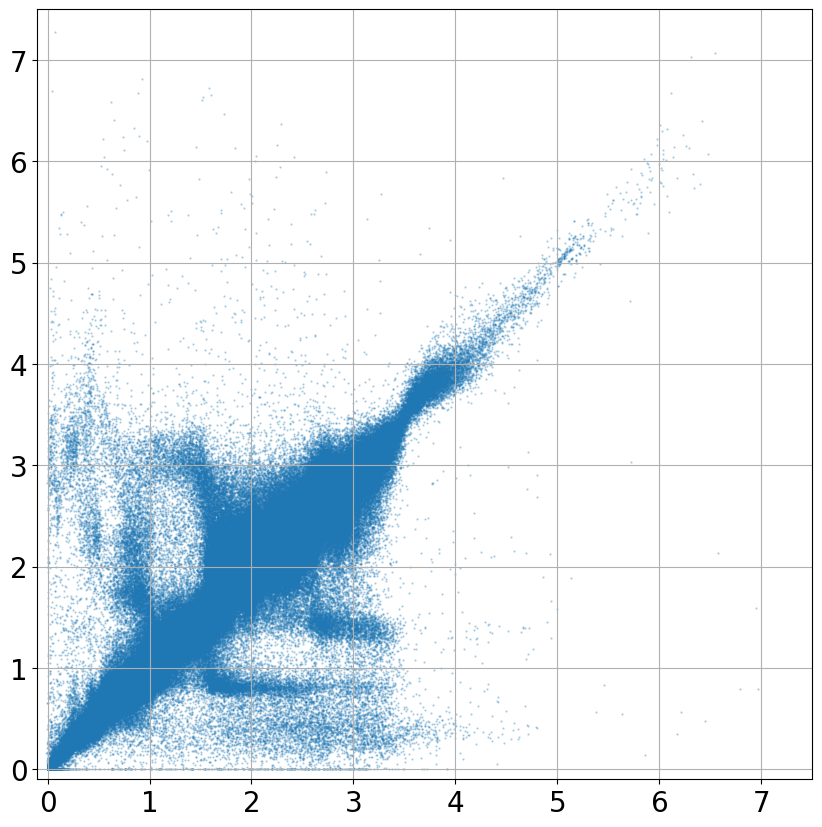

In [34]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result['Z'], result['mode'], s=0.4, alpha=0.3);

In [ ]:
#train 20 MSE

In [36]:
class MSE_Model(nn.Module):
    def __init__(self, sizes, p, device):
        super().__init__()
        self.sizes = sizes
        layers = []
        for i in range(1, len(sizes)-1):
            if i > 1:
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(p))
            layers.append(nn.Linear(self.sizes[i-1], self.sizes[i], bias=False))
            layers.append(nn.BatchNorm1d(self.sizes[i]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p))
        self.layers = nn.Sequential(*layers)
        self.layers.apply(self.init_weights)
        self.mu = nn.Linear(self.sizes[-2], self.sizes[-1])
        self.init_weights(self.mu)
        self.relu = nn.ReLU()
        self.loss = nn.MSELoss()
        self.device = device
        self.to(self.device)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    
    def forward(self, x, train_m):
        self.train(train_m)
        x = self.layers(x)
        mu = self.relu(self.mu(x))
        return mu
    
    def run_epoch(self, dataloader, optimizer=None, scheduler=None, loss_f=None):
        train_m = (optimizer is not None) and (loss_f is not None)
        true, mu = [], []
        for X, y in dataloader:
            if train_m:
                optimizer.zero_grad()
            batch_mu = self(X, train_m)
            if train_m:
                loss = loss_f(y.view(-1, 1), batch_mu)
                loss.backward()
                optimizer.step()
            true.append(y.cpu().detach().numpy())
            mu.append(batch_mu.cpu().detach().numpy())
        if train_m:
            scheduler.step()
        true = np.concatenate(true)
        mu = np.concatenate(mu)
        return true.reshape(-1), mu.reshape(-1)
        
    def fit(
        self, 
        TrainDataloader, train_dataloader_params, 
        TestDataloader=None, test_dataloader_params={},
        epochs=5,
        optimizer=torch.optim.Adam, optimizer_args={'lr': 0.0005, 'weight_decay': 0.0001}, 
        scheduler=torch.optim.lr_scheduler.ExponentialLR, scheduler_args={'gamma': 0.9},
        verbose=True, metrics=[]
    ):
        test_m = TestDataloader is not None
        if test_m:
            test_dataloader = TestDataloader(**test_dataloader_params)
        
        optimizer_o = optimizer(self.parameters(), **optimizer_args)
        scheduler_o = scheduler(optimizer_o, **scheduler_args)

        train_metric_vals = {metric: [] for metric in metrics}
        train_losses = []
        if test_m:
            test_metric_vals = {metric: [] for metric in metrics}
            test_losses = []
        else:
            test_metric_vals = None
            test_losses = None
    
        for epoch in range(epochs):
            start = time.time()
            
            cur_lr = scheduler_o.get_last_lr()

            train_dataloader = TrainDataloader(**train_dataloader_params)

            epoch_true, mu = self.run_epoch(train_dataloader, optimizer_o, scheduler_o, self.loss)
            epoch_loss = self.loss(torch.Tensor(epoch_true), torch.Tensor(mu)).item()
            
            train_losses.append(epoch_loss)
            for metric in metrics:
                train_metric_vals[metric].append(metrics[metric](epoch_true, mu))
                
            #TEST
            if test_m:     
                epoch_true, mu = self.run_epoch(test_dataloader)
                epoch_loss = self.loss(torch.Tensor(epoch_true), torch.Tensor(mu)).item()

                test_losses.append(epoch_loss)
                for metric in metrics:
                    test_metric_vals[metric].append(metrics[metric](epoch_true, mu))    
                
            if verbose and epoch > 0:
                clear_output(True)
                print(f'Device: {self.device}')
                print(f'Test mode: {test_m}')
                print('=' * 40)
                print(f'EPOCH #{epoch+1}/{epochs}:')
                print(f'Learning rate: {round(cur_lr[0], 8)}')
                print('-' * 40)

                print(f'Trian loss: {round(train_losses[-1], 5)}')
                for metric in metrics:
                      print(f'Train {metric}: {round(train_metric_vals[metric][-1], 5)}\t', end='')
                print()
                print('-' * 40)
                
                if test_m:
                    print(f'Test losses: {round(test_losses[-1], 5)}')
                    for metric in metrics:
                          print(f'Test {metric}: {round(test_metric_vals[metric][-1], 5)}\t', end='')
                    print()
                    print('-' * 40)

                print(f'Time: {round(time.time() - start, 3)}')
                print('=' * 40)

                #GRAPHICS
                fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 18))

                colors = ['blue', 'orange', 'red', 'green', 'black', 'purple']
                DISPLAY_LAG = 30
                FIRST_IDX = max(1, epoch+1-DISPLAY_LAG)
                ticks = list(range(1, epoch+2))[FIRST_IDX:]
                
                ax[0].plot(ticks, train_losses[FIRST_IDX:], c='b')
                
                if test_m:
                    ax[0].plot(ticks, test_losses[FIRST_IDX:], c='orange')
                
                if not test_m:
                    y_min = min(train_losses)
                    y_max = max(train_losses)
                else:
                    y_min = min(train_losses+test_losses)
                    y_max = max(train_losses+test_losses)
                y_min -= 0.3 * np.abs(y_min)
                y_max += 0.3 * np.abs(y_max)
                ax[0].set_ylim(y_min, y_max)
                ax[0].set_xticks(ticks)
                ax[0].set_xlabel('Epochs', fontsize=12)
                ax[0].set_ylabel('Loss', fontsize=12)
                ax[0].legend(loc=0, fontsize=12)
                ax[0].grid('on')
                
                for i, metric in enumerate(metrics):
                    ax[1].plot(ticks, train_metric_vals[metric][FIRST_IDX:], c=colors[i], label=f'Train {metric}')
                if test_m:
                    for i, metric in enumerate(metrics):
                        ax[1].plot(ticks, test_metric_vals[metric][FIRST_IDX:], c=colors[i], linestyle='--', label=f'Test {metric}')
                t = []
                for metric in metrics:
                    t += train_metric_vals[metric][FIRST_IDX:]
                if test_m:
                    for metric in metrics:
                        t += test_metric_vals[metric][FIRST_IDX:]
                y_min, y_max = min(t), max(t)
                y_min -= 0.3 * np.abs(y_min)
                y_max += 0.3 * np.abs(y_max)
                ax[1].set_ylim(y_min, y_max)
                ax[1].set_xticks(ticks)
                ax[1].set_xlabel('Epochs', fontsize=12)
                ax[1].set_ylabel('Metric', fontsize=12)
                ax[1].legend(loc=0, fontsize=12)
                ax[1].grid('on')
                
                ax[2].hist(epoch_true, bins=50, label='true dist', alpha=0.5)
                ax[2].hist(mu, bins=50, label='pred dist', alpha=0.5)
                ax[2].set_xlabel('Z', fontsize=12)
                ax[2].legend(loc=0, fontsize=12)
                ax[2].grid('on')
                
                plt.show()
                
        return train_metric_vals, train_losses, test_metric_vals, test_losses
    
    def predict(self, X, batch_size=2**13):  
        X_tensor = torch.tensor(X, device=torch.device(self.device), dtype=torch.float)
        y_tensor = torch.tensor([0] * len(X_tensor), device=torch.device(self.device), dtype=torch.float)
        
        dataloader = DeepEnsemble.SimpleDataloader(
            X_tensor, y_tensor,
            batch_size=batch_size, shuffle=False
        )
        
        epoch_true, mu = self.run_epoch(dataloader)
        
        return mu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Device: cuda
Test mode: True
EPOCH #30/30:
Learning rate: 0.0003061
----------------------------------------
Trian loss: 0.03281
Train S_nmad: 0.04171	Train out_rate: 0.03918	Train S_nmad_z5: 0.01954	Train out_rate_z5: 0.0	
----------------------------------------
Test losses: 0.07724
Test S_nmad: 0.05379	Test out_rate: 0.07579	Test S_nmad_z5: 0.07907	Test out_rate_z5: 0.19565	
----------------------------------------
Time: 1.749


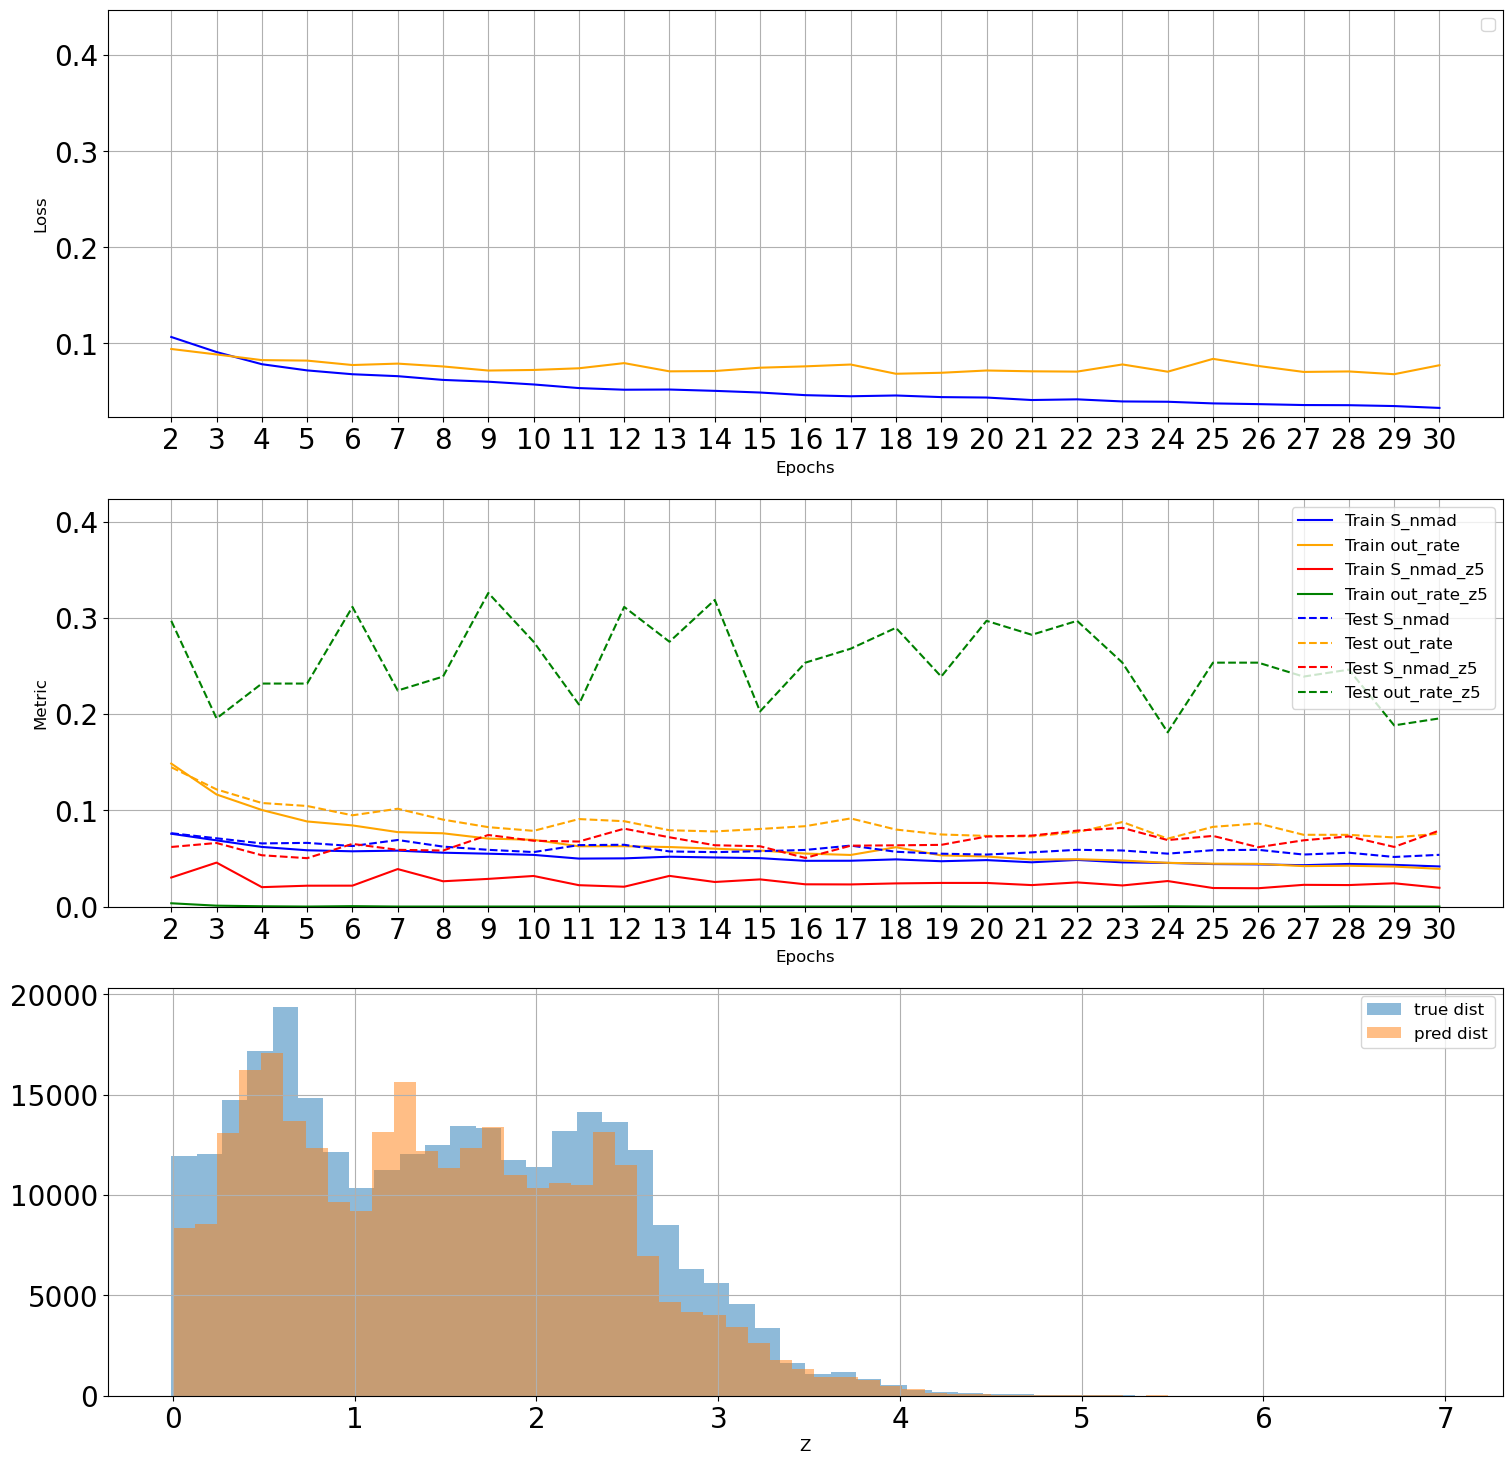

RA        DEC         Z  fold  sdssdr16_u_psf  sdssdr16_g_psf  \
0        24.196261 -10.109838 -0.011447     2       20.842147       19.756733   
1       170.455790  19.878579 -0.009112     1       21.240596       19.528449   
2       184.240161   0.634044 -0.007947     2       19.550209       18.671965   
3       122.091429  30.926546 -0.005114     2       22.468104       21.251481   
4        18.832807  25.355562 -0.002058     1       19.957126       19.084415   
...            ...        ...       ...   ...             ...             ...   
576171   36.507807   3.049838  6.541200     2       24.312627       24.815416   
576172   16.619326  18.475668  6.578712     1       21.326311       21.173190   
576173  174.891806  49.894562  6.795398     1       24.230143       24.980301   
576174  357.461364   6.252772  6.949000     1       22.151268       21.827504   
576175  190.684389  45.911862  6.968027     1       23.725394       23.692442   

        sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  \
0            19.267105       19.053641       18.921812          20.784370   
1            18.831749       18.584223       18.425744          21.187583   
2            18.413090       18.318118       18.306308          19.526882   
3            20.282878       20.080934       19.888133          19.921550   
4            18.829452       18.737669       18.721188          19.828226   
...                ...             ...             ...                ...   
576171       24.377670       23.445890       20.656290          24.437056   
576172       20.940946       20.570890       19.888027          20.803366   
576173       23.235294       22.281788       20.942590          20.276665   
576174       21.142139       20.551375       20.220181          21.855427   
576175       22.682931       21.596302       20.657546          22.140958   

        ...  sdssdr16_g_cmodel-decals8tr_g  sdssdr16_r_cmodel-decals8tr_r  \
0       ...                       0.046929                       0.077926   
1       ...                       0.087280                       0.072679   
2       ...                       0.029889                       0.037541   
3       ...                       0.154109                       0.027697   
4       ...                      -0.010383                       0.020552   
...     ...                            ...                            ...   
576171  ...                      -4.455494                      -5.371558   
576172  ...                      -0.384162                      -0.032324   
576173  ...                      -1.142203                       0.614252   
576174  ...                      -0.320411                      -0.020490   
576175  ...                      -0.019306                       0.490542   

        sdssdr16_z_cmodel-decals8tr_z   max21_z  conf21_z   max22_z  conf22_z  \
0                           -0.039920  0.050839  0.118156  0.087129  0.142408   
1                           -0.037778  2.498000  0.204978  0.100268  0.117886   
2                           -0.058617  0.151387  0.117320  0.055640  0.200341   
3                            0.031030  2.556220  0.221226  0.268127  0.130353   
4                           -0.026118  1.459070  0.220922  1.552094  0.202644   
...                               ...       ...       ...       ...       ...   
576171                       0.591030  6.519252  0.359223  6.588100  0.798716   
576172                      -0.449468  2.017000  0.548638  2.144774  0.371407   
576173                      -0.436247  0.743776  0.375718  0.837000  0.479773   
576174                      -0.187273  2.095132  0.363373  1.550000  0.523302   
576175                       0.371519  0.799996  0.439501  0.606367  0.225533   

         max35_z  conf35_z        mu  
0       0.076411  0.167270  1.749249  
1       3.230971  0.244179  2.417109  
2       0.112295  0.151217  2.082478  
3       0.289233  0.102691  3.094314  
4       2.388000  0.21374

In [38]:
features_no = '35'
features = features_dict[features_no]

#===========

n_dup = 500
z_thr = 4.5
n_epoch = 30

#===========

name = f'train20_{features_no}_mse_m{n_models}'

def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6)))# + 0.00002*np.exp((-6)*(z-1)**2) + 0.00002*np.exp((-3)*(z-2)**2)

rf_features = ['max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z',]

t_01 = train_20_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_01 = t_01[features].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_20_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_02 = t_02[features].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

X_full = np.concatenate([X_01, X_02], axis=0)
y_full = np.concatenate([y_01, y_02], axis=0)

#===========

np.random.seed(1)
torch.manual_seed(1)

ens_full = MSE_Model(
    [X_01.shape[1], 400, 400, 400, 400, 400, 400, 1], 0.0,
    device
)

X_train_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_full.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);

np.random.seed(1)
torch.manual_seed(1)

ens_01 = MSE_Model(
    [X_01.shape[1], 400, 400, 400, 400, 400, 400, 1], 0.0,
    device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);

np.random.seed(1)
torch.manual_seed(1)

ens_02 = MSE_Model(
    [X_02.shape[1], 400, 400, 400, 400, 400, 400, 1], 0.0,
    device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);

#===========

import warnings
warnings.filterwarnings('ignore')

mu_01 = ens_02.predict(X_01)
result_01 = t_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].copy()
result_01['mu'] = mu_01
mu_02 = ens_01.predict(X_02)
result_02 = t_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].copy()
result_02['mu'] = mu_02
result = pd.concat([result_01, result_02])
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

0.053198977415511606
0.07551338479908917
0.045916909545007475
0.12624584717607973
0.06595071801173265
0.1906474820143885


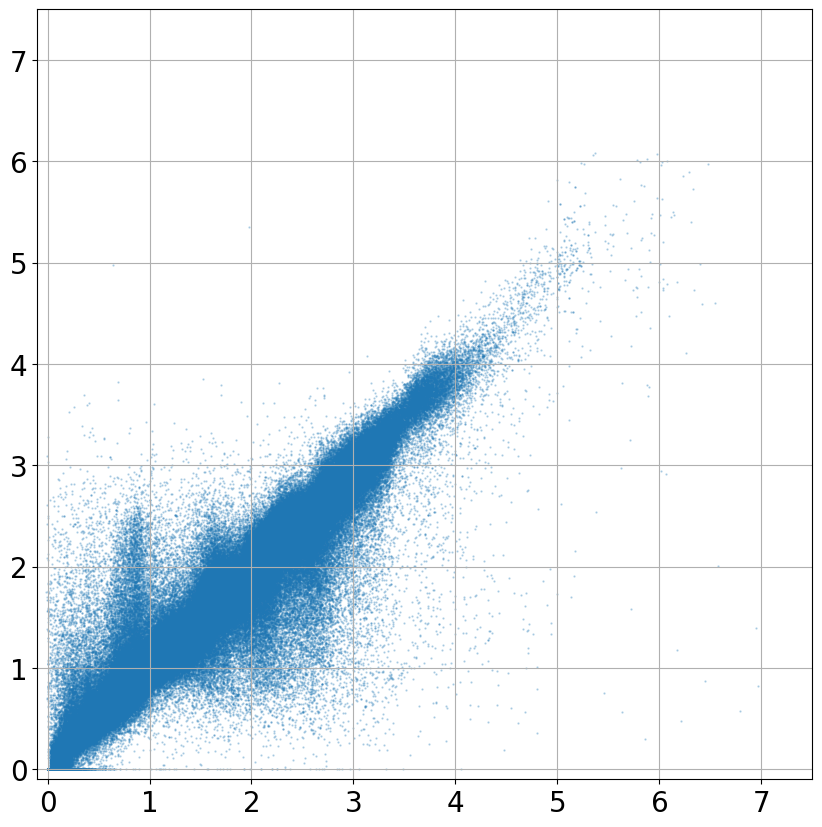

In [39]:
print(metrics.sigma_nmad(result['Z'], result['mu']))
print(metrics.out_rate(result['Z'], result['mu']))
print(metrics.sigma_nmad_z4(result['Z'], result['mu']))
print(metrics.out_rate_z4(result['Z'], result['mu']))
print(metrics.sigma_nmad_z5(result['Z'], result['mu']))
print(metrics.out_rate_z5(result['Z'], result['mu']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result['Z'], result['mu'], s=0.4, alpha=0.3);

In [ ]:
# train 15

In [40]:
train_15_01 = pd.read_csv(f'{data_dir}/train_15_01.csv')
train_15_02 = pd.read_csv(f'{data_dir}/train_15_02.csv')

In [50]:
train_15_01.shape, train_15_02.shape

((536845, 85), (536845, 85))

In [51]:
train_15_01['fold'] = [1] * train_15_01.shape[0]
train_15_01

RA        DEC         Z  decals8tr_Lw1  decals8tr_Lw1-Lw2  \
0         0.000095  24.902249  0.555913      18.174353          -0.616579   
1         0.000464  10.241075  0.654366      18.243005          -0.754709   
2         0.001661  20.397911  0.169645      21.242548          -1.474309   
3         0.001831   5.690285  0.523758      18.695298          -0.503276   
4         0.002002   2.319788  0.428199      17.363210          -0.235549   
...            ...        ...       ...            ...                ...   
536840  359.994134  24.369804  1.050241      18.356487          -0.310167   
536841  359.994636  15.377998  0.172690      16.902238          -0.279462   
536842  359.995965  -2.591785  0.868302      19.150481          -0.496807   
536843  359.997294 -10.995379  0.260268      16.530507          -0.345900   
536844  359.998608  -3.437812  0.305896      17.193668          -0.482051   

        decals8tr_Lw2  decals8tr_g  decals8tr_g-Lw1  decals8tr_g-Lw2  \
0           18.790933    22.183574         4.009220         3.392641   
1           18.997714    22.741816         4.498811         3.744101   
2           22.716857    21.863754         0.621206        -0.853103   
3           19.198574    21.492960         2.797662         2.294386   
4           17.598759    20.898229         3.535019         3.299469   
...               ...          ...              ...              ...   
536840      18.666654    23.818942         5.462455         5.152288   
536841      17.181700    18.464392         1.562154         1.282692   
536842      19.647288    24.430368         5.279887         4.783080   
536843      16.876407    19.403423         2.872916         2.527016   
536844      17.675719    20.044310         2.850641         2.368591   

        decals8tr_g-r  ...  sdssdr16_z_psf   max20_z  conf20_z   max21_z  \
0            1.796724  ...       20.150903  0.549235  0.975520  0.550143   
1            1.848274  ...       20.283504  0.604671  0.505291  0.605772   
2            0.390074  ...       21.440571  0.404558  0.198855  0.129822   
3            1.278163  ...       20.242893  0.538133  0.919854  0.517347   
4            1.808092  ...       19.440506  0.358165  0.908002  0.435412   
...               ...  ...             ...       ...       ...       ...   
536840       1.586437  ...       20.948029  0.880836  0.444436  0.979377   
536841       0.824853  ...       18.520230  0.179161  0.980164       NaN   
536842       2.103300  ...       20.628322  0.782000  0.629133  0.836784   
536843       1.555948  ...       18.091542  0.260542  0.995325       NaN   
536844       1.624514  ...       18.776211  0.336972  0.999612  0.309051   

        conf21_z   max22_z  conf22_z   max35_z  conf35_z  fold  
0       0.996528  0.565686  0.981891  0.552787  0.972381     1  
1       0.987693  0.667228  0.989898  0.620569  0.685001     1  
2       0.180870  2.741019  0.294115  0.329682  0.222887     1  
3       0.829186  0.506863  0.634865  0.525101  0.896471     1  
4       0.872971  0.383379  0.903241  0.361337  0.813836     1  
...          ...       ...       ...       ...       ...   ...  
536840  0.761644  0.958248  0.891941  0.957961  0.516049     1  
536841       NaN  0.167589  0.972226       NaN       NaN     1  
536842  0.548402  0.793587  0.481961  0.803272  0.480587     1  
536843       NaN  0.260002  0.989073       NaN       NaN     1  
536844  1.000000  0.310637  1.000000  0.328777  0.989582     1  

[536845 rows x 86 columns]

In [52]:
train_15_02['fold'] = [2] * train_15_02.shape[0]
train_15_02

RA        DEC         Z  decals8tr_Lw1  decals8tr_Lw1-Lw2  \
0         0.000344  -6.491939  0.514150      17.750178          -0.539206   
1         0.001237   4.795821  0.732226      18.295547          -0.535762   
2         0.001809   4.457336  0.695770      18.128248          -0.786123   
3         0.001911  32.112785  0.750810      18.373284          -0.785460   
4         0.002076  27.982768  0.619630      20.591525          -0.821721   
...            ...        ...       ...            ...                ...   
536840  359.994620  21.381909  0.213686      16.398810          -0.402486   
536841  359.995791   7.962602  0.246715      17.541281           0.211375   
536842  359.997119  14.550896  0.587254      18.608444          -0.538402   
536843  359.997311   9.571046  0.646960      18.048644          -0.535401   
536844  359.999081  22.507498  0.542292      18.430367          -0.340324   

        decals8tr_Lw2  decals8tr_g  decals8tr_g-Lw1  decals8tr_g-Lw2  \
0           18.289384    21.166276         3.416098         2.876892   
1           18.831309    21.673227         3.377680         2.841918   
2           18.914372    23.046955         4.918707         4.132584   
3           19.158745    23.085686         4.712402         3.926942   
4           21.413246    22.434628         1.843103         1.021382   
...               ...          ...              ...              ...   
536840      16.801296    18.656388         2.257578         1.855092   
536841      17.329906    20.169561         2.628280         2.839655   
536842      19.146846    21.270603         2.662159         2.123757   
536843      18.584045    22.476110         4.427466         3.892065   
536844      18.770691    21.969054         3.538687         3.198363   

        decals8tr_g-r  ...  sdssdr16_z_psf   max20_z  conf20_z   max21_z  \
0            1.596244  ...       20.241746  0.559264  0.693184  0.556562   
1            1.042480  ...       20.316499  0.718711  0.968905  0.718578   
2            1.899135  ...       19.759309  0.681876  1.000000  0.659385   
3            1.694994  ...       20.428404  0.648891  0.953910  0.657211   
4            0.875481  ...       20.904204  0.400310  0.247272  0.565863   
...               ...  ...             ...       ...       ...       ...   
536840       1.363581  ...       17.956909  0.205222  1.000000  0.213239   
536841       0.578740  ...       19.800567  0.762000  0.344321       NaN   
536842       0.996781  ...       20.300589  0.612724  0.906902  0.620566   
536843       1.823935  ...       20.111999  0.630623  0.999998  0.603835   
536844       1.547872  ...       20.291401  0.503188  0.685428  0.515809   

        conf21_z   max22_z  conf22_z   max35_z  conf35_z  fold  
0       0.867466  0.515009  0.895189  0.560170  0.807623     2  
1       0.990635  0.685588  0.989331  0.716579  0.976129     2  
2       0.962297  0.712425  0.988815  0.686730  1.000000     2  
3       0.932725  0.646636  0.949276  0.667578  0.886706     2  
4       0.296279  0.522656  0.152094  0.376067  0.204670     2  
...          ...       ...       ...       ...       ...   ...  
536840  0.998414  0.218342  1.000000  0.213771  1.000000     2  
536841       NaN  0.405800  0.413968       NaN       NaN     2  
536842  0.912255  0.608624  0.905586  0.612257  0.886947     2  
536843  0.994803  0.610404  0.944239  0.605992  0.999999     2  
536844  0.768454  0.425202  0.618544  0.511514  0.795842     2  

[536845 rows x 86 columns]

Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-2.28029, -2.27708, -2.28212, -2.28285, -2.26519]
AVG train loss: -2.27751
Train S_nmad: 0.01446	Train out_rate: 0.0066	Train S_nmad_z5: nan	Train out_rate_z5: nan	
----------------------------------------
Test losses: [-2.20271, -2.19678, -2.20548, -2.20816, -2.20344]
AVG test loss: -2.20331
Test S_nmad: 0.01519	Test out_rate: 0.00807	Test S_nmad_z5: nan	Test out_rate_z5: nan	
----------------------------------------
Time: 9.751


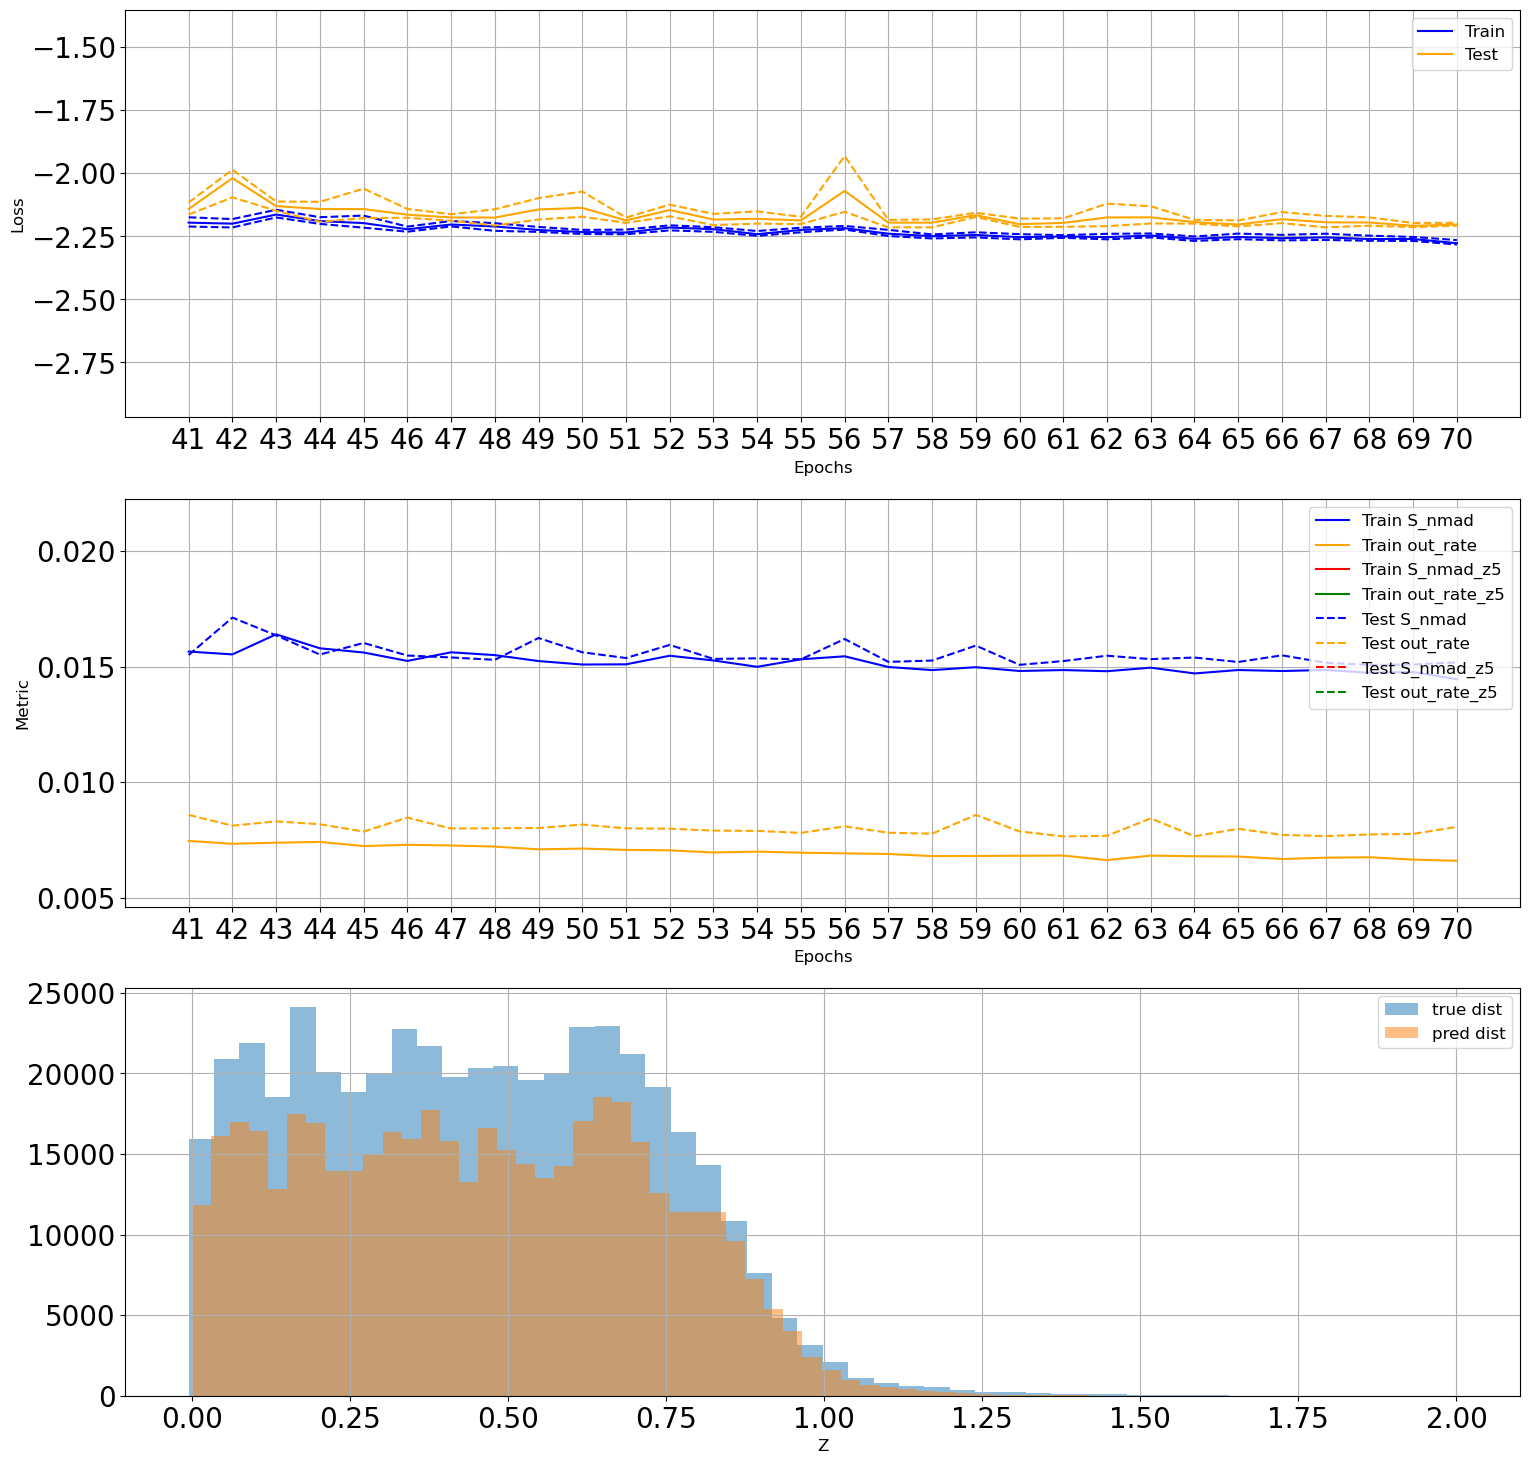

(454624, 5)
(454624, 5)
(455056, 5)
(455056, 5)


RA        DEC         Z  fold  sdssdr16_u_psf  sdssdr16_g_psf  \
0       147.112746   8.661343 -0.008533     2       20.332035       19.880827   
1       154.034947  31.446136 -0.006765     2       22.171552       22.237127   
2       158.238897   3.702761 -0.006568     2       20.727456       18.959996   
3       162.916695  40.622150 -0.005616     2       24.278957       21.703600   
4       170.203378  38.342311 -0.005398     2       24.125196       25.165712   
...            ...        ...       ...   ...             ...             ...   
909675  162.484887  27.574722  1.986977     1       20.933718       20.659149   
909676  135.911920  27.952006  1.997584     1       20.101584       19.440515   
909677    7.342117   6.372075  1.999491     2       20.911057       20.635563   
909678   24.302228  14.165467  1.999742     2       21.084990       20.475918   
909679  252.013334  52.168472  2.000773     1       19.926299       19.641693   

        sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  \
0            19.546068       19.280562       19.142054          20.300770   
1            21.971378       22.136731       22.320504          22.221776   
2            17.958539       17.506774       17.100144          19.714318   
3            21.500365       21.184229       21.804084          23.771870   
4            23.506935       22.038719       20.357227          23.979551   
...                ...             ...             ...                ...   
909675       20.431712       20.460589       20.287432          20.860960   
909676       19.046427       18.943583       18.742682          20.113609   
909677       20.403287       20.344756       20.047908          20.791228   
909678       20.430671       20.295313       19.908795          20.996013   
909679       19.451389       19.485784       19.352524          19.934861   

        ...  sample_279  sample_280  sample_281  sample_282  sample_283  \
0       ...    0.291953    0.186533    0.365282    0.326462    0.303581   
1       ...    1.142815    1.148554    1.107855    1.526290    0.495461   
2       ...    0.150710    0.149738    0.157156    0.148963    0.149084   
3       ...    0.064581    0.028440    0.063087   -0.034734    0.001696   
4       ...    0.920853    0.898845    0.958307    0.961001    0.834097   
...     ...         ...         ...         ...         ...         ...   
909675  ...    1.326726    0.568094    0.660246    0.714545    0.910947   
909676  ...    0.423688    0.409253    0.592057    0.871345    0.608521   
909677  ...    0.941234    0.903188    0.946688    0.885289    1.036539   
909678  ...    0.839532    0.886628    0.502131    0.772035    1.571428   
909679  ...    0.743893    0.614178    0.541413    0.433528    0.726214   

        sample_284  sample_285  sample_286  sample_287     zConf  
0         0.315711    0.501198    0.249910    0.289918  0.656250  
1         1.417940    0.823486    1.648893    1.121438  0.218750  
2         0.152986    0.155188    0.168179    0.156450  1.000000  
3        -0.051251    0.327587   -0.024838    0.044897  0.291667  
4         0.868338    0.921353    1.020106    0.852809  0.986111  
...            ...         ...         ...         ...       ...  
909675    1.288125    0.826205    0.651679    0.540508  0.288194  
909676    0.574173    0.722243    0.453020    0.256461  0.291667  
909677    1.061415    0.869402    0.874109    0.767795  0.381944  
909678    0.646133    0.475988    1.037893    0.313703  0.319444  
909679    2.134365    0.578857    0.100748    0.726343  0.204861  

[909680 rows x 467 columns]

In [53]:
features_no = '35'
features = features_dict[features_no]
n_gauss = 5

#===========

n_dup = 500
z_thr = 0.75
n_epoch = 70
n_models = 5

#===========

name = f'train15_{features_no}_g{n_gauss}_m{n_models}'

def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6)))# + 0.00002*np.exp((-6)*(z-1)**2) + 0.00002*np.exp((-3)*(z-2)**2)

rf_features = ['max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z',]

t_01 = train_15_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_01 = t_01[features].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_15_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features].dropna().reset_index()
X_02 = t_02[features].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

X_full = np.concatenate([X_01, X_02], axis=0)
y_full = np.concatenate([y_01, y_02], axis=0)

#===========

np.random.seed(1)
torch.manual_seed(1)

ens_full = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_full, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_full, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_full.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_full.save_pickle(f'{name}_model_full.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_01 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_01.save_pickle(f'{name}_model_01.pkl');

np.random.seed(1)
torch.manual_seed(1)

ens_02 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_02.shape[1], 400, 400, 400, 400, 400, 400, n_gauss], 'p': 0.0},
    n_models, device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=n_epoch, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_02.save_pickle(f'{name}_model_02.pkl');

#===========

ens_01 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_01.pkl')
ens_02 = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{name}_model_02.pkl')
import warnings
warnings.filterwarnings('ignore')

result_01 = ens_02.predict(X_01)
result_01 = pd.concat([t_01[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_01], axis=1)
result_02 = ens_01.predict(X_02)
result_02 = pd.concat([t_02[['RA', 'DEC', 'Z', 'fold'] + features + rf_features], result_02], axis=1)
result = pd.concat([result_01, result_02])
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

0.015192074092607297
0.007983026998504969
nan
nan
nan
nan


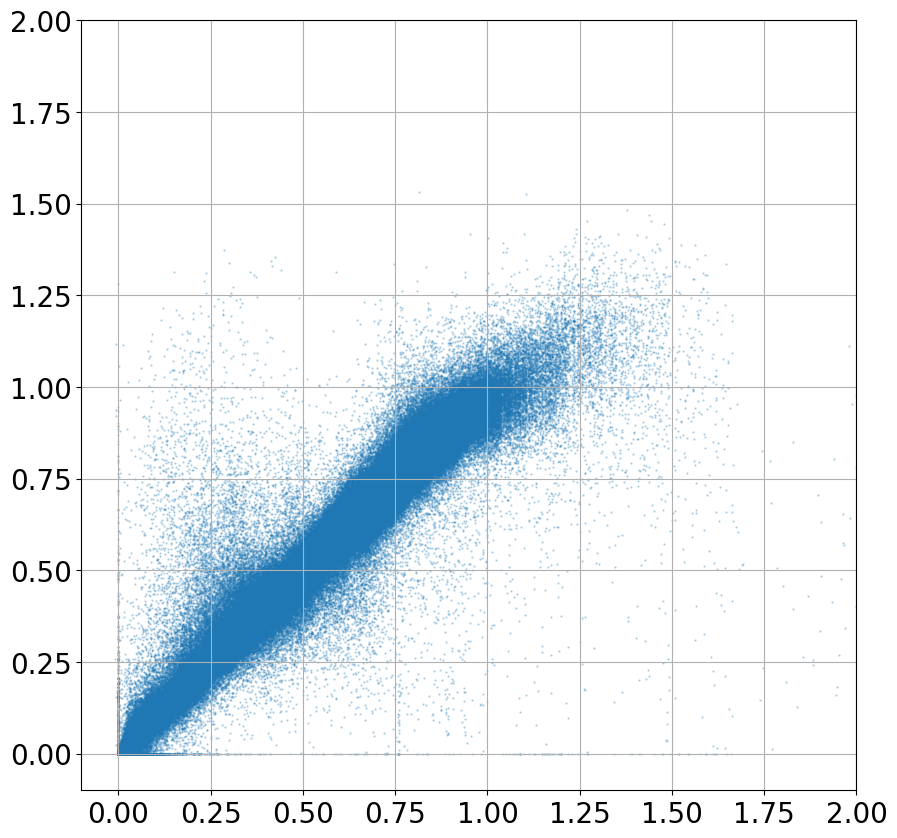

In [55]:
print(metrics.sigma_nmad(result['Z'], result['mu']))
print(metrics.out_rate(result['Z'], result['mu']))
print(metrics.sigma_nmad_z4(result['Z'], result['mu']))
print(metrics.out_rate_z4(result['Z'], result['mu']))
print(metrics.sigma_nmad_z5(result['Z'], result['mu']))
print(metrics.out_rate_z5(result['Z'], result['mu']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 2))
plt.ylim((-0.1, 2))
plt.grid()

plt.scatter(result['Z'], result['mode'], s=0.4, alpha=0.3);

In [ ]:
# HELP

In [119]:
HELP = pd.read_csv(f'data/HELP/HELP.csv')

In [120]:
HELP.shape

(903140, 85)

In [121]:
HELP

RA        DEC     Z  decals8tr_Lw1  decals8tr_Lw1-Lw2  \
0        52.818640 -27.827850 -10.0      20.744589           0.609282   
1        53.402240 -28.010960 -10.0            NaN                NaN   
2        52.986790 -28.079540 -10.0      19.988134           0.191508   
3        53.401540 -27.731630 -10.0      19.503754           0.649620   
4        52.987650 -27.852390 -10.0            NaN                NaN   
...            ...        ...   ...            ...                ...   
903135  352.932343   0.368555   NaN      20.955874           0.537060   
903136  353.155121   0.057407   NaN      23.398715           0.619936   
903137  353.155121   0.057407   NaN      21.377336          -0.483246   
903138  353.217957   0.259549   NaN      22.345617           2.005672   
903139  353.217957   0.259549   NaN      22.979015           2.873517   

        decals8tr_Lw2  decals8tr_g  decals8tr_g-Lw1  decals8tr_g-Lw2  \
0           20.135307    25.733500         4.988911         5.598193   
1                 NaN          NaN              NaN              NaN   
2           19.796626    23.254691         3.266556         3.458065   
3           18.854134    24.659128         5.155375         5.804995   
4                 NaN          NaN              NaN              NaN   
...               ...          ...              ...              ...   
903135      20.418814    23.546166         2.590292         3.127352   
903136      22.778779    25.130335         1.731620         2.351556   
903137      21.860582    21.736693         0.359357        -0.123889   
903138      20.339945    25.111384         2.765767         4.771439   
903139      20.105498    25.349448         2.370433         5.243950   

        decals8tr_g-r  ...  sdssdr16_u_cmodel-decals8tr_Lw1  \
0            0.998486  ...                              NaN   
1                 NaN  ...                              NaN   
2            0.344128  ...                              NaN   
3            0.781188  ...                              NaN   
4                 NaN  ...                              NaN   
...               ...  ...                              ...   
903135       0.088602  ...                              NaN   
903136       0.038474  ...                              NaN   
903137       0.350513  ...                        -0.213499   
903138      -0.529549  ...                              NaN   
903139       0.349860  ...                              NaN   

        sdssdr16_u_cmodel-decals8tr_Lw2  sdssdr16_u_psf  \
0                                   NaN             NaN   
1                                   NaN             NaN   
2                                   NaN             NaN   
3                                   NaN             NaN   
4                                   NaN             NaN   
...                                 ...             ...   
903135                              NaN             NaN   
903136                              NaN             NaN   
903137                        -0.696745        23.85976   
903138                              NaN             NaN   
903139                              NaN             NaN   

        sdssdr16_u_psf-cmodel  sdssdr16_z_cmodel  \
0                         NaN                NaN   
1                         NaN                NaN   
2                         NaN                NaN   
3                         NaN                NaN   
4                         NaN                NaN   
...                       ...                ...   
903135                    NaN                NaN   
903136                    NaN                NaN   
903137               2.695923          19.780746   
903138                    NaN                NaN   
903139                    NaN                NaN   

        sdssdr16_z_cmodel-decals8tr_Lw1  sdssdr16_z_cmodel-decals8tr_Lw2  \
0                                   NaN                              NaN   
1                              

In [125]:
features_no = '35'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'HELP_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = HELP[['RA', 'DEC', 'Z'] + features + rf_features][HELP[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train15_35_g5_m5_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(371153, 5)
(371153, 5)


RA       DEC    Z  sdssdr16_u_psf  sdssdr16_g_psf  \
0       150.154454  2.348744 -1.0       24.058476       22.599273   
1       150.095613  2.456468 -1.0       24.447233       23.233493   
2       150.134220  2.350518 -1.0       24.447365       24.785471   
3       150.134226  2.351670 -1.0       24.447365       24.785471   
4       150.133988  2.246208 -1.0       24.399510       24.666217   
...            ...       ...  ...             ...             ...   
371148  353.149841  0.364744  NaN       22.423002       21.635129   
371149  353.090576  0.350238  NaN       22.435795       23.474043   
371150  352.962952  0.358110  NaN       24.723564       24.013908   
371151  352.930725  0.369058  NaN       22.564361       23.228617   
371152  353.155121  0.057407  NaN       23.859760       23.512060   

        sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  \
0            21.177717       19.819618       19.042929          23.769746   
1            21.744179       21.104308       20.360911          22.747051   
2            23.769531       21.647544       20.335166          19.111601   
3            23.769531       21.647544       20.335166          19.111601   
4            23.184372       21.975695       21.729972          24.415388   
...                ...             ...             ...                ...   
371148       20.909272       20.700842       20.179351          21.950085   
371149       23.105331       22.204733       21.437680          21.010819   
371150       22.839975       22.175856       22.510283          24.727387   
371151       23.345900       22.879666       21.508656          21.479577   
371152       23.095551       22.846912       21.884364          21.163837   

        sdssdr16_i_cmodel  ...  sample_279  sample_280  sample_281  \
0               19.828002  ...    0.968623    0.224233    0.345779   
1               20.791475  ...    0.456381    0.558122    0.409533   
2               21.560713  ...    0.458923    0.411477    0.639488   
3               21.560713  ...    0.213894    0.979023    0.460926   
4               21.736960  ...    0.819951    0.743143    0.744136   
...                   ...  ...         ...         ...         ...   
371148          19.954912  ...    0.273453    0.323286    0.305568   
371149          21.632083  ...    0.803872    1.269504    0.990922   
371150          21.820323  ...    0.916897    0.993329    0.913656   
371151          21.601602  ...    1.408719    1.472655    1.317020   
371152          21.043046  ...    0.797437    0.293850    0.455613   

        sample_282  sample_283  sample_284  sample_285  sample_286  \
0         0.017675    0.629478    1.028550    0.160575    0.545154   
1         0.444693    0.432584    0.402289    0.413451    0.384158   
2         0.265421    0.590559    0.394981    0.190661    0.636882   
3        -0.385783    1.118783    1.007514    0.261476    1.168878   
4         0.932746    0.684996    0.860907    0.813070    0.709012   
...            ...         ...         ...         ...         ...   
371148    0.304263    0.302632    0.374858    0.338238    0.303753   
371149    0.971900    1.110764    0.966799    0.986573    1.271128   
371150    0.889852    0.829181    0.883097    1.205641    0.884132   
371151    1.151456    1.125041    0.585908    0.974741    1.407931   
371152    0.070108    0.421139    0.465715    0.553363    0.155025   

        sample_287     zConf  
0         0.173145  0.222222  
1         0.444618  0.972222  
2         0.580309  0.309028  
3         0.581063  0.281250  
4         0.768089  0.888889  
...            ...       ...  
371148    0.293863  0.951389  
371149    0.876769  0.506944  
371150    0.886696  0.895833  
371151    1.633734  0.579861  
371152    0.543986  0.225694  

[371153 rows x 460 columns]

nan
0.12296276737625723
0.1407448012814499
1.0
0.09125575095676174
1.0


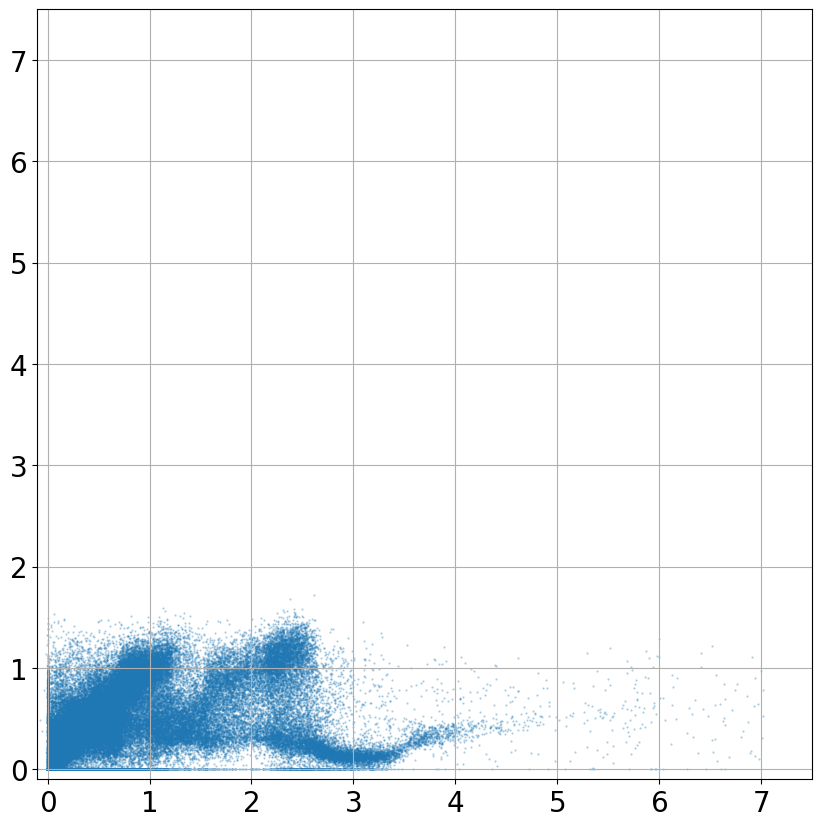

In [126]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

m = result['Z'] > -1.0

plt.scatter(result['Z'][m], result['mode'][m], s=0.4, alpha=0.3);

In [ ]:
# Yang

In [67]:
Yang = pd.read_csv(f'data/Yang/Yang.csv')

In [68]:
Yang.shape

(469, 86)

In [69]:
Yang

Name         RA       DEC     Z  decals8tr_Lw1  \
0    b'DESIJ082959.04+055636.5'  127.49599   5.94347  4.44      19.446148   
1    b'DESIJ183303.81+334325.6'  278.26590  33.72379  4.58      19.472802   
2    b'DESIJ231153.87+154621.4'  347.97446  15.77261  4.62      19.396893   
3    b'DESIJ003502.32-023153.9'    8.75967  -2.53165  4.62      19.658390   
4    b'DESIJ124651.09-003233.0'  191.71289  -0.54252  4.63      21.027895   
..                          ...        ...       ...   ...            ...   
464  b'DESIJ123026.75+412840.3'  187.61148  41.47787  6.27      19.749876   
465  b'DESIJ152556.47+385040.2'  231.48529  38.84452  6.30      19.945843   
466  b'DESIJ140258.02-062904.5'  210.74178  -6.48460  6.49      20.366914   
467  b'DESIJ011553.41+031829.3'   18.97252   3.30816  6.51      20.773995   
468  b'DESIJ144355.05+350055.6'  220.97939  35.01546  6.53      20.430065   

     decals8tr_Lw1-Lw2  decals8tr_Lw2  decals8tr_g  decals8tr_g-Lw1  \
0            -0.127283      19.573431    24.186586         4.740438   
1            -0.042668      19.515470    25.164053         5.691251   
2            -0.107049      19.503942    25.133110         5.736217   
3            -0.039468      19.697858    25.253245         5.594855   
4             0.624969      20.402926    25.027297         3.999402   
..                 ...            ...          ...              ...   
464           0.276625      19.473252    26.338971         6.589095   
465           0.188861      19.756983    26.506024         6.560181   
466           0.260013      20.106901    26.265228         5.898315   
467           0.302958      20.471037    27.585443         6.811448   
468          -0.096038      20.526103    26.728418         6.298353   

     decals8tr_g-Lw2  ...  sdssdr16_u_cmodel-decals8tr_Lw1  \
0           4.613156  ...                         5.140508   
1           5.648583  ...                              NaN   
2           5.629167  ...                        -0.344898   
3           5.555387  ...                         2.539014   
4           4.624372  ...                         2.662544   
..               ...  ...                              ...   
464         6.865719  ...                         0.685010   
465         6.749041  ...                              NaN   
466         6.158327  ...                              NaN   
467         7.114406  ...                              NaN   
468         6.202315  ...                              NaN   

     sdssdr16_u_cmodel-decals8tr_Lw2  sdssdr16_u_psf  sdssdr16_u_psf-cmodel  \
0                           5.013225       24.407279              -0.179377   
1                                NaN             NaN                    NaN   
2                          -0.451947       22.791559               3.739563   
3                           2.499546       24.126931               1.929527   
4                           3.287514       24.238276               0.547836   
..                               ...             ...                    ...   
464                         0.961635       23.944170               3.509283   
465                              NaN             NaN                    NaN   
466                              NaN             NaN                    NaN   
467                              NaN             NaN                    NaN   
468                              NaN             NaN                    NaN   

     sdssdr16_z_cmodel  sdssdr16_z_cmodel-decals8tr_Lw1  \
0            20.070670                         0.624522   
1                  NaN                              NaN   
2            20.933303                         1.536410   
3            20.574580                         0.916189   
4            20.876520                        -0.151375   
..                 ...                              ...   
464          20.773660                         1.023783   
465                NaN                              NaN   
466                NaN  

In [92]:
features_no = '18'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Yang_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Yang[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Yang[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(293, 5)
(293, 5)


Name         RA       DEC     Z  sdssdr16_u_psf  \
0    b'DESIJ082959.04+055636.5'  127.49599   5.94347  4.44       24.407279   
1    b'DESIJ231153.87+154621.4'  347.97446  15.77261  4.62       22.791559   
2    b'DESIJ003502.32-023153.9'    8.75967  -2.53165  4.62       24.126931   
3    b'DESIJ124651.09-003233.0'  191.71289  -0.54252  4.63       24.238276   
4    b'DESIJ235839.43+124708.8'  359.66428  12.78578  4.64       24.858670   
..                          ...        ...       ...   ...             ...   
288  b'DESIJ085116.20+300936.6'  132.81749  30.16019  5.93       23.964019   
289  b'DESIJ090744.63+113832.8'  136.93596  11.64244  6.04       23.835161   
290  b'DESIJ160213.88+350330.9'  240.55782  35.05859  6.11       24.526340   
291  b'DESIJ155635.50+334142.4'  239.14793  33.69514  6.13       24.694725   
292  b'DESIJ123026.75+412840.3'  187.61148  41.47787  6.27       23.944170   

     sdssdr16_g_psf  sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  \
0         24.084516       21.586386       20.625915       20.115015   
1         25.698144       22.993547       21.149028       21.016228   
2         25.159381       22.708010       20.881825       20.569913   
3         23.651599       22.894261       21.504046       20.994966   
4         25.301309       22.617350       21.209738       20.513475   
..              ...             ...             ...             ...   
288       26.216067       24.130248       23.898465       20.817473   
289       25.223724       24.363951       23.931813       20.830249   
290       25.515852       24.047575       24.075182       20.742978   
291       25.127186       23.903476       22.529778       20.848898   
292       25.526943       24.688107       22.876035       20.753449   

     sdssdr16_u_cmodel  ...  sample_279  sample_280  sample_281  sample_282  \
0            24.586656  ...    4.543708    4.612795    4.447890    4.588406   
1            19.051996  ...    4.760203    5.010748    4.764011    4.807077   
2            22.197404  ...    5.008846    4.931426    4.911807    4.937684   
3            23.690440  ...    1.806623    1.966699    1.834497    1.696709   
4            24.857186  ...    5.247058    5.365233    5.154972    5.171708   
..                 ...  ...         ...         ...         ...         ...   
288          24.053992  ...    6.067427    5.921230    6.023873    6.050618   
289          21.379726  ...    5.799073    5.839427    5.853014    5.859023   
290          24.728577  ...    6.129926    5.963783    6.090331    6.101285   
291          24.884739  ...    4.729178    1.052902    1.149800    5.786146   
292          20.434887  ...    5.911746    5.977097    6.008696    5.900496   

     sample_283  sample_284  sample_285  sample_286  sample_287     zConf  
0      4.439368    4.465005    4.443781    4.542044    4.530884  1.000000  
1      4.792602    4.915733    4.833597    4.600265    4.753267  0.986111  
2      4.950004    4.926276    5.040633    4.912888    4.996748  1.000000  
3      2.407147    2.518733    1.312334    1.437488    3.006943  0.208333  
4      5.154368    5.348454    5.204289    5.130842    5.217687  0.996528  
..          ...         ...         ...         ...         ...       ...  
288    5.997713    6.015169    6.037088    6.007621    6.001861  1.000000  
289    5.860619    5.883006    5.863761    5.979402    5.959082  0.940972  
290    6.156932    6.165819    5.980713    5.937944    6.088273  0.975694  
291    6.998059    5.716232    3.129548    7.400493    6.694528  0.375000  
292    5.896717    5.788589    5.911187    5.875294    6.022128  0.989583  

[293 rows x 434 columns]

0.03891709679051444
0.07849829351535836
0.03891709679051444
0.07849829351535836
0.03013673511668813
0.047619047619047616


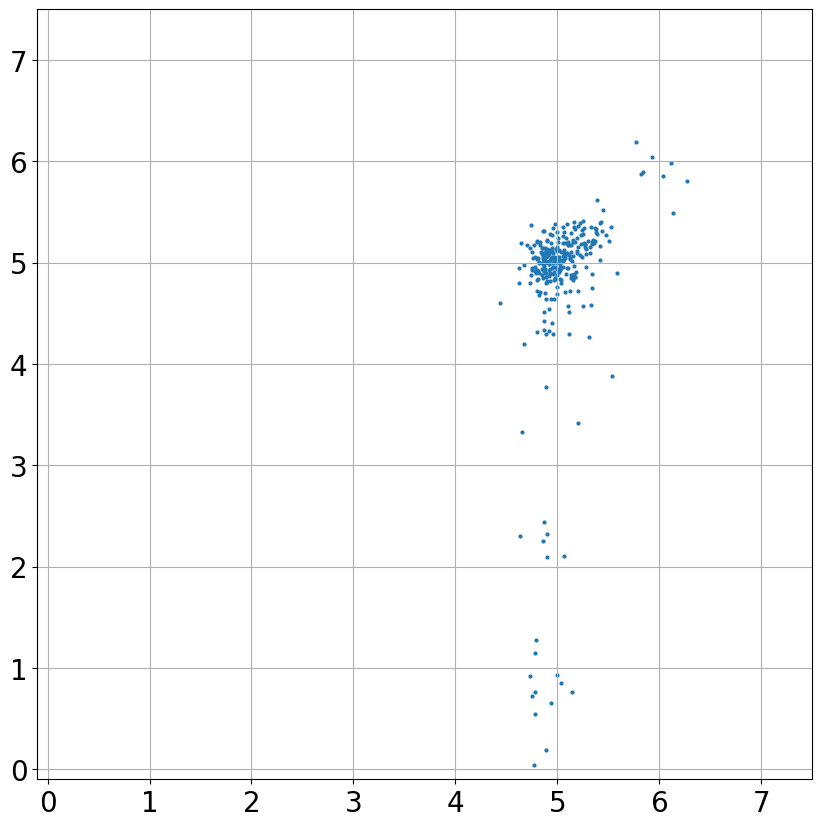

In [93]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [94]:
features_no = '20'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Yang_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Yang[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Yang[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(293, 5)
(293, 5)


Name         RA       DEC     Z  sdssdr16_u_psf  \
0    b'DESIJ082959.04+055636.5'  127.49599   5.94347  4.44       24.407279   
1    b'DESIJ231153.87+154621.4'  347.97446  15.77261  4.62       22.791559   
2    b'DESIJ003502.32-023153.9'    8.75967  -2.53165  4.62       24.126931   
3    b'DESIJ124651.09-003233.0'  191.71289  -0.54252  4.63       24.238276   
4    b'DESIJ235839.43+124708.8'  359.66428  12.78578  4.64       24.858670   
..                          ...        ...       ...   ...             ...   
288  b'DESIJ085116.20+300936.6'  132.81749  30.16019  5.93       23.964019   
289  b'DESIJ090744.63+113832.8'  136.93596  11.64244  6.04       23.835161   
290  b'DESIJ160213.88+350330.9'  240.55782  35.05859  6.11       24.526340   
291  b'DESIJ155635.50+334142.4'  239.14793  33.69514  6.13       24.694725   
292  b'DESIJ123026.75+412840.3'  187.61148  41.47787  6.27       23.944170   

     sdssdr16_g_psf  sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  \
0         24.084516       21.586386       20.625915       20.115015   
1         25.698144       22.993547       21.149028       21.016228   
2         25.159381       22.708010       20.881825       20.569913   
3         23.651599       22.894261       21.504046       20.994966   
4         25.301309       22.617350       21.209738       20.513475   
..              ...             ...             ...             ...   
288       26.216067       24.130248       23.898465       20.817473   
289       25.223724       24.363951       23.931813       20.830249   
290       25.515852       24.047575       24.075182       20.742978   
291       25.127186       23.903476       22.529778       20.848898   
292       25.526943       24.688107       22.876035       20.753449   

     sdssdr16_u_cmodel  ...  sample_279  sample_280  sample_281  sample_282  \
0            24.586656  ...    4.388419    4.312814    4.432364    4.444708   
1            19.051996  ...    4.727817    4.864897    4.765128    4.891122   
2            22.197404  ...    4.737066    4.780497    4.750002    4.759467   
3            23.690440  ...    4.928566    4.874712    4.820686    4.795366   
4            24.857186  ...    5.038195    5.154752    5.123942    5.113966   
..                 ...  ...         ...         ...         ...         ...   
288          24.053992  ...    5.868252    6.135184    6.073748    5.987441   
289          21.379726  ...    6.099014    6.088169    6.060219    6.089487   
290          24.728577  ...    5.877739    5.863308    5.806176    5.895076   
291          24.884739  ...    1.038999    1.138722    1.150025    1.830979   
292          20.434887  ...    6.257985    6.053564    6.321621    6.071366   

     sample_283  sample_284  sample_285  sample_286  sample_287     zConf  
0      4.514921    4.519644    4.296048    4.410684    4.288542  0.993056  
1      4.761040    4.828341    4.948776    4.733156    4.713458  0.986111  
2      4.748498    4.755486    4.744031    4.714376    4.691069  1.000000  
3      4.787512    4.547204    4.898363    4.774300    4.919933  0.993056  
4      5.047666    5.041607    5.034785    5.120709    5.084175  1.000000  
..          ...         ...         ...         ...         ...       ...  
288    5.989599    6.116401    5.861722    6.005707    6.052985  1.000000  
289    6.034914    6.003372    6.100871    6.077180    6.121361  0.993056  
290    5.897208    5.883608    5.879203    5.898762    5.842865  1.000000  
291    0.963238    0.873139    0.969634    0.945327    4.953839  0.517361  
292    6.243069    5.993420    6.274705    6.327986    6.203264  0.989583  

[293 rows x 435 columns]

0.02576549802507665
0.04436860068259386
0.02576549802507665
0.04436860068259386
0.023759059593325586
0.027210884353741496


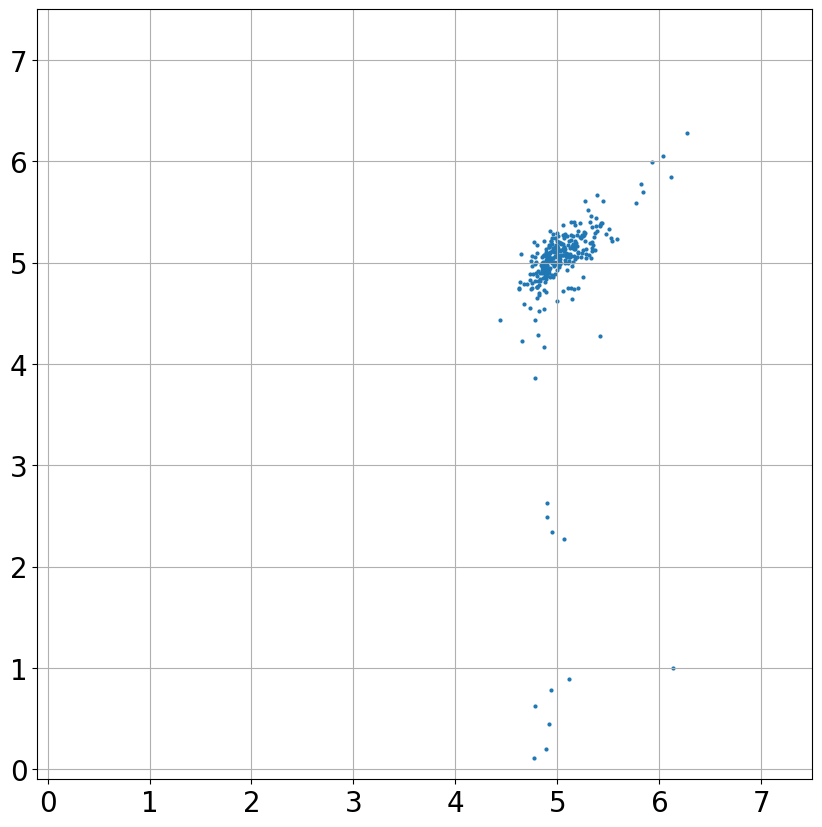

In [95]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [96]:
features_no = '21'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Yang_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Yang[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Yang[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(357, 5)
(357, 5)


Name         RA       DEC     Z  psdr2_i_kron  \
0    b'DESIJ082959.04+055636.5'  127.49599   5.94347  4.44     20.531653   
1    b'DESIJ183303.81+334325.6'  278.26590  33.72379  4.58     21.460470   
2    b'DESIJ231153.87+154621.4'  347.97446  15.77261  4.62     21.060861   
3    b'DESIJ003502.32-023153.9'    8.75967  -2.53165  4.62     21.254801   
4    b'DESIJ124651.09-003233.0'  191.71289  -0.54252  4.63     21.761352   
..                          ...        ...       ...   ...           ...   
352  b'DESIJ085548.47+073638.3'  133.95195   7.61066  6.23     24.358860   
353  b'DESIJ012235.47-003602.4'   20.64778  -0.60069  6.26     24.402408   
354  b'DESIJ123026.75+412840.3'  187.61148  41.47787  6.27     23.319368   
355  b'DESIJ140258.02-062904.5'  210.74178  -6.48460  6.49     25.466322   
356  b'DESIJ011553.41+031829.3'   18.97252   3.30816  6.51     24.367081   

     psdr2_y_kron  psdr2_g_psf  psdr2_r_psf  psdr2_i_psf  psdr2_z_psf  ...  \
0       19.973038    23.739606    21.221943    20.370706    20.183430  ...   
1       20.783493    24.929485    22.590046    21.275357    21.075449  ...   
2       20.363115    25.408931    22.708872    21.029818    20.963221  ...   
3       20.870182    25.544484    22.567709    20.989692    20.864817  ...   
4       21.338386    24.312910    22.794855    21.477692    21.361234  ...   
..            ...          ...          ...          ...          ...  ...   
352     20.879565    24.777170    25.164760    24.358860    21.233714  ...   
353     21.868635    25.586190    25.734100    24.402408    21.711844  ...   
354     20.573309    26.699077    25.850469    23.319368    21.364053  ...   
355     20.984259    25.475740    23.115717    25.466322    22.311354  ...   
356     21.207667    25.974837    24.535756    24.367081    21.652675  ...   

     sample_279  sample_280  sample_281  sample_282  sample_283  sample_284  \
0      4.542645    4.307265    4.279455    4.314095    4.292285    4.274596   
1      4.465695    4.472961    4.425101    4.530819    4.357806    4.561777   
2      4.798442    4.760833    4.863767    4.591875    4.780862    4.825878   
3      4.833836    4.756869    4.822440    4.799682    4.863370    4.825999   
4      4.768461    0.470735    4.726279    0.629413    4.773161    4.640318   
..          ...         ...         ...         ...         ...         ...   
352    5.962206    5.992223    6.016139    6.022853    6.000517    5.952935   
353    5.607447    5.815170    5.658537    5.739408    5.587972    5.632954   
354    6.222878    6.376062    6.237719    6.151145    6.289271    6.265181   
355    6.287268    5.970437    3.509693    5.448574    7.590043    6.477318   
356    6.915517    6.603690    6.366635    6.635945    6.285759    6.412615   

     sample_285  sample_286  sample_287     zConf  
0      4.272163    4.574049    4.247868  0.788194  
1      4.538798    4.437247    4.399224  0.972222  
2      4.849254    4.806726    4.567639  0.993056  
3      4.825358    4.833602    4.764150  0.993056  
4      4.680215    0.424441    4.742580  0.815972  
..          ...         ...         ...       ...  
352    6.011949    6.024890    6.049990  0.996528  
353    5.882165    5.762573    5.843008  1.000000  
354    6.248290    6.135073    6.291428  1.000000  
355    6.621043    6.480968    5.526960  0.468750  
356    6.617253    6.279430    6.478556  0.975694  

[357 rows x 434 columns]

0.02349162578582753
0.03361344537815126
0.02349162578582753
0.03361344537815126
0.019320321478670785
0.02717391304347826


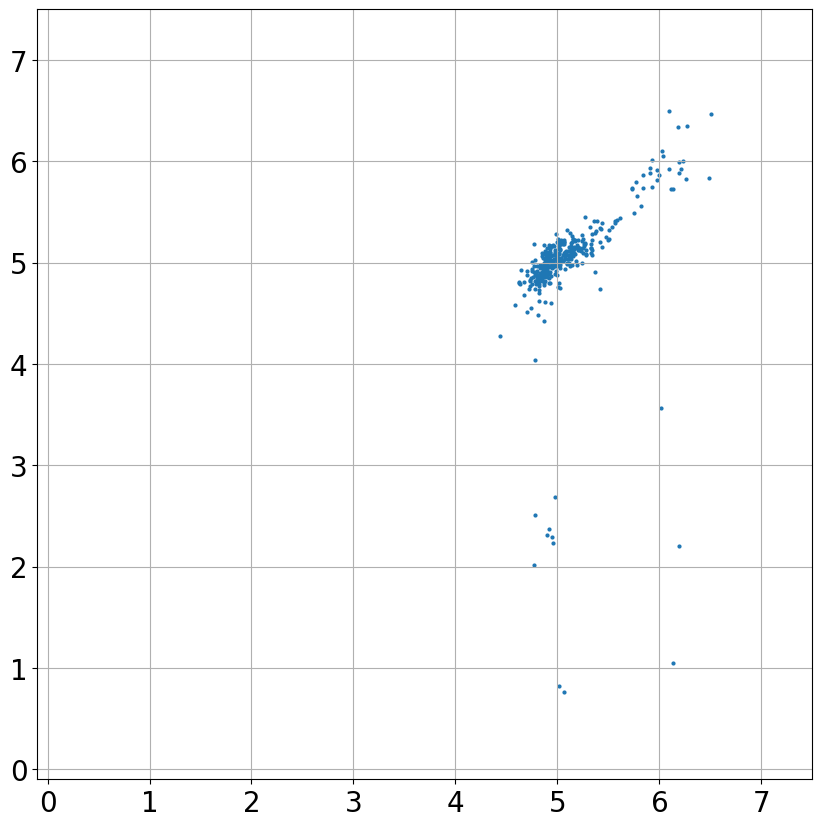

In [97]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [98]:
features_no = '22'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Yang_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Yang[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Yang[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(469, 5)
(469, 5)


Name         RA       DEC     Z  decals8tr_Lw1-Lw2  \
0    b'DESIJ082959.04+055636.5'  127.49599   5.94347  4.44          -0.127283   
1    b'DESIJ183303.81+334325.6'  278.26590  33.72379  4.58          -0.042668   
2    b'DESIJ231153.87+154621.4'  347.97446  15.77261  4.62          -0.107049   
3    b'DESIJ003502.32-023153.9'    8.75967  -2.53165  4.62          -0.039468   
4    b'DESIJ124651.09-003233.0'  191.71289  -0.54252  4.63           0.624969   
..                          ...        ...       ...   ...                ...   
464  b'DESIJ123026.75+412840.3'  187.61148  41.47787  6.27           0.276625   
465  b'DESIJ152556.47+385040.2'  231.48529  38.84452  6.30           0.188861   
466  b'DESIJ140258.02-062904.5'  210.74178  -6.48460  6.49           0.260013   
467  b'DESIJ011553.41+031829.3'   18.97252   3.30816  6.51           0.302958   
468  b'DESIJ144355.05+350055.6'  220.97939  35.01546  6.53          -0.096038   

     decals8tr_Lw1  decals8tr_Lw2  decals8tr_g  decals8tr_r  decals8tr_z  ...  \
0        19.446148      19.573431    24.186586    21.514238    20.303849  ...   
1        19.472802      19.515470    25.164053    22.302753    21.011646  ...   
2        19.396893      19.503942    25.133110    22.292672    20.684124  ...   
3        19.658390      19.697858    25.253245    22.131918    20.937046  ...   
4        21.027895      20.402926    25.027297    22.392063    21.341530  ...   
..             ...            ...          ...          ...          ...  ...   
464      19.749876      19.473252    26.338971    25.824017    20.561616  ...   
465      19.945843      19.756983    26.506024    25.022752    20.486791  ...   
466      20.366914      20.106901    26.265228    26.476545    21.462288  ...   
467      20.773995      20.471037    27.585443    26.972022    20.798377  ...   
468      20.430065      20.526103    26.728418    25.181237    21.215075  ...   

     sample_279  sample_280  sample_281  sample_282  sample_283  sample_284  \
0      4.687052    4.590094    4.664092    4.569367    4.718446    4.598748   
1      4.172109    4.359209    4.408222    4.327831    4.072576    0.630047   
2      4.322215    4.322437    4.468713    4.422315    4.397645    4.293601   
3      4.572785    4.553823    4.819515    4.519732    4.811299    4.733641   
4      2.321897    4.666059    4.730171    4.684515    4.655581    4.687654   
..          ...         ...         ...         ...         ...         ...   
464    6.292935    6.214169    6.237192    6.190839    6.293499    6.213039   
465    6.145660    5.999867    6.018906    6.004908    5.953211    6.074787   
466    5.099585    5.570650    6.057742    6.081683    6.922989    5.623511   
467    6.391847    6.245785    6.285373    6.354283    6.228167    6.121794   
468    5.893747    5.885420    5.945919    5.833521    5.821762    5.895835   

     sample_285  sample_286  sample_287     zConf  
0      4.659721    4.719937    4.684865  1.000000  
1      4.175460    4.228990    4.350342  0.913194  
2      4.331140    4.343092    4.438882  0.892361  
3      4.496582    4.845031    4.515473  0.968750  
4      4.735839    4.621994    5.064808  0.906250  
..          ...         ...         ...       ...  
464    6.244539    6.236908    6.168898  0.934028  
465    6.013763    6.082168    6.088308  1.000000  
466    5.974763    5.979254    6.032299  0.725694  
467    6.244671    6.190691    6.508566  0.940972  
468    5.768967    5.887059    5.898879  1.000000  

[469 rows x 411 columns]

0.024700294157486986
0.1257995735607676
0.024700294157486986
0.1257995735607676
0.02769472799597723
0.13043478260869565


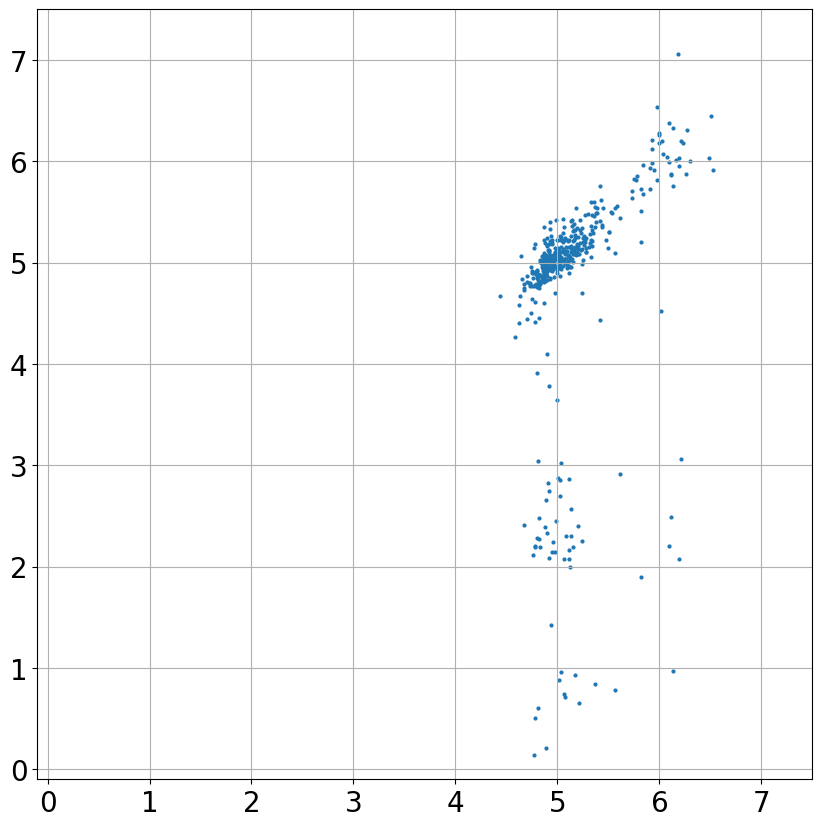

In [99]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [100]:
features_no = '35'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Yang_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Yang[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Yang[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(239, 5)
(239, 5)


Name         RA       DEC     Z  sdssdr16_u_psf  \
0    b'DESIJ082959.04+055636.5'  127.49599   5.94347  4.44       24.407279   
1    b'DESIJ231153.87+154621.4'  347.97446  15.77261  4.62       22.791559   
2    b'DESIJ003502.32-023153.9'    8.75967  -2.53165  4.62       24.126931   
3    b'DESIJ124651.09-003233.0'  191.71289  -0.54252  4.63       24.238276   
4    b'DESIJ235839.43+124708.8'  359.66428  12.78578  4.64       24.858670   
..                          ...        ...       ...   ...             ...   
234  b'DESIJ175622.57+634839.5'  269.09406  63.81097  5.84       23.609363   
235  b'DESIJ090744.63+113832.8'  136.93596  11.64244  6.04       23.835161   
236  b'DESIJ160213.88+350330.9'  240.55782  35.05859  6.11       24.526340   
237  b'DESIJ155635.50+334142.4'  239.14793  33.69514  6.13       24.694725   
238  b'DESIJ123026.75+412840.3'  187.61148  41.47787  6.27       23.944170   

     sdssdr16_g_psf  sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  \
0         24.084516       21.586386       20.625915       20.115015   
1         25.698144       22.993547       21.149028       21.016228   
2         25.159381       22.708010       20.881825       20.569913   
3         23.651599       22.894261       21.504046       20.994966   
4         25.301309       22.617350       21.209738       20.513475   
..              ...             ...             ...             ...   
234       24.651970       24.589734       22.858399       20.535007   
235       25.223724       24.363951       23.931813       20.830249   
236       25.515852       24.047575       24.075182       20.742978   
237       25.127186       23.903476       22.529778       20.848898   
238       25.526943       24.688107       22.876035       20.753449   

     sdssdr16_u_cmodel  ...  sample_279  sample_280  sample_281  sample_282  \
0            24.586656  ...    4.335203    4.506282    4.451002    4.355811   
1            19.051996  ...    4.586233    4.530465    4.709034    4.640121   
2            22.197404  ...    4.872208    4.755229    4.793474    4.766744   
3            23.690440  ...    4.669787    4.698560    4.716886    4.737396   
4            24.857186  ...    5.031958    5.009794    5.023188    5.054224   
..                 ...  ...         ...         ...         ...         ...   
234          21.990836  ...    5.843428    5.721219    5.820014    5.857222   
235          21.379726  ...    5.990845    5.958844    5.998706    5.960240   
236          24.728577  ...    5.960494    5.709754    5.682624    5.870648   
237          24.884739  ...    0.997989    3.559368    1.118243    1.060869   
238          20.434887  ...    6.145769    6.149480    6.076479    6.114119   

     sample_283  sample_284  sample_285  sample_286  sample_287     zConf  
0      4.380422    4.439661    4.337498    4.489862    4.534757  0.996528  
1      4.886208    4.569686    4.538221    4.656415    4.790886  0.954861  
2      4.850678    4.733478    4.855893    4.868925    4.827729  1.000000  
3      4.684015    4.606446    4.421329    4.458988    4.548272  0.996528  
4      5.032691    5.032777    5.043238    5.032365    5.045616  0.996528  
..          ...         ...         ...         ...         ...       ...  
234    5.849934    5.807045    5.772019    5.842166    5.871596  0.996528  
235    5.962979    5.969435    5.981874    5.988270    5.983710  1.000000  
236    5.949697    5.905447    5.781558    5.779022    5.903462  1.000000  
237    3.725504    1.052738    0.904763    0.794481    0.949574  0.687500  
238    6.133377    6.068945    6.069601    6.124055    6.127096  1.000000  

[239 rows x 461 columns]

0.022624353503690228
0.029288702928870293
0.022624353503690228
0.029288702928870293
0.019061672968702845
0.025210084033613446


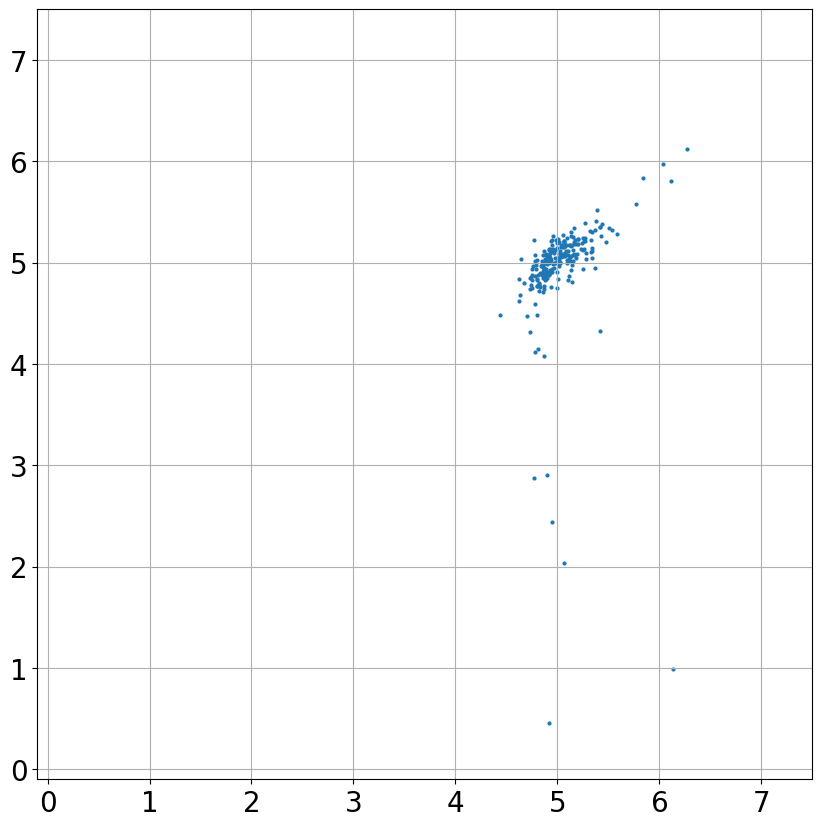

In [101]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [102]:
# Bandos

In [106]:
Bandos = pd.read_csv(f'data/Bandos/Bandos.csv')

In [107]:
Bandos.shape

(63, 86)

In [108]:
Bandos

Name          RA        DEC       Z  decals8tr_Lw1  \
0      b'P224+10'  224.650667  10.213797  5.6000      18.806676   
1      b'P142-11'  142.399042 -11.360442  5.6100      20.010596   
2      b'P002+03'    2.542917   3.063214  5.6400      18.950366   
3      b'P002+03'    2.542917   3.063214  5.6400      21.963583   
4      b'P197+45'  197.867500  45.804081  5.6600      19.940163   
..            ...         ...        ...     ...            ...   
58     b'P173+48'  173.460167  48.242003  6.2330      21.032978   
59     b'P215+26'  215.430375  26.532539  6.2800      20.059899   
60  b'J2211-3206'  332.801625 -32.103597  6.3394            NaN   
61  b'J1152+0055'  178.088625   0.926858  6.3643      20.768353   
62     b'P170+20'  170.832667  20.208275  6.4100      20.304841   

    decals8tr_Lw1-Lw2  decals8tr_Lw2  decals8tr_g  decals8tr_g-Lw1  \
0            0.039270      18.767405    26.190552         7.383876   
1           -0.017366      20.027961          NaN              NaN   
2            0.306938      18.643428    27.384824         8.434458   
3            1.448113      20.515470    24.696108         2.732526   
4           -0.466814      20.406977    25.568898         5.628735   
..                ...            ...          ...              ...   
58           0.432723      20.600255    26.495607         5.462629   
59           0.203993      19.855906    27.305794         7.245895   
60                NaN            NaN          NaN              NaN   
61           0.547337      20.221016    26.861107         6.092753   
62          -0.526859      20.831700    25.076541         4.771700   

    decals8tr_g-Lw2  ...  sdssdr16_u_cmodel-decals8tr_Lw1  \
0          7.423147  ...                         5.070272   
1               NaN  ...                              NaN   
2          8.741395  ...                         5.949346   
3          4.180639  ...                              NaN   
4          5.161921  ...                         1.015272   
..              ...  ...                              ...   
58         5.895352  ...                              NaN   
59         7.449888  ...                              NaN   
60              NaN  ...                              NaN   
61         6.640090  ...                              NaN   
62         4.244841  ...                         3.236580   

    sdssdr16_u_cmodel-decals8tr_Lw2  sdssdr16_u_psf  sdssdr16_u_psf-cmodel  \
0                          5.109542       24.489740               0.612793   
1                               NaN             NaN                    NaN   
2                          6.256284       24.558323              -0.341389   
3                               NaN             NaN                    NaN   
4                          0.548458       24.104864               3.149428   
..                              ...             ...                    ...   
58                              NaN             NaN                    NaN   
59                              NaN             NaN                    NaN   
60                              NaN             NaN                    NaN   
61                              NaN             NaN                    NaN   
62                         2.709721       23.352230              -0.189191   

    sdssdr16_z_cmodel  sdssdr16_z_cmodel-decals8tr_Lw1  \
0           20.165707                         1.359032   
1                 NaN                              NaN   
2           20.144316                         1.193950   
3                 NaN                              NaN   
4           20.795773                         0.855609   
..                ...                              ...   
58                NaN                              NaN   
59                NaN                              NaN   
60                NaN                              NaN   
61                NaN                              NaN   
62          20.181978                        -0.122863   



In [109]:
features_no = '18'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Bandos_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Bandos[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Bandos[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(16, 5)
(16, 5)


Name          RA        DEC     Z  sdssdr16_u_psf  sdssdr16_g_psf  \
0   b'P224+10'  224.650667  10.213797  5.60       24.489740       24.533139   
1   b'P002+03'    2.542917   3.063214  5.64       24.558323       26.133148   
2   b'P197+45'  197.867500  45.804081  5.66       24.104864       25.654814   
3   b'P197+45'  197.867500  45.804081  5.66       23.775026       24.712160   
4   b'P178+28'  178.373333  28.507531  5.68       23.524440       24.620437   
5   b'P196+15'  196.347625  15.389911  5.69       23.806645       24.226026   
6   b'P169+58'  169.140667  58.889497  5.73       24.428553       25.697260   
7   b'P156+38'  156.446625  38.957306  5.75       23.769450       25.652387   
8   b'P000-04'    0.041625  -4.273903  5.77       24.296314       24.699663   
9   b'P173-06'  173.319917  -6.945792  5.77       23.757557       25.129225   
10  b'P175+71'  175.429458  71.323619  5.86       23.872797       23.995796   
11  b'P008+10'    8.608333  10.851861  5.98       23.738679       24.243310   
12  b'P182+53'  182.312208  53.463347  5.99       24.971952       25.121010   
13  b'P218+04'  218.771458   4.818978  6.14       24.601274       24.864136   
14  b'P127+26'  127.055875  26.565414  6.14       23.930227       24.745570   
15  b'P170+20'  170.832667  20.208275  6.41       23.352230       23.937334   

    sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  ...  \
0        23.965027       22.085891       20.171990          23.876947  ...   
1        24.625209       23.314756       20.528049          24.899712  ...   
2        24.638524       23.786622       21.123026          20.955435  ...   
3        23.792998       22.440286       21.597111          22.598042  ...   
4        23.612532       22.087051       20.054246          23.722193  ...   
5        24.595661       23.481723       20.536767          20.921306  ...   
6        24.143593       22.270687       20.404945          24.608016  ...   
7        23.857617       22.137698       20.056790          21.802641  ...   
8        24.547295       24.163589       20.839449          21.277234  ...   
9        24.510366       23.051938       20.717359          23.122013  ...   
10       24.418122       22.970835       20.460364          23.723186  ...   
11       25.242199       23.163334       20.418486          23.813880  ...   
12       23.866735       23.231901       20.540164          24.857896  ...   
13       23.476958       23.673406       20.642980          22.960474  ...   
14       23.956804       23.004215       20.710638          22.103507  ...   
15       23.104182       21.420508       20.431502          23.541421  ...   

    sample_279  sample_280  sample_281  sample_282  sample_283  sample_284  \
0     5.790934    5.881398    5.820861    5.796987    5.762661    5.794201   
1     6.284396    6.125717    6.195226    6.153761    6.354307    6.201006   
2     5.786410    0.727458    5.905322    5.917669    4.898857    1.844828   
3     2.425848    2.658141    3.321069    4.021697    3.904397    2.445477   
4     5.756321    5.772041    5.851365    5.850319    5.763955    5.704246   
5     6.085271    5.919527    5.023919    6.027134    4.773989    6.222708   
6     5.758023    5.774266    5.814925    5.725124    5.792575    5.766672   
7     5.863139    5.900522    5.813942    5.905928    5.974638    5.776524   
8     6.024470    5.980401    5.978098    5.941327    5.754678    5.911483   
9     6.074596    6.010097    6.036906    6.070097    6.058531    5.998670   
10    5.849914    5.718288    5.793367    5.889924    5.871206    5.877150   
11    5.784177    5.976271    5.770989    5.738030    5.935653    5.873876   
12    5.857402    5.865315    5.979376    5.723460    5.875877    5.899874   
13    5.331050    5.299859    5.607917    5.764377    5.359484    5.792312   
14    5.706695    5.711454    5.653791    5.440526    5.458082    5.730670   
15    2.715298    0.665243    1.775631    0.881941    2.515513    1.757306   

    sample_2

0.033069512903732855
0.125
0.033069512903732855
0.125
0.033069512903732855
0.125


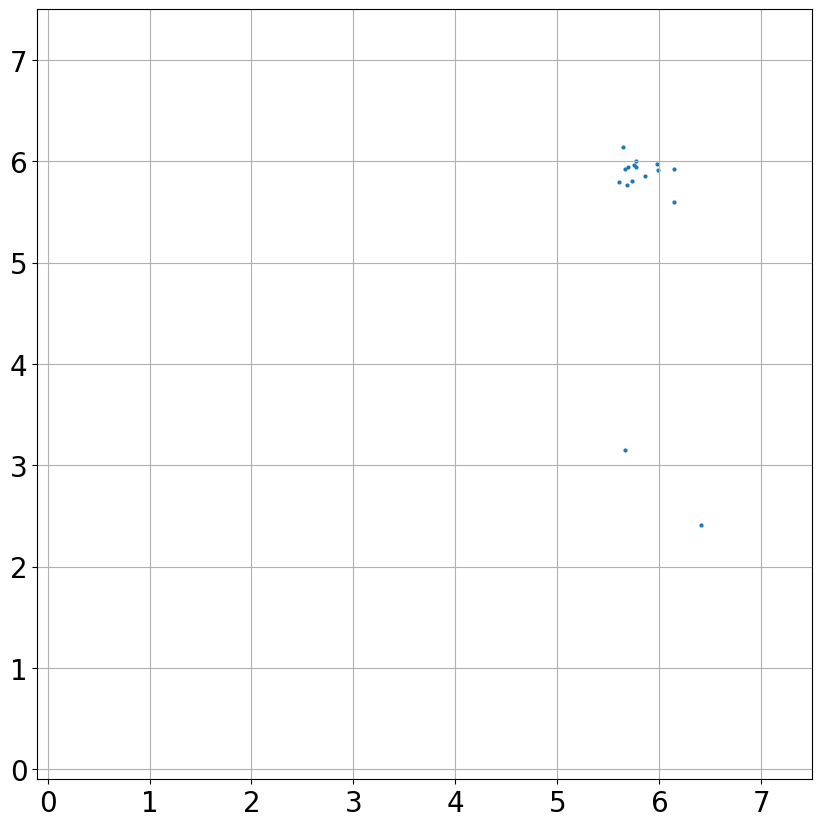

In [110]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [111]:
features_no = '20'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Bandos_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Bandos[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Bandos[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(16, 5)
(16, 5)


Name          RA        DEC     Z  sdssdr16_u_psf  sdssdr16_g_psf  \
0   b'P224+10'  224.650667  10.213797  5.60       24.489740       24.533139   
1   b'P002+03'    2.542917   3.063214  5.64       24.558323       26.133148   
2   b'P197+45'  197.867500  45.804081  5.66       24.104864       25.654814   
3   b'P197+45'  197.867500  45.804081  5.66       23.775026       24.712160   
4   b'P178+28'  178.373333  28.507531  5.68       23.524440       24.620437   
5   b'P196+15'  196.347625  15.389911  5.69       23.806645       24.226026   
6   b'P169+58'  169.140667  58.889497  5.73       24.428553       25.697260   
7   b'P156+38'  156.446625  38.957306  5.75       23.769450       25.652387   
8   b'P000-04'    0.041625  -4.273903  5.77       24.296314       24.699663   
9   b'P173-06'  173.319917  -6.945792  5.77       23.757557       25.129225   
10  b'P175+71'  175.429458  71.323619  5.86       23.872797       23.995796   
11  b'P008+10'    8.608333  10.851861  5.98       23.738679       24.243310   
12  b'P182+53'  182.312208  53.463347  5.99       24.971952       25.121010   
13  b'P218+04'  218.771458   4.818978  6.14       24.601274       24.864136   
14  b'P127+26'  127.055875  26.565414  6.14       23.930227       24.745570   
15  b'P170+20'  170.832667  20.208275  6.41       23.352230       23.937334   

    sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  ...  \
0        23.965027       22.085891       20.171990          23.876947  ...   
1        24.625209       23.314756       20.528049          24.899712  ...   
2        24.638524       23.786622       21.123026          20.955435  ...   
3        23.792998       22.440286       21.597111          22.598042  ...   
4        23.612532       22.087051       20.054246          23.722193  ...   
5        24.595661       23.481723       20.536767          20.921306  ...   
6        24.143593       22.270687       20.404945          24.608016  ...   
7        23.857617       22.137698       20.056790          21.802641  ...   
8        24.547295       24.163589       20.839449          21.277234  ...   
9        24.510366       23.051938       20.717359          23.122013  ...   
10       24.418122       22.970835       20.460364          23.723186  ...   
11       25.242199       23.163334       20.418486          23.813880  ...   
12       23.866735       23.231901       20.540164          24.857896  ...   
13       23.476958       23.673406       20.642980          22.960474  ...   
14       23.956804       23.004215       20.710638          22.103507  ...   
15       23.104182       21.420508       20.431502          23.541421  ...   

    sample_279  sample_280  sample_281  sample_282  sample_283  sample_284  \
0     5.771711    5.863710    5.784668    5.781000    5.841858    5.802991   
1     5.832612    5.726156    5.822559    5.825661    5.866892    5.843089   
2     5.853242    5.920049    5.917242    5.800605    6.004449    5.823602   
3     3.921868    3.390929    3.055822    3.601301    3.758026    3.677797   
4     5.822136    5.820385    5.867340    5.820442    5.855209    5.874801   
5     5.831057    5.867688    5.744558    5.687502    5.773736    5.789222   
6     5.830572    5.780270    5.841491    5.774554    5.814124    5.800903   
7     5.648911    5.757680    5.786290    5.702848    5.694184    0.957939   
8     5.749794    5.475855    5.349191    5.872349    5.076277    4.944889   
9     5.973953    6.032656    5.906194    5.968503    6.008895    6.088654   
10    5.822369    5.794313    5.805469    5.834120    5.799902    5.880598   
11    5.953696    5.930016    5.932078    5.988112    5.953917    5.992547   
12    6.008459    5.699526    5.660494    5.838006    5.925520    5.954898   
13    5.743095    5.258262    4.849853    5.423407    5.000602    5.533147   
14    5.830081    6.877130    6.612504    5.387611    5.880063    6.363539   
15    2.066400    3.233325    3.545529    4.511920    3.486452    4.572439   

    sample_2

0.036619586548758784
0.125
0.036619586548758784
0.125
0.036619586548758784
0.125


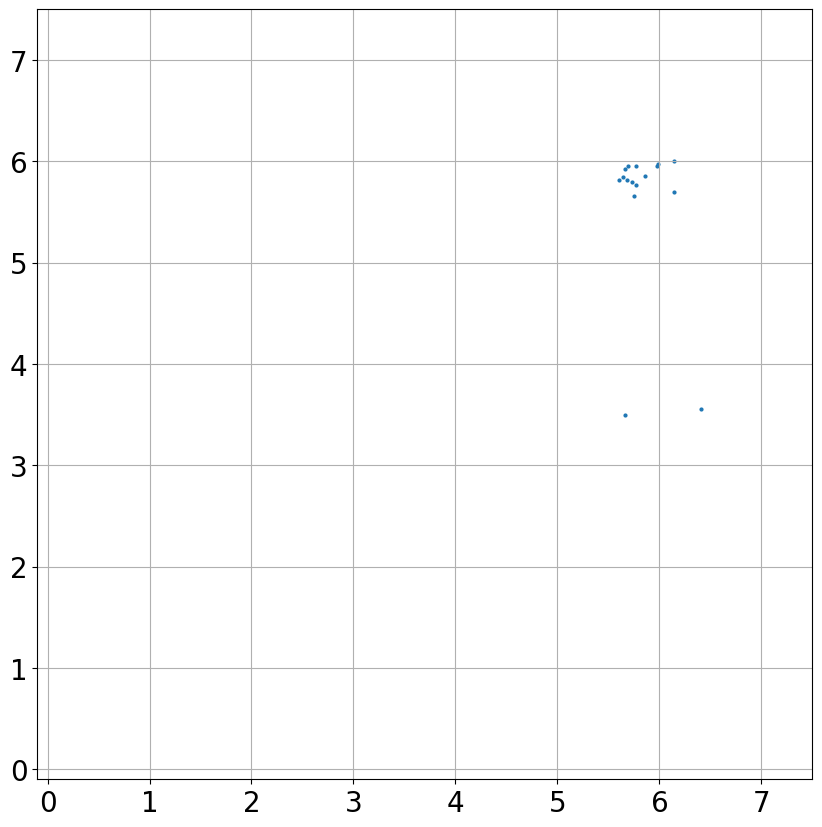

In [112]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [113]:
features_no = '21'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Bandos_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Bandos[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Bandos[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(34, 5)
(34, 5)


Name          RA        DEC       Z  psdr2_i_kron  psdr2_y_kron  \
0   b'P002+03'    2.542917   3.063214  5.6400     23.063873     21.023903   
1   b'P197+45'  197.867500  45.804081  5.6600     23.261926     21.080127   
2   b'P197+45'  197.867500  45.804081  5.6600     22.753530     21.947428   
3   b'P038-18'   38.191417 -18.573503  5.6800     22.395789     20.618324   
4   b'P178+28'  178.373333  28.507531  5.6800     22.242842     20.272445   
5   b'P207+37'  207.598333  37.809908  5.6900     23.244637     20.765107   
6   b'P196+15'  196.347625  15.389911  5.6900     23.374475     20.901504   
7   b'P169+58'  169.140667  58.889497  5.7300     22.562296     20.775380   
8   b'P119+02'  119.093250   2.305600  5.7300     22.921013     20.485496   
9   b'P271+49'  271.445542  49.306731  5.7400     22.912528     21.119376   
10  b'P072-07'   72.582542  -7.891831  5.7500     23.168455     20.978344   
11  b'P228+01'  228.702917   1.381181  5.7600     23.302882     21.497524   
12  b'P261+37'  261.124750  37.306056  5.7600     23.999385     20.780916   
13  b'P173-06'  173.319917  -6.945792  5.7700     22.887396     20.841105   
14  b'P209-08'  209.382583  -8.717150  5.7700     24.326848     21.585155   
15  b'P000-04'    0.041625  -4.273903  5.7700     23.999978     20.757872   
16  b'P193-02'  193.399250  -2.782025  5.8000     23.198624     21.429513   
17  b'P124+12'  124.003292  12.998975  5.8000     23.236469     21.023191   
18  b'P017-11'   17.069167 -11.991944  5.8000     23.165245     20.976401   
19  b'P175+71'  175.429458  71.323619  5.8600     23.158746     20.755012   
20  b'P288+63'  288.647667  63.247928  5.9600     23.305398     20.544022   
21  b'P008+10'    8.608333  10.851861  5.9800     23.005515     20.520902   
22  b'P182+53'  182.312208  53.463347  5.9900     24.322321     21.446049   
23  b'P265+41'  265.929792  41.413950  6.0263     24.307036     21.290471   
24  b'P030-17'   30.138750 -17.623889  6.0900     23.462062     20.222412   
25  b'P050-18'   50.560583 -18.688175  6.0900     24.221408     20.923400   
26  b'P218+04'  218.771458   4.818978  6.1400     23.276783     20.940435   
27  b'P127+26'  127.055875  26.565414  6.1400     24.543713     20.570737   
28  b'P334-05'  334.018167  -5.004883  6.1500     23.126115     22.791781   
29  b'P334-05'  334.018167  -5.004883  6.1500     24.189958     21.419254   
30  b'P281+53'  281.336167  53.763150  6.1800     23.867171     20.300084   
31  b'P173+48'  173.460167  48.242003  6.2330     24.903369     21.805279   
32  b'P215+26'  215.430375  26.532539  6.2800     24.825049     21.059354   
33  b'P170+20'  170.832667  20.208275  6.4100     22.355177     20.339585   

    psdr2_g_psf  psdr2_r_psf  psdr2_i_psf  psdr2_z_psf  ...  sample_279  \
0     25.535509    25.035888    23.063873    20.880725  ...    5.763835   
1     24.772076    25.907657    23.261926    20.919001  ...    5.893182   
2     25.446841    25.673448    22.464285    22.093542  ...    3.469933   
3     24.118885    24.900829    22.772416    20.672971  ...    5.695299   
4     25.062168    24.222816    21.994041    19.897865  ...    5.698221   
5     26.148481    25.209715    23.244637    20.865602  ...    2.715713   
6     24.777058    25.047240    23.374475    20.652349  ...    5.840620   
7     25.085519    24.121931    22.562296    20.468849  ...    5.776836   
8     26.441937    24.406721    22.627265    20.485988  ...    5.840586   
9     25.615574    24.829670    22.912528    20.261510  ...    5.744546   
10    24.713582    23.938597    23.168455    20.826399  ...    5.751989   
11    26.088484    25.417454    23.302882    21.255624  ...    5.145289   
12    25.029911    25.003478    23.407640    20.939365  ...    5.661748   
13    24.691404    25.399172    22.887396    20.503821  ...    5.823439   
14    25.488653    25.048480    24.326848    21.151009  ...    5.897958   
15    25.860855    23.658948    23.999978    20.771010  ...    5.551673   
16    24.555445    25.303572    23.1986

0.032452371145698974
0.08823529411764706
0.032452371145698974
0.08823529411764706
0.032452371145698974
0.08823529411764706


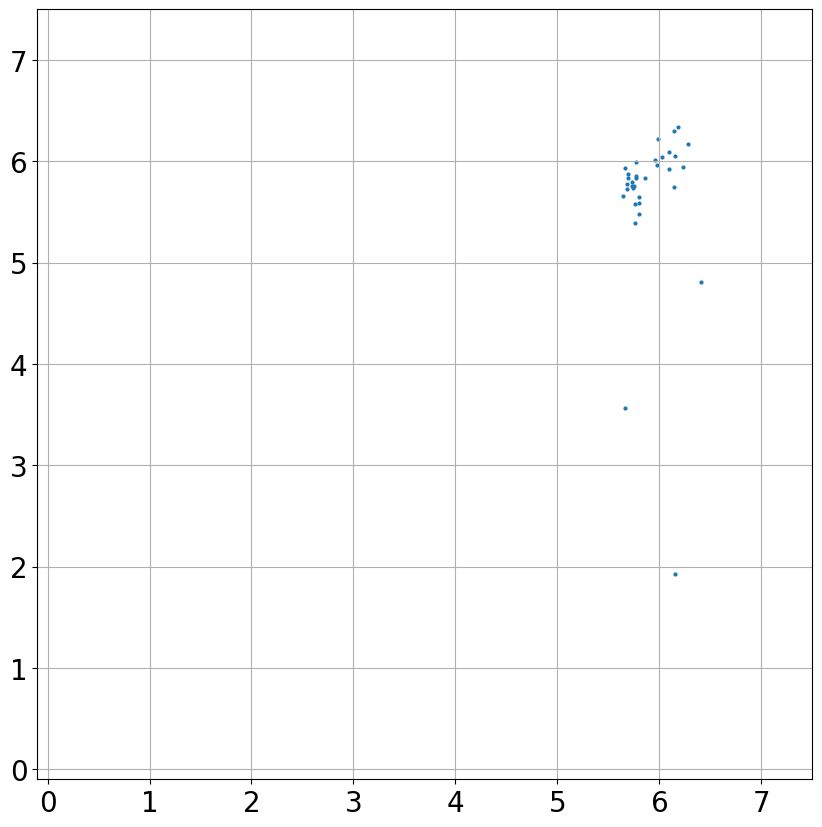

In [114]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [115]:
features_no = '22'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Bandos_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Bandos[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Bandos[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(51, 5)
(51, 5)


Name          RA        DEC       Z  decals8tr_Lw1-Lw2  \
0      b'P224+10'  224.650667  10.213797  5.6000           0.039270   
1      b'P002+03'    2.542917   3.063214  5.6400           0.306938   
2      b'P002+03'    2.542917   3.063214  5.6400           1.448113   
3      b'P197+45'  197.867500  45.804081  5.6600          -0.466814   
4      b'P197+45'  197.867500  45.804081  5.6600           2.028393   
5      b'P038-18'   38.191417 -18.573503  5.6800          -0.204866   
6      b'P178+28'  178.373333  28.507531  5.6800           0.223897   
7      b'P207+37'  207.598333  37.809908  5.6900          -0.476071   
8      b'P196+15'  196.347625  15.389911  5.6900           0.134413   
9      b'P119+02'  119.093250   2.305600  5.7300          -0.506333   
10     b'P169+58'  169.140667  58.889497  5.7300           0.269529   
11     b'P271+49'  271.445542  49.306731  5.7400          -0.079491   
12     b'P156+38'  156.446625  38.957306  5.7500           0.190538   
13     b'P072-07'   72.582542  -7.891831  5.7500           0.320462   
14     b'P228+01'  228.702917   1.381181  5.7600           0.364864   
15     b'P261+37'  261.124750  37.306056  5.7600           0.072735   
16     b'P209-08'  209.382583  -8.717150  5.7700          -0.272384   
17     b'P000-04'    0.041625  -4.273903  5.7700           0.254559   
18     b'P173-06'  173.319917  -6.945792  5.7700           0.222157   
19  b'J0224-3435'   36.236458 -34.589722  5.7800          -0.917519   
20     b'P065+01'   65.958958   1.723536  5.7900          -0.084460   
21     b'P193-02'  193.399250  -2.782025  5.8000           0.578264   
22     b'P017-11'   17.069167 -11.991944  5.8000           0.243578   
23     b'P193-02'  193.399250  -2.782025  5.8000          -0.243111   
24     b'P124+12'  124.003292  12.998975  5.8000          -0.592097   
25     b'P307-05'  307.763583  -5.195889  5.8000          -0.033308   
26     b'P148+69'  148.482917  69.181283  5.8400           0.022778   
27     b'P175+71'  175.429458  71.323619  5.8600           0.307164   
28     b'P218+28'  218.396750  28.330722  5.9100           0.249647   
29     b'P288+63'  288.647667  63.247928  5.9600           0.034936   
30     b'P008+10'    8.608333  10.851861  5.9800           0.259058   
31     b'P032-17'   32.918833 -17.074650  5.9900           0.193525   
32     b'P182+53'  182.312208  53.463347  5.9900           0.445096   
33     b'P032-17'   32.918833 -17.074650  5.9900           1.066137   
34  b'J0046-2837'   11.598542 -28.629911  6.0200           0.298868   
35  b'J0046-2837'   11.598542 -28.629911  6.0200           0.638272   
36     b'P265+41'  265.929792  41.413950  6.0263          -0.015150   
37     b'P050-18'   50.560583 -18.688175  6.0900          -0.280794   
38     b'P030-17'   30.138750 -17.623889  6.0900          -0.023821   
39     b'P030-17'   30.138750 -17.623889  6.0900           0.697048   
40     b'P218+04'  218.771458   4.818978  6.1400           0.776940   
41     b'P127+26'  127.055875  26.565414  6.1400           0.197377   
42     b'P127+26'  127.055875  26.565414  6.1400          -0.628923   
43     b'P334-05'  334.018167  -5.004883  6.1500           0.370846   
44     b'P334-05'  334.018167  -5.004883  6.1500          -0.058636   
45     b'P043-02'   43.111167  -2.622417  6.1700           0.005095   
46     b'P281+53'  281.336167  53.763150  6.1800           0.209379   
47     b'P173+48'  173.460167  48.242003  6.2330           0.432723   
48     b'P215+26'  215.430375  26.532539  6.2800           0.203993   
49  b'J1152+0055'  178.088625   0.926858  6.3643           0.547337   
50     b'P170+20'  170.832667  20.208275  6.4100          -0.526859   

    decals8tr_Lw1  decals8tr_Lw2  decals8tr_g  decals8tr_r  decals8tr_z  ...  \
0       18.806676      18.767405    26.190552    23.630175    19.904307  ...   
1       18.950366      18.643428    27.384824    24.925322    21.082177  ...   
2       21.963583      20.515470    24.696108    24.841755    24.541964  ...   


0.04497176673246809
0.19607843137254902
0.04497176673246809
0.19607843137254902
0.04497176673246809
0.19607843137254902


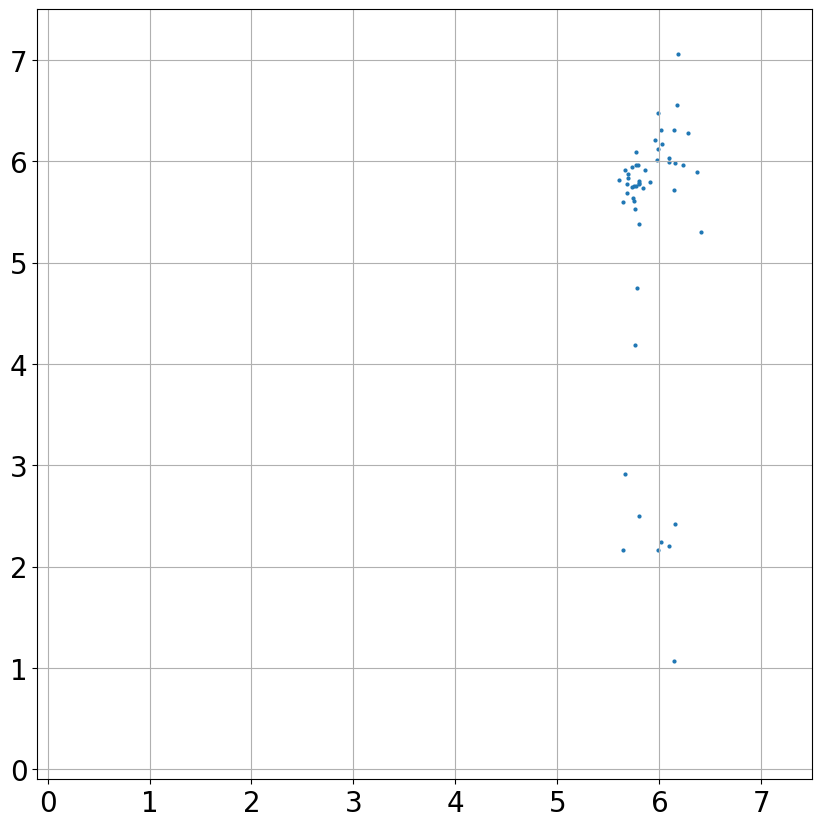

In [116]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [117]:
features_no = '35'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Bandos_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Bandos[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Bandos[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(14, 5)
(14, 5)


Name          RA        DEC     Z  sdssdr16_u_psf  sdssdr16_g_psf  \
0   b'P002+03'    2.542917   3.063214  5.64       24.558323       26.133148   
1   b'P197+45'  197.867500  45.804081  5.66       24.104864       25.654814   
2   b'P197+45'  197.867500  45.804081  5.66       23.775026       24.712160   
3   b'P178+28'  178.373333  28.507531  5.68       23.524440       24.620437   
4   b'P196+15'  196.347625  15.389911  5.69       23.806645       24.226026   
5   b'P169+58'  169.140667  58.889497  5.73       24.428553       25.697260   
6   b'P000-04'    0.041625  -4.273903  5.77       24.296314       24.699663   
7   b'P173-06'  173.319917  -6.945792  5.77       23.757557       25.129225   
8   b'P175+71'  175.429458  71.323619  5.86       23.872797       23.995796   
9   b'P008+10'    8.608333  10.851861  5.98       23.738679       24.243310   
10  b'P182+53'  182.312208  53.463347  5.99       24.971952       25.121010   
11  b'P218+04'  218.771458   4.818978  6.14       24.601274       24.864136   
12  b'P127+26'  127.055875  26.565414  6.14       23.930227       24.745570   
13  b'P170+20'  170.832667  20.208275  6.41       23.352230       23.937334   

    sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  ...  \
0        24.625209       23.314756       20.528049          24.899712  ...   
1        24.638524       23.786622       21.123026          20.955435  ...   
2        23.792998       22.440286       21.597111          22.598042  ...   
3        23.612532       22.087051       20.054246          23.722193  ...   
4        24.595661       23.481723       20.536767          20.921306  ...   
5        24.143593       22.270687       20.404945          24.608016  ...   
6        24.547295       24.163589       20.839449          21.277234  ...   
7        24.510366       23.051938       20.717359          23.122013  ...   
8        24.418122       22.970835       20.460364          23.723186  ...   
9        25.242199       23.163334       20.418486          23.813880  ...   
10       23.866735       23.231901       20.540164          24.857896  ...   
11       23.476958       23.673406       20.642980          22.960474  ...   
12       23.956804       23.004215       20.710638          22.103507  ...   
13       23.104182       21.420508       20.431502          23.541421  ...   

    sample_279  sample_280  sample_281  sample_282  sample_283  sample_284  \
0     5.898673    5.819135    5.866548    5.874959    5.858062    5.893409   
1     5.993847    6.016884    5.867939    5.887810    5.861512    5.803368   
2     1.529579    4.087960    3.954958    3.019473    4.003125    2.435012   
3     5.794883    5.776309    5.731457    5.776973    5.749380    5.774221   
4     5.896608    5.872729    5.846692    5.916829    5.876145    5.875526   
5     5.804494    5.806717    5.701260    5.827165    5.763501    5.784601   
6     5.463865    5.537940    5.625641    5.734535    5.473057    5.815055   
7     6.001896    5.986985    5.975302    5.993045    5.988273    5.939897   
8     5.872407    5.861935    5.830325    5.864135    5.842906    5.823612   
9     5.933221    5.973515    5.989554    6.006655    5.952149    6.000387   
10    6.178988    6.069795    5.981418    5.733780    6.029954    6.088084   
11    5.770571    5.974151    5.811496    5.895048    5.843521    6.044199   
12    6.208282    6.118503    6.044069    5.835624    5.972589    6.099785   
13    0.942920    3.687633    4.190929    4.007111    1.175004    0.968097   

    sample_285  sample_286  sample_287     zConf  
0     5.809022    5.798110    5.968280  1.000000  
1     5.906066    5.928640    5.744265  1.000000  
2     1.829469    3.518937    3.940303  0.399306  
3     5.790355    5.785086    5.733769  0.996528  
4     5.920084    5.872683    5.849493  0.993056  
5     5.821320    5.757139    5.813635  1.000000  
6     5.569165    5.391610    5.590344  0.996528  
7     5.939413    5.915477    5.941405  1.000000  
8     5.875792    5.896

0.034155705631389525
0.14285714285714285
0.034155705631389525
0.14285714285714285
0.034155705631389525
0.14285714285714285


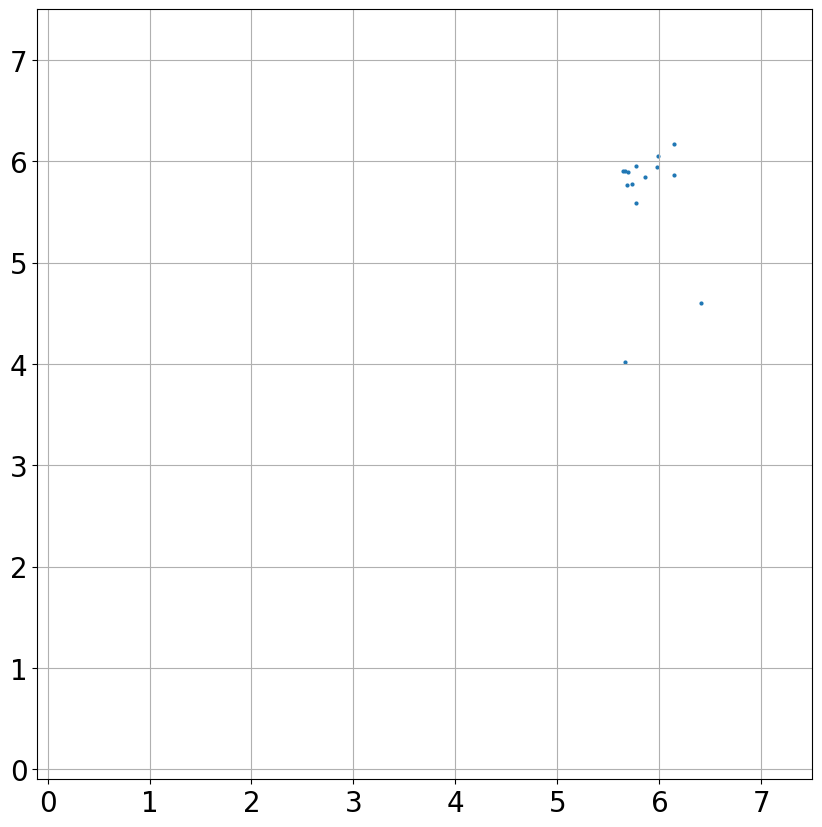

In [118]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [102]:
# Bandos

In [106]:
Bandos = pd.read_csv(f'data/Bandos/Bandos.csv')

In [107]:
Bandos.shape

(63, 86)

In [108]:
Bandos

Name          RA        DEC       Z  decals8tr_Lw1  \
0      b'P224+10'  224.650667  10.213797  5.6000      18.806676   
1      b'P142-11'  142.399042 -11.360442  5.6100      20.010596   
2      b'P002+03'    2.542917   3.063214  5.6400      18.950366   
3      b'P002+03'    2.542917   3.063214  5.6400      21.963583   
4      b'P197+45'  197.867500  45.804081  5.6600      19.940163   
..            ...         ...        ...     ...            ...   
58     b'P173+48'  173.460167  48.242003  6.2330      21.032978   
59     b'P215+26'  215.430375  26.532539  6.2800      20.059899   
60  b'J2211-3206'  332.801625 -32.103597  6.3394            NaN   
61  b'J1152+0055'  178.088625   0.926858  6.3643      20.768353   
62     b'P170+20'  170.832667  20.208275  6.4100      20.304841   

    decals8tr_Lw1-Lw2  decals8tr_Lw2  decals8tr_g  decals8tr_g-Lw1  \
0            0.039270      18.767405    26.190552         7.383876   
1           -0.017366      20.027961          NaN              NaN   
2            0.306938      18.643428    27.384824         8.434458   
3            1.448113      20.515470    24.696108         2.732526   
4           -0.466814      20.406977    25.568898         5.628735   
..                ...            ...          ...              ...   
58           0.432723      20.600255    26.495607         5.462629   
59           0.203993      19.855906    27.305794         7.245895   
60                NaN            NaN          NaN              NaN   
61           0.547337      20.221016    26.861107         6.092753   
62          -0.526859      20.831700    25.076541         4.771700   

    decals8tr_g-Lw2  ...  sdssdr16_u_cmodel-decals8tr_Lw1  \
0          7.423147  ...                         5.070272   
1               NaN  ...                              NaN   
2          8.741395  ...                         5.949346   
3          4.180639  ...                              NaN   
4          5.161921  ...                         1.015272   
..              ...  ...                              ...   
58         5.895352  ...                              NaN   
59         7.449888  ...                              NaN   
60              NaN  ...                              NaN   
61         6.640090  ...                              NaN   
62         4.244841  ...                         3.236580   

    sdssdr16_u_cmodel-decals8tr_Lw2  sdssdr16_u_psf  sdssdr16_u_psf-cmodel  \
0                          5.109542       24.489740               0.612793   
1                               NaN             NaN                    NaN   
2                          6.256284       24.558323              -0.341389   
3                               NaN             NaN                    NaN   
4                          0.548458       24.104864               3.149428   
..                              ...             ...                    ...   
58                              NaN             NaN                    NaN   
59                              NaN             NaN                    NaN   
60                              NaN             NaN                    NaN   
61                              NaN             NaN                    NaN   
62                         2.709721       23.352230              -0.189191   

    sdssdr16_z_cmodel  sdssdr16_z_cmodel-decals8tr_Lw1  \
0           20.165707                         1.359032   
1                 NaN                              NaN   
2           20.144316                         1.193950   
3                 NaN                              NaN   
4           20.795773                         0.855609   
..                ...                              ...   
58                NaN                              NaN   
59                NaN                              NaN   
60                NaN                              NaN   
61                NaN                              NaN   
62          20.181978                        -0.122863   



In [109]:
features_no = '18'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Bandos_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Bandos[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Bandos[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(16, 5)
(16, 5)


Name          RA        DEC     Z  sdssdr16_u_psf  sdssdr16_g_psf  \
0   b'P224+10'  224.650667  10.213797  5.60       24.489740       24.533139   
1   b'P002+03'    2.542917   3.063214  5.64       24.558323       26.133148   
2   b'P197+45'  197.867500  45.804081  5.66       24.104864       25.654814   
3   b'P197+45'  197.867500  45.804081  5.66       23.775026       24.712160   
4   b'P178+28'  178.373333  28.507531  5.68       23.524440       24.620437   
5   b'P196+15'  196.347625  15.389911  5.69       23.806645       24.226026   
6   b'P169+58'  169.140667  58.889497  5.73       24.428553       25.697260   
7   b'P156+38'  156.446625  38.957306  5.75       23.769450       25.652387   
8   b'P000-04'    0.041625  -4.273903  5.77       24.296314       24.699663   
9   b'P173-06'  173.319917  -6.945792  5.77       23.757557       25.129225   
10  b'P175+71'  175.429458  71.323619  5.86       23.872797       23.995796   
11  b'P008+10'    8.608333  10.851861  5.98       23.738679       24.243310   
12  b'P182+53'  182.312208  53.463347  5.99       24.971952       25.121010   
13  b'P218+04'  218.771458   4.818978  6.14       24.601274       24.864136   
14  b'P127+26'  127.055875  26.565414  6.14       23.930227       24.745570   
15  b'P170+20'  170.832667  20.208275  6.41       23.352230       23.937334   

    sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  ...  \
0        23.965027       22.085891       20.171990          23.876947  ...   
1        24.625209       23.314756       20.528049          24.899712  ...   
2        24.638524       23.786622       21.123026          20.955435  ...   
3        23.792998       22.440286       21.597111          22.598042  ...   
4        23.612532       22.087051       20.054246          23.722193  ...   
5        24.595661       23.481723       20.536767          20.921306  ...   
6        24.143593       22.270687       20.404945          24.608016  ...   
7        23.857617       22.137698       20.056790          21.802641  ...   
8        24.547295       24.163589       20.839449          21.277234  ...   
9        24.510366       23.051938       20.717359          23.122013  ...   
10       24.418122       22.970835       20.460364          23.723186  ...   
11       25.242199       23.163334       20.418486          23.813880  ...   
12       23.866735       23.231901       20.540164          24.857896  ...   
13       23.476958       23.673406       20.642980          22.960474  ...   
14       23.956804       23.004215       20.710638          22.103507  ...   
15       23.104182       21.420508       20.431502          23.541421  ...   

    sample_279  sample_280  sample_281  sample_282  sample_283  sample_284  \
0     5.790934    5.881398    5.820861    5.796987    5.762661    5.794201   
1     6.284396    6.125717    6.195226    6.153761    6.354307    6.201006   
2     5.786410    0.727458    5.905322    5.917669    4.898857    1.844828   
3     2.425848    2.658141    3.321069    4.021697    3.904397    2.445477   
4     5.756321    5.772041    5.851365    5.850319    5.763955    5.704246   
5     6.085271    5.919527    5.023919    6.027134    4.773989    6.222708   
6     5.758023    5.774266    5.814925    5.725124    5.792575    5.766672   
7     5.863139    5.900522    5.813942    5.905928    5.974638    5.776524   
8     6.024470    5.980401    5.978098    5.941327    5.754678    5.911483   
9     6.074596    6.010097    6.036906    6.070097    6.058531    5.998670   
10    5.849914    5.718288    5.793367    5.889924    5.871206    5.877150   
11    5.784177    5.976271    5.770989    5.738030    5.935653    5.873876   
12    5.857402    5.865315    5.979376    5.723460    5.875877    5.899874   
13    5.331050    5.299859    5.607917    5.764377    5.359484    5.792312   
14    5.706695    5.711454    5.653791    5.440526    5.458082    5.730670   
15    2.715298    0.665243    1.775631    0.881941    2.515513    1.757306   

    sample_2

0.033069512903732855
0.125
0.033069512903732855
0.125
0.033069512903732855
0.125


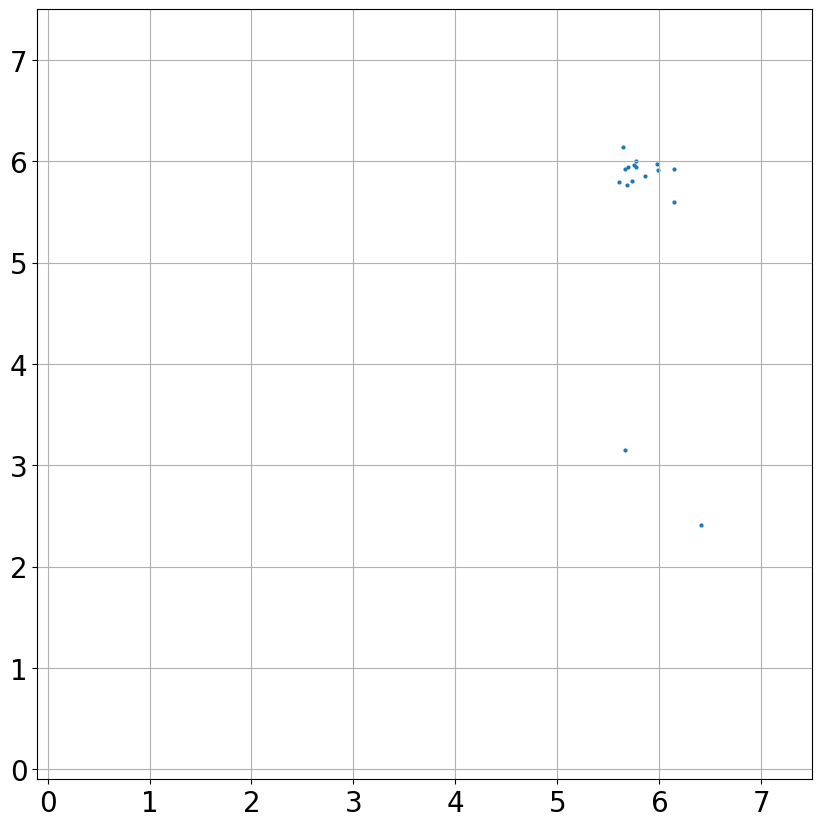

In [110]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [111]:
features_no = '20'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Bandos_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Bandos[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Bandos[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(16, 5)
(16, 5)


Name          RA        DEC     Z  sdssdr16_u_psf  sdssdr16_g_psf  \
0   b'P224+10'  224.650667  10.213797  5.60       24.489740       24.533139   
1   b'P002+03'    2.542917   3.063214  5.64       24.558323       26.133148   
2   b'P197+45'  197.867500  45.804081  5.66       24.104864       25.654814   
3   b'P197+45'  197.867500  45.804081  5.66       23.775026       24.712160   
4   b'P178+28'  178.373333  28.507531  5.68       23.524440       24.620437   
5   b'P196+15'  196.347625  15.389911  5.69       23.806645       24.226026   
6   b'P169+58'  169.140667  58.889497  5.73       24.428553       25.697260   
7   b'P156+38'  156.446625  38.957306  5.75       23.769450       25.652387   
8   b'P000-04'    0.041625  -4.273903  5.77       24.296314       24.699663   
9   b'P173-06'  173.319917  -6.945792  5.77       23.757557       25.129225   
10  b'P175+71'  175.429458  71.323619  5.86       23.872797       23.995796   
11  b'P008+10'    8.608333  10.851861  5.98       23.738679       24.243310   
12  b'P182+53'  182.312208  53.463347  5.99       24.971952       25.121010   
13  b'P218+04'  218.771458   4.818978  6.14       24.601274       24.864136   
14  b'P127+26'  127.055875  26.565414  6.14       23.930227       24.745570   
15  b'P170+20'  170.832667  20.208275  6.41       23.352230       23.937334   

    sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  ...  \
0        23.965027       22.085891       20.171990          23.876947  ...   
1        24.625209       23.314756       20.528049          24.899712  ...   
2        24.638524       23.786622       21.123026          20.955435  ...   
3        23.792998       22.440286       21.597111          22.598042  ...   
4        23.612532       22.087051       20.054246          23.722193  ...   
5        24.595661       23.481723       20.536767          20.921306  ...   
6        24.143593       22.270687       20.404945          24.608016  ...   
7        23.857617       22.137698       20.056790          21.802641  ...   
8        24.547295       24.163589       20.839449          21.277234  ...   
9        24.510366       23.051938       20.717359          23.122013  ...   
10       24.418122       22.970835       20.460364          23.723186  ...   
11       25.242199       23.163334       20.418486          23.813880  ...   
12       23.866735       23.231901       20.540164          24.857896  ...   
13       23.476958       23.673406       20.642980          22.960474  ...   
14       23.956804       23.004215       20.710638          22.103507  ...   
15       23.104182       21.420508       20.431502          23.541421  ...   

    sample_279  sample_280  sample_281  sample_282  sample_283  sample_284  \
0     5.771711    5.863710    5.784668    5.781000    5.841858    5.802991   
1     5.832612    5.726156    5.822559    5.825661    5.866892    5.843089   
2     5.853242    5.920049    5.917242    5.800605    6.004449    5.823602   
3     3.921868    3.390929    3.055822    3.601301    3.758026    3.677797   
4     5.822136    5.820385    5.867340    5.820442    5.855209    5.874801   
5     5.831057    5.867688    5.744558    5.687502    5.773736    5.789222   
6     5.830572    5.780270    5.841491    5.774554    5.814124    5.800903   
7     5.648911    5.757680    5.786290    5.702848    5.694184    0.957939   
8     5.749794    5.475855    5.349191    5.872349    5.076277    4.944889   
9     5.973953    6.032656    5.906194    5.968503    6.008895    6.088654   
10    5.822369    5.794313    5.805469    5.834120    5.799902    5.880598   
11    5.953696    5.930016    5.932078    5.988112    5.953917    5.992547   
12    6.008459    5.699526    5.660494    5.838006    5.925520    5.954898   
13    5.743095    5.258262    4.849853    5.423407    5.000602    5.533147   
14    5.830081    6.877130    6.612504    5.387611    5.880063    6.363539   
15    2.066400    3.233325    3.545529    4.511920    3.486452    4.572439   

    sample_2

0.036619586548758784
0.125
0.036619586548758784
0.125
0.036619586548758784
0.125


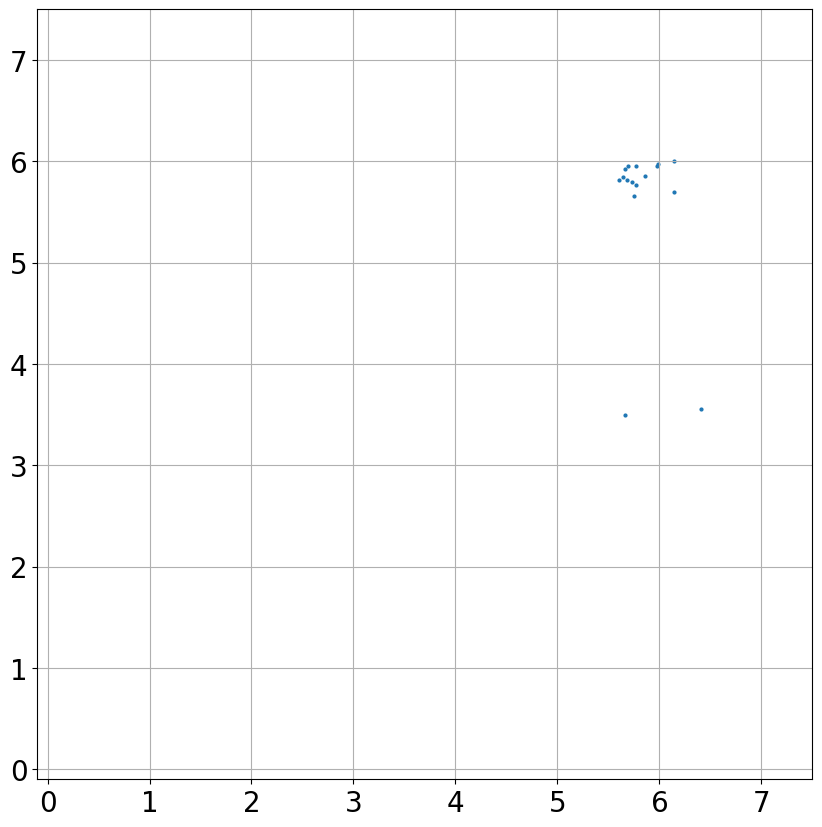

In [112]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [113]:
features_no = '21'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Bandos_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Bandos[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Bandos[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(34, 5)
(34, 5)


Name          RA        DEC       Z  psdr2_i_kron  psdr2_y_kron  \
0   b'P002+03'    2.542917   3.063214  5.6400     23.063873     21.023903   
1   b'P197+45'  197.867500  45.804081  5.6600     23.261926     21.080127   
2   b'P197+45'  197.867500  45.804081  5.6600     22.753530     21.947428   
3   b'P038-18'   38.191417 -18.573503  5.6800     22.395789     20.618324   
4   b'P178+28'  178.373333  28.507531  5.6800     22.242842     20.272445   
5   b'P207+37'  207.598333  37.809908  5.6900     23.244637     20.765107   
6   b'P196+15'  196.347625  15.389911  5.6900     23.374475     20.901504   
7   b'P169+58'  169.140667  58.889497  5.7300     22.562296     20.775380   
8   b'P119+02'  119.093250   2.305600  5.7300     22.921013     20.485496   
9   b'P271+49'  271.445542  49.306731  5.7400     22.912528     21.119376   
10  b'P072-07'   72.582542  -7.891831  5.7500     23.168455     20.978344   
11  b'P228+01'  228.702917   1.381181  5.7600     23.302882     21.497524   
12  b'P261+37'  261.124750  37.306056  5.7600     23.999385     20.780916   
13  b'P173-06'  173.319917  -6.945792  5.7700     22.887396     20.841105   
14  b'P209-08'  209.382583  -8.717150  5.7700     24.326848     21.585155   
15  b'P000-04'    0.041625  -4.273903  5.7700     23.999978     20.757872   
16  b'P193-02'  193.399250  -2.782025  5.8000     23.198624     21.429513   
17  b'P124+12'  124.003292  12.998975  5.8000     23.236469     21.023191   
18  b'P017-11'   17.069167 -11.991944  5.8000     23.165245     20.976401   
19  b'P175+71'  175.429458  71.323619  5.8600     23.158746     20.755012   
20  b'P288+63'  288.647667  63.247928  5.9600     23.305398     20.544022   
21  b'P008+10'    8.608333  10.851861  5.9800     23.005515     20.520902   
22  b'P182+53'  182.312208  53.463347  5.9900     24.322321     21.446049   
23  b'P265+41'  265.929792  41.413950  6.0263     24.307036     21.290471   
24  b'P030-17'   30.138750 -17.623889  6.0900     23.462062     20.222412   
25  b'P050-18'   50.560583 -18.688175  6.0900     24.221408     20.923400   
26  b'P218+04'  218.771458   4.818978  6.1400     23.276783     20.940435   
27  b'P127+26'  127.055875  26.565414  6.1400     24.543713     20.570737   
28  b'P334-05'  334.018167  -5.004883  6.1500     23.126115     22.791781   
29  b'P334-05'  334.018167  -5.004883  6.1500     24.189958     21.419254   
30  b'P281+53'  281.336167  53.763150  6.1800     23.867171     20.300084   
31  b'P173+48'  173.460167  48.242003  6.2330     24.903369     21.805279   
32  b'P215+26'  215.430375  26.532539  6.2800     24.825049     21.059354   
33  b'P170+20'  170.832667  20.208275  6.4100     22.355177     20.339585   

    psdr2_g_psf  psdr2_r_psf  psdr2_i_psf  psdr2_z_psf  ...  sample_279  \
0     25.535509    25.035888    23.063873    20.880725  ...    5.763835   
1     24.772076    25.907657    23.261926    20.919001  ...    5.893182   
2     25.446841    25.673448    22.464285    22.093542  ...    3.469933   
3     24.118885    24.900829    22.772416    20.672971  ...    5.695299   
4     25.062168    24.222816    21.994041    19.897865  ...    5.698221   
5     26.148481    25.209715    23.244637    20.865602  ...    2.715713   
6     24.777058    25.047240    23.374475    20.652349  ...    5.840620   
7     25.085519    24.121931    22.562296    20.468849  ...    5.776836   
8     26.441937    24.406721    22.627265    20.485988  ...    5.840586   
9     25.615574    24.829670    22.912528    20.261510  ...    5.744546   
10    24.713582    23.938597    23.168455    20.826399  ...    5.751989   
11    26.088484    25.417454    23.302882    21.255624  ...    5.145289   
12    25.029911    25.003478    23.407640    20.939365  ...    5.661748   
13    24.691404    25.399172    22.887396    20.503821  ...    5.823439   
14    25.488653    25.048480    24.326848    21.151009  ...    5.897958   
15    25.860855    23.658948    23.999978    20.771010  ...    5.551673   
16    24.555445    25.303572    23.1986

0.032452371145698974
0.08823529411764706
0.032452371145698974
0.08823529411764706
0.032452371145698974
0.08823529411764706


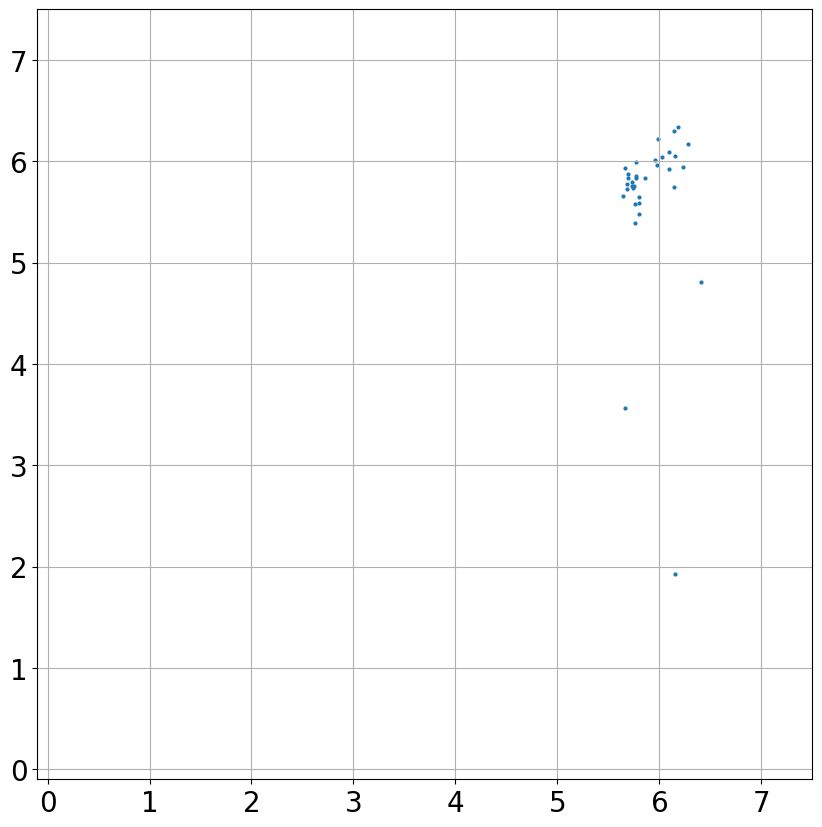

In [114]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [115]:
features_no = '22'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Bandos_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Bandos[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Bandos[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(51, 5)
(51, 5)


Name          RA        DEC       Z  decals8tr_Lw1-Lw2  \
0      b'P224+10'  224.650667  10.213797  5.6000           0.039270   
1      b'P002+03'    2.542917   3.063214  5.6400           0.306938   
2      b'P002+03'    2.542917   3.063214  5.6400           1.448113   
3      b'P197+45'  197.867500  45.804081  5.6600          -0.466814   
4      b'P197+45'  197.867500  45.804081  5.6600           2.028393   
5      b'P038-18'   38.191417 -18.573503  5.6800          -0.204866   
6      b'P178+28'  178.373333  28.507531  5.6800           0.223897   
7      b'P207+37'  207.598333  37.809908  5.6900          -0.476071   
8      b'P196+15'  196.347625  15.389911  5.6900           0.134413   
9      b'P119+02'  119.093250   2.305600  5.7300          -0.506333   
10     b'P169+58'  169.140667  58.889497  5.7300           0.269529   
11     b'P271+49'  271.445542  49.306731  5.7400          -0.079491   
12     b'P156+38'  156.446625  38.957306  5.7500           0.190538   
13     b'P072-07'   72.582542  -7.891831  5.7500           0.320462   
14     b'P228+01'  228.702917   1.381181  5.7600           0.364864   
15     b'P261+37'  261.124750  37.306056  5.7600           0.072735   
16     b'P209-08'  209.382583  -8.717150  5.7700          -0.272384   
17     b'P000-04'    0.041625  -4.273903  5.7700           0.254559   
18     b'P173-06'  173.319917  -6.945792  5.7700           0.222157   
19  b'J0224-3435'   36.236458 -34.589722  5.7800          -0.917519   
20     b'P065+01'   65.958958   1.723536  5.7900          -0.084460   
21     b'P193-02'  193.399250  -2.782025  5.8000           0.578264   
22     b'P017-11'   17.069167 -11.991944  5.8000           0.243578   
23     b'P193-02'  193.399250  -2.782025  5.8000          -0.243111   
24     b'P124+12'  124.003292  12.998975  5.8000          -0.592097   
25     b'P307-05'  307.763583  -5.195889  5.8000          -0.033308   
26     b'P148+69'  148.482917  69.181283  5.8400           0.022778   
27     b'P175+71'  175.429458  71.323619  5.8600           0.307164   
28     b'P218+28'  218.396750  28.330722  5.9100           0.249647   
29     b'P288+63'  288.647667  63.247928  5.9600           0.034936   
30     b'P008+10'    8.608333  10.851861  5.9800           0.259058   
31     b'P032-17'   32.918833 -17.074650  5.9900           0.193525   
32     b'P182+53'  182.312208  53.463347  5.9900           0.445096   
33     b'P032-17'   32.918833 -17.074650  5.9900           1.066137   
34  b'J0046-2837'   11.598542 -28.629911  6.0200           0.298868   
35  b'J0046-2837'   11.598542 -28.629911  6.0200           0.638272   
36     b'P265+41'  265.929792  41.413950  6.0263          -0.015150   
37     b'P050-18'   50.560583 -18.688175  6.0900          -0.280794   
38     b'P030-17'   30.138750 -17.623889  6.0900          -0.023821   
39     b'P030-17'   30.138750 -17.623889  6.0900           0.697048   
40     b'P218+04'  218.771458   4.818978  6.1400           0.776940   
41     b'P127+26'  127.055875  26.565414  6.1400           0.197377   
42     b'P127+26'  127.055875  26.565414  6.1400          -0.628923   
43     b'P334-05'  334.018167  -5.004883  6.1500           0.370846   
44     b'P334-05'  334.018167  -5.004883  6.1500          -0.058636   
45     b'P043-02'   43.111167  -2.622417  6.1700           0.005095   
46     b'P281+53'  281.336167  53.763150  6.1800           0.209379   
47     b'P173+48'  173.460167  48.242003  6.2330           0.432723   
48     b'P215+26'  215.430375  26.532539  6.2800           0.203993   
49  b'J1152+0055'  178.088625   0.926858  6.3643           0.547337   
50     b'P170+20'  170.832667  20.208275  6.4100          -0.526859   

    decals8tr_Lw1  decals8tr_Lw2  decals8tr_g  decals8tr_r  decals8tr_z  ...  \
0       18.806676      18.767405    26.190552    23.630175    19.904307  ...   
1       18.950366      18.643428    27.384824    24.925322    21.082177  ...   
2       21.963583      20.515470    24.696108    24.841755    24.541964  ...   


0.04497176673246809
0.19607843137254902
0.04497176673246809
0.19607843137254902
0.04497176673246809
0.19607843137254902


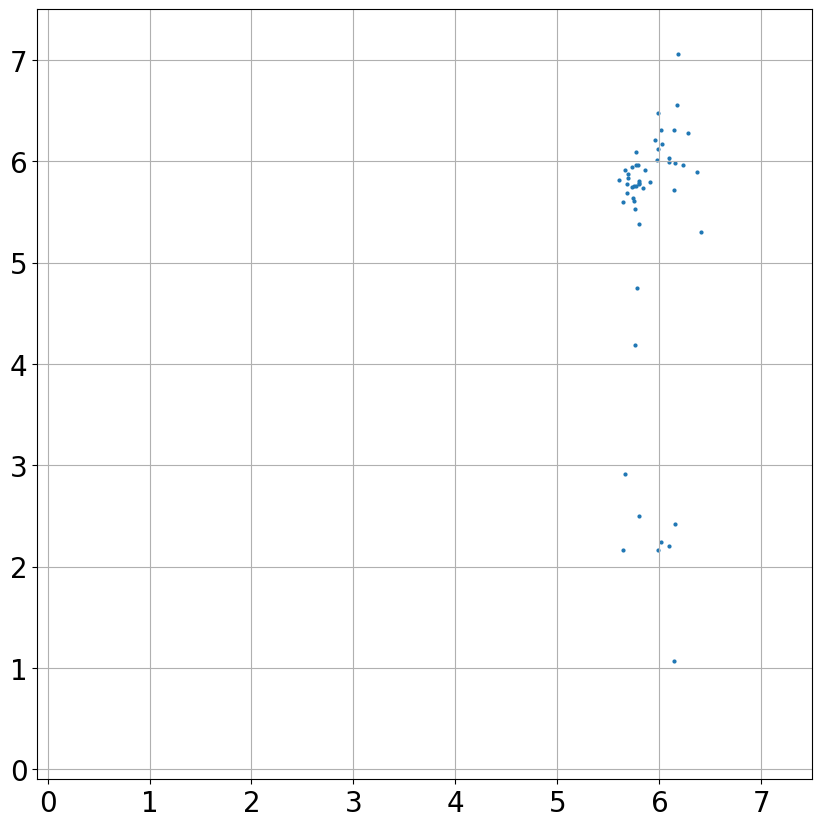

In [116]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [117]:
features_no = '35'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'Bandos_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = Bandos[['Name', 'RA', 'DEC', 'Z'] + features + rf_features][Bandos[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['Name', 'RA', 'DEC', 'Z'] + features + rf_features], result], axis=1)
result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result_cv2.gz_csv', index=False, compression='gzip')
result

(14, 5)
(14, 5)


Name          RA        DEC     Z  sdssdr16_u_psf  sdssdr16_g_psf  \
0   b'P002+03'    2.542917   3.063214  5.64       24.558323       26.133148   
1   b'P197+45'  197.867500  45.804081  5.66       24.104864       25.654814   
2   b'P197+45'  197.867500  45.804081  5.66       23.775026       24.712160   
3   b'P178+28'  178.373333  28.507531  5.68       23.524440       24.620437   
4   b'P196+15'  196.347625  15.389911  5.69       23.806645       24.226026   
5   b'P169+58'  169.140667  58.889497  5.73       24.428553       25.697260   
6   b'P000-04'    0.041625  -4.273903  5.77       24.296314       24.699663   
7   b'P173-06'  173.319917  -6.945792  5.77       23.757557       25.129225   
8   b'P175+71'  175.429458  71.323619  5.86       23.872797       23.995796   
9   b'P008+10'    8.608333  10.851861  5.98       23.738679       24.243310   
10  b'P182+53'  182.312208  53.463347  5.99       24.971952       25.121010   
11  b'P218+04'  218.771458   4.818978  6.14       24.601274       24.864136   
12  b'P127+26'  127.055875  26.565414  6.14       23.930227       24.745570   
13  b'P170+20'  170.832667  20.208275  6.41       23.352230       23.937334   

    sdssdr16_r_psf  sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  ...  \
0        24.625209       23.314756       20.528049          24.899712  ...   
1        24.638524       23.786622       21.123026          20.955435  ...   
2        23.792998       22.440286       21.597111          22.598042  ...   
3        23.612532       22.087051       20.054246          23.722193  ...   
4        24.595661       23.481723       20.536767          20.921306  ...   
5        24.143593       22.270687       20.404945          24.608016  ...   
6        24.547295       24.163589       20.839449          21.277234  ...   
7        24.510366       23.051938       20.717359          23.122013  ...   
8        24.418122       22.970835       20.460364          23.723186  ...   
9        25.242199       23.163334       20.418486          23.813880  ...   
10       23.866735       23.231901       20.540164          24.857896  ...   
11       23.476958       23.673406       20.642980          22.960474  ...   
12       23.956804       23.004215       20.710638          22.103507  ...   
13       23.104182       21.420508       20.431502          23.541421  ...   

    sample_279  sample_280  sample_281  sample_282  sample_283  sample_284  \
0     5.898673    5.819135    5.866548    5.874959    5.858062    5.893409   
1     5.993847    6.016884    5.867939    5.887810    5.861512    5.803368   
2     1.529579    4.087960    3.954958    3.019473    4.003125    2.435012   
3     5.794883    5.776309    5.731457    5.776973    5.749380    5.774221   
4     5.896608    5.872729    5.846692    5.916829    5.876145    5.875526   
5     5.804494    5.806717    5.701260    5.827165    5.763501    5.784601   
6     5.463865    5.537940    5.625641    5.734535    5.473057    5.815055   
7     6.001896    5.986985    5.975302    5.993045    5.988273    5.939897   
8     5.872407    5.861935    5.830325    5.864135    5.842906    5.823612   
9     5.933221    5.973515    5.989554    6.006655    5.952149    6.000387   
10    6.178988    6.069795    5.981418    5.733780    6.029954    6.088084   
11    5.770571    5.974151    5.811496    5.895048    5.843521    6.044199   
12    6.208282    6.118503    6.044069    5.835624    5.972589    6.099785   
13    0.942920    3.687633    4.190929    4.007111    1.175004    0.968097   

    sample_285  sample_286  sample_287     zConf  
0     5.809022    5.798110    5.968280  1.000000  
1     5.906066    5.928640    5.744265  1.000000  
2     1.829469    3.518937    3.940303  0.399306  
3     5.790355    5.785086    5.733769  0.996528  
4     5.920084    5.872683    5.849493  0.993056  
5     5.821320    5.757139    5.813635  1.000000  
6     5.569165    5.391610    5.590344  0.996528  
7     5.939413    5.915477    5.941405  1.000000  
8     5.875792    5.896

0.034155705631389525
0.14285714285714285
0.034155705631389525
0.14285714285714285
0.034155705631389525
0.14285714285714285


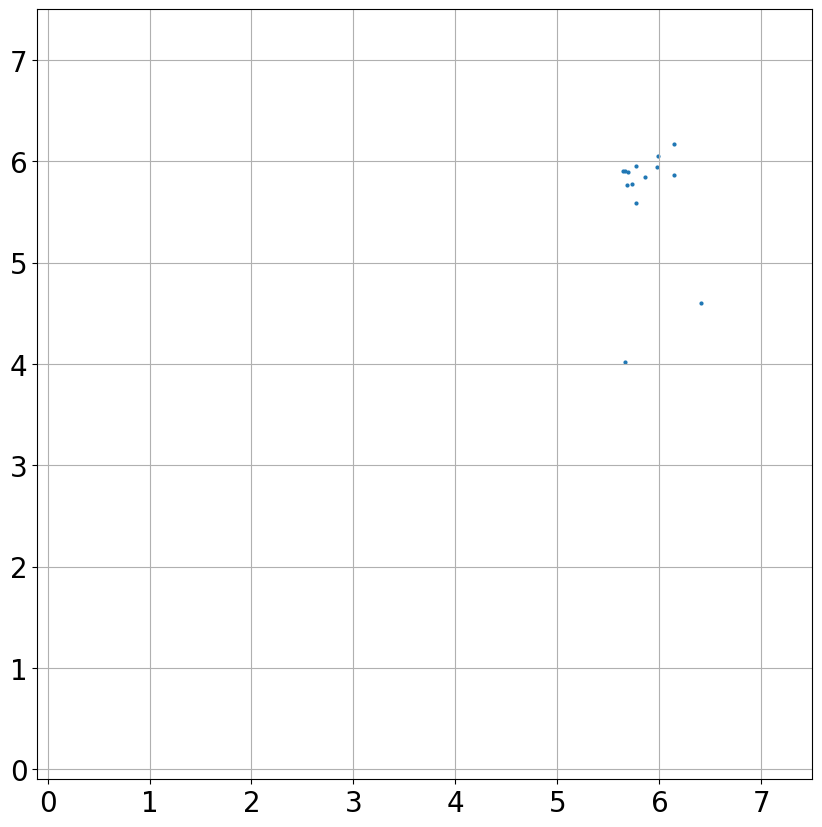

In [118]:
print(metrics.sigma_nmad(result['Z'], result['mode']))
print(metrics.out_rate(result['Z'], result['mode']))
print(metrics.sigma_nmad_z4(result['Z'], result['mode']))
print(metrics.out_rate_z4(result['Z'], result['mode']))
print(metrics.sigma_nmad_z5(result['Z'], result['mode']))
print(metrics.out_rate_z5(result['Z'], result['mode']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-0.1, 7.5)
plt.ylim(-0.1, 7.5)
plt.grid()

plt.scatter(result['Z'], result['mode'], s=4, alpha=1);

In [127]:
# DR16Q

In [128]:
DR16Q = pd.read_csv(f'data/DR16Q/DR16Q.csv')

In [129]:
DR16Q.shape

(183174, 84)

In [108]:
Bandos

Name          RA        DEC       Z  decals8tr_Lw1  \
0      b'P224+10'  224.650667  10.213797  5.6000      18.806676   
1      b'P142-11'  142.399042 -11.360442  5.6100      20.010596   
2      b'P002+03'    2.542917   3.063214  5.6400      18.950366   
3      b'P002+03'    2.542917   3.063214  5.6400      21.963583   
4      b'P197+45'  197.867500  45.804081  5.6600      19.940163   
..            ...         ...        ...     ...            ...   
58     b'P173+48'  173.460167  48.242003  6.2330      21.032978   
59     b'P215+26'  215.430375  26.532539  6.2800      20.059899   
60  b'J2211-3206'  332.801625 -32.103597  6.3394            NaN   
61  b'J1152+0055'  178.088625   0.926858  6.3643      20.768353   
62     b'P170+20'  170.832667  20.208275  6.4100      20.304841   

    decals8tr_Lw1-Lw2  decals8tr_Lw2  decals8tr_g  decals8tr_g-Lw1  \
0            0.039270      18.767405    26.190552         7.383876   
1           -0.017366      20.027961          NaN              NaN   
2            0.306938      18.643428    27.384824         8.434458   
3            1.448113      20.515470    24.696108         2.732526   
4           -0.466814      20.406977    25.568898         5.628735   
..                ...            ...          ...              ...   
58           0.432723      20.600255    26.495607         5.462629   
59           0.203993      19.855906    27.305794         7.245895   
60                NaN            NaN          NaN              NaN   
61           0.547337      20.221016    26.861107         6.092753   
62          -0.526859      20.831700    25.076541         4.771700   

    decals8tr_g-Lw2  ...  sdssdr16_u_cmodel-decals8tr_Lw1  \
0          7.423147  ...                         5.070272   
1               NaN  ...                              NaN   
2          8.741395  ...                         5.949346   
3          4.180639  ...                              NaN   
4          5.161921  ...                         1.015272   
..              ...  ...                              ...   
58         5.895352  ...                              NaN   
59         7.449888  ...                              NaN   
60              NaN  ...                              NaN   
61         6.640090  ...                              NaN   
62         4.244841  ...                         3.236580   

    sdssdr16_u_cmodel-decals8tr_Lw2  sdssdr16_u_psf  sdssdr16_u_psf-cmodel  \
0                          5.109542       24.489740               0.612793   
1                               NaN             NaN                    NaN   
2                          6.256284       24.558323              -0.341389   
3                               NaN             NaN                    NaN   
4                          0.548458       24.104864               3.149428   
..                              ...             ...                    ...   
58                              NaN             NaN                    NaN   
59                              NaN             NaN                    NaN   
60                              NaN             NaN                    NaN   
61                              NaN             NaN                    NaN   
62                         2.709721       23.352230              -0.189191   

    sdssdr16_z_cmodel  sdssdr16_z_cmodel-decals8tr_Lw1  \
0           20.165707                         1.359032   
1                 NaN                              NaN   
2           20.144316                         1.193950   
3                 NaN                              NaN   
4           20.795773                         0.855609   
..                ...                              ...   
58                NaN                              NaN   
59                NaN                              NaN   
60                NaN                              NaN   
61                NaN                              NaN   
62          20.181978                        -0.122863   



In [131]:
features_no = '18'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'DR16Q_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = DR16Q[['RA', 'DEC'] + features + rf_features][DR16Q[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
# y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['RA', 'DEC'] + features + rf_features], result], axis=1)
# result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result.gz_csv', index=False, compression='gzip')
result

(180829, 5)
(180829, 5)


RA        DEC  sdssdr16_u_psf  sdssdr16_g_psf  sdssdr16_r_psf  \
0        39.239678   4.968538       20.694661       20.652652       20.724872   
1        39.240164   4.924701       22.125788       22.311477       21.815872   
2        39.249088   5.024895       20.236474       19.826736       19.738328   
3        39.278385   4.936419       21.532854       21.107350       20.872997   
4        39.292045   5.167677       21.202122       20.918864       20.410803   
...            ...        ...             ...             ...             ...   
180824  123.519555  30.221197       21.679477       21.755877       21.494887   
180825  123.526085  29.979998       19.490058       19.337425       19.077474   
180826  123.540932  29.849397       21.841082       21.639067       21.517214   
180827  123.559309  30.085757       20.665096       19.889769       19.999147   
180828  123.592746  30.038435       20.386988       19.687787       19.307148   

        sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  sdssdr16_g_cmodel  \
0            20.322765       20.373522          20.645400          20.616780   
1            21.639831       21.942458          21.928961          22.340303   
2            19.517115       19.522551          20.205125          19.816749   
3            20.995029       20.656174          21.721990          21.227901   
4            20.253363       20.191298          21.054460          20.887049   
...                ...             ...                ...                ...   
180824       21.520184       21.335678          21.706944          21.767075   
180825       19.161485       19.319014          19.502181          19.326234   
180826       21.324748       21.275482          21.434102          21.661539   
180827       19.983865       19.713948          20.578336          19.852709   
180828       19.102416       18.814375          20.390496          19.632658   

        sdssdr16_r_cmodel  ...  sample_279  sample_280  sample_281  \
0               20.730836  ...    1.652509    1.742264    1.858708   
1               21.678697  ...    1.257101    1.412362    1.387428   
2               19.748554  ...    1.625755    1.747405    1.574289   
3               21.134735  ...    2.595784    2.163869    2.630364   
4               20.382423  ...    1.320769    1.277576    1.312739   
...                   ...  ...         ...         ...         ...   
180824          21.515201  ...    1.212031    1.213922    1.177770   
180825          19.063750  ...    1.292406    1.214346    1.249967   
180826          21.540074  ...    1.217414    2.221459    1.721440   
180827          19.969835  ...    2.323850    2.459353    2.429572   
180828          19.318574  ...    2.259553    2.073652    2.063280   

        sample_282  sample_283  sample_284  sample_285  sample_286  \
0         1.755749    1.897109    1.785088    1.802841    1.768383   
1         1.111197    1.505596    1.594817    1.245551    1.221013   
2         1.611761    1.677007    1.694915    1.608750    1.599641   
3         2.665981    2.873571    2.432950    2.492442    2.518732   
4         1.007514    1.120716    0.980315    1.158031    1.082773   
...            ...         ...         ...         ...         ...   
180824    1.157254    1.254081    0.867599    1.444226    1.061861   
180825    1.097537    1.297039    1.137332    1.147386    1.107109   
180826    1.700342    1.344431    2.063838    1.660096    1.995277   
180827    2.593344    2.340325    2.434266    2.405150    2.631109   
180828    2.106901    2.159432    2.128309    1.924581    2.139324   

        sample_287     zConf  
0         1.636814  0.986111  
1         1.088747  0.687500  
2         1.518617  0.927083  
3         2.424410  0.527778  
4         1.304169  0.656250  
...            ...       ...  
180824    1.457648  0.552083  
180825    1.202436  0.923611  
180826    0.986160  0.309028  
180827    2.449915  0.993056  
180828    2.046093  0.875000  

[180829 rows x 432 columns]

In [132]:
features_no = '20'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'DR16Q_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = DR16Q[['RA', 'DEC'] + features + rf_features][DR16Q[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
# y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['RA', 'DEC'] + features + rf_features], result], axis=1)
# result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result.gz_csv', index=False, compression='gzip')
result

(179649, 5)
(179649, 5)


RA        DEC  sdssdr16_u_psf  sdssdr16_g_psf  sdssdr16_r_psf  \
0        39.239678   4.968538       20.694661       20.652652       20.724872   
1        39.240164   4.924701       22.125788       22.311477       21.815872   
2        39.249088   5.024895       20.236474       19.826736       19.738328   
3        39.278385   4.936419       21.532854       21.107350       20.872997   
4        39.292045   5.167677       21.202122       20.918864       20.410803   
...            ...        ...             ...             ...             ...   
179644  123.519555  30.221197       21.679477       21.755877       21.494887   
179645  123.526085  29.979998       19.490058       19.337425       19.077474   
179646  123.540932  29.849397       21.841082       21.639067       21.517214   
179647  123.559309  30.085757       20.665096       19.889769       19.999147   
179648  123.592746  30.038435       20.386988       19.687787       19.307148   

        sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  sdssdr16_i_cmodel  \
0            20.322765       20.373522          20.645400          20.304306   
1            21.639831       21.942458          21.928961          21.532378   
2            19.517115       19.522551          20.205125          19.499102   
3            20.995029       20.656174          21.721990          21.093459   
4            20.253363       20.191298          21.054460          20.262290   
...                ...             ...                ...                ...   
179644       21.520184       21.335678          21.706944          21.560304   
179645       19.161485       19.319014          19.502181          19.157941   
179646       21.324748       21.275482          21.434102          21.315743   
179647       19.983865       19.713948          20.578336          19.971017   
179648       19.102416       18.814375          20.390496          19.086559   

        sdssdr16_u-g_psf  ...  sample_279  sample_280  sample_281  sample_282  \
0               0.042009  ...    1.831681    1.786962    1.709586    1.757443   
1              -0.185688  ...    1.272064    1.469686    1.240404    1.436433   
2               0.409738  ...    1.623049    1.625154    1.659689    1.619870   
3               0.425504  ...    1.399066    2.326655    1.993390    2.350997   
4               0.283258  ...    1.065349    1.002024    1.133582    1.267158   
...                  ...  ...         ...         ...         ...         ...   
179644         -0.076400  ...    1.251116    1.377508    1.199094    1.777759   
179645          0.152633  ...    1.083424    1.182969    1.270774    1.260613   
179646          0.202015  ...    1.762350    2.130486    2.155139    2.050046   
179647          0.775326  ...    2.307847    2.767852    2.462525    2.585960   
179648          0.699201  ...    2.330040    2.274779    2.187937    2.295031   

        sample_283  sample_284  sample_285  sample_286  sample_287     zConf  
0         1.762229    1.828988    1.788432    1.751723    1.768083  0.989583  
1         1.363860    1.383903    1.295566    1.305667    1.281615  0.784722  
2         1.588194    1.677873    1.643015    1.667761    1.637671  0.979167  
3         2.556347    2.224127    2.397958    2.455295    0.785788  0.586806  
4         1.344416    1.106427    1.206378    1.055276    1.028007  0.781250  
...            ...         ...         ...         ...         ...       ...  
179644    1.274431    1.397358    1.239199    1.439886    0.902967  0.506944  
179645    1.127101    1.143943    1.072051    1.093339    1.310808  0.944444  
179646    2.135958    1.963494    2.031079    2.043682    2.219178  0.697917  
179647    2.405141    2.583818    2.574682    2.435705    2.500668  0.940972  
179648    2.225171    2.181246    2.136581    2.224387    2.138727  0.916667  

[179649 rows x 433 columns]

In [133]:
features_no = '21'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'DR16Q_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = DR16Q[['RA', 'DEC'] + features + rf_features][DR16Q[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
# y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['RA', 'DEC'] + features + rf_features], result], axis=1)
# result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result.gz_csv', index=False, compression='gzip')
result

(153801, 5)
(153801, 5)


RA        DEC  psdr2_i_kron  psdr2_y_kron  psdr2_g_psf  \
0        39.239678   4.968538     20.552068     20.554109    20.655441   
1        39.240164   4.924701     21.412651     20.960063    22.100999   
2        39.249088   5.024895     19.644674     19.581331    19.690113   
3        39.278385   4.936419     21.320798     20.993423    21.468814   
4        39.292045   5.167677     20.117854     19.541729    20.416415   
...            ...        ...           ...           ...          ...   
153796  123.508280  30.223573     20.918247     21.086312    20.934073   
153797  123.519555  30.221197     21.921886     21.258597    21.694049   
153798  123.526085  29.979998     19.062034     19.251602    19.081335   
153799  123.540932  29.849397     21.730439     21.732921    22.025751   
153800  123.559309  30.085757     20.442491     19.956960    20.244144   

        psdr2_r_psf  psdr2_i_psf  psdr2_z_psf  psdr2_y_psf  psdr2_g-i_psf  \
0         20.915281    20.392114    20.382385    20.421654       0.263327   
1         21.521562    21.342584    21.410017    21.236675       0.758414   
2         19.673264    19.707764    19.500011    19.533829      -0.017651   
3         21.239673    21.100564    21.008862    20.843679       0.368250   
4         20.222292    20.081350    19.875853    19.748371       0.335065   
...             ...          ...          ...          ...            ...   
153796    20.942637    20.719486    20.454657    20.955399       0.214587   
153797    21.432340    21.505657    21.514372    21.213697       0.188392   
153798    18.916637    18.951800    19.000085    19.142219       0.129536   
153799    22.343600    21.598253    21.762616    21.732921       0.427498   
153800    20.250462    20.340157    20.029862    19.826748      -0.096013   

        ...  sample_279  sample_280  sample_281  sample_282  sample_283  \
0       ...    1.928496    1.759218    1.814473    1.944611    1.854515   
1       ...    1.264517    1.388093    1.457517    1.443277    1.673298   
2       ...    1.811777    1.484006    1.812154    1.430624    1.075155   
3       ...    1.789907    1.883287    3.075726    1.718504    2.782853   
4       ...    1.101052    1.004156    1.119145    1.007468    1.292618   
...     ...         ...         ...         ...         ...         ...   
153796  ...    2.143726    2.024250    2.129663    1.993277    2.101715   
153797  ...    0.937290    2.666377    2.838042    2.747560    2.502311   
153798  ...    1.114343    1.348056    1.235017    1.246098    1.201992   
153799  ...    2.911051    1.853426    1.865043    1.956224    1.850110   
153800  ...    2.623233    2.569109    2.586024    2.741771    2.571997   

        sample_284  sample_285  sample_286  sample_287     zConf  
0         1.893499    1.695441    1.825571    1.829815  0.947917  
1         1.576242    1.480450    1.423231    1.423363  0.888889  
2         1.554916    1.734593    1.756879    1.664664  0.642361  
3         1.365044    1.575429    3.488345    1.834927  0.444444  
4         0.980309    1.137168    0.841431    0.943986  0.593750  
...            ...         ...         ...         ...       ...  
153796    2.133359    2.074501    1.946258    2.045563  0.944444  
153797    2.701328    2.513348    2.668829    1.180157  0.381944  
153798    1.155617    1.267333    1.151730    1.295285  0.958333  
153799    1.521714    1.836900    1.875355    1.754511  0.753472  
153800    2.567380    2.674969    2.383222    2.418656  0.965278  

[153801 rows x 432 columns]

In [134]:
features_no = '22'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'DR16Q_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = DR16Q[['RA', 'DEC'] + features + rf_features][DR16Q[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
# y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['RA', 'DEC'] + features + rf_features], result], axis=1)
# result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result.gz_csv', index=False, compression='gzip')
result

(179776, 5)
(179776, 5)


RA        DEC  decals8tr_Lw1-Lw2  decals8tr_Lw1  \
0        39.239678   4.968538           0.521280      19.799808   
1        39.240164   4.924701           0.341497      19.587879   
2        39.249088   5.024895           0.574209      18.814353   
3        39.278385   4.936419          -0.415414      20.197667   
4        39.292045   5.167677           0.352971      18.483885   
...            ...        ...                ...            ...   
179771  123.519555  30.221197           0.391241      20.097391   
179772  123.526085  29.979998           0.764065      17.878316   
179773  123.540932  29.849397           0.323740      20.853284   
179774  123.559309  30.085757           0.073569      19.622101   
179775  123.592746  30.038435           0.761062      18.225154   

        decals8tr_Lw2  decals8tr_g  decals8tr_r  decals8tr_z  decals8tr_g-r  \
0           19.278528    20.705732    20.667032    20.399248       0.038700   
1           19.246382    22.920734    21.956957    21.822477       0.963777   
2           18.240145    20.011956    19.828798    19.682211       0.183158   
3           20.613081    21.757009    21.468534    21.150954       0.288475   
4           18.130914    20.819286    20.260344    20.026728       0.558942   
...               ...          ...          ...          ...            ...   
179771      19.706150    21.761556    21.520101    21.317862       0.241454   
179772      17.114251    19.079042    18.854377    19.142460       0.224665   
179773      20.529544    22.852416    22.653231    21.896784       0.199185   
179774      19.548531    20.376040    20.268733    19.837420       0.107307   
179775      17.464091    19.721913    19.264054    18.712002       0.457859   

        decals8tr_g-z  ...  sample_279  sample_280  sample_281  sample_282  \
0            0.306483  ...    2.481587    2.053947    2.278152    1.645741   
1            1.098257  ...    2.678351    1.355104    1.458089    1.324803   
2            0.329745  ...    1.652583    1.513018    1.495580    1.587935   
3            0.606055  ...    1.752151    2.515785    2.378891    0.875025   
4            0.792558  ...    1.166423    0.977782    1.088591    1.199694   
...               ...  ...         ...         ...         ...         ...   
179771       0.443693  ...    2.374181    1.948039    1.482087    1.558447   
179772      -0.063419  ...    1.226832    1.037761    1.198693    1.108521   
179773       0.955632  ...    0.773246    2.543684    2.078828    2.351633   
179774       0.538620  ...    1.993276    2.298267    2.622505    2.602481   
179775       1.009912  ...    2.007465    1.976309    1.820905    2.224004   

        sample_283  sample_284  sample_285  sample_286  sample_287     zConf  
0         1.849416    2.059682    1.742679    2.251014    1.608114  0.565972  
1         1.416126    1.658200    1.376793    1.424802    1.448084  0.753472  
2         1.630571    1.608251    1.559590    1.665473    1.647294  0.774306  
3         2.449327    2.690887    3.444845    1.008832    2.028133  0.277778  
4         1.042629    1.157168    1.131678    0.974658    1.103503  0.520833  
...            ...         ...         ...         ...         ...       ...  
179771    1.345415    1.675154    1.937376    2.224633    3.206404  0.392361  
179772    1.083800    1.212902    1.007640    1.240760    1.299006  0.826389  
179773    2.100135    2.103384    2.170876    2.143721    2.363860  0.565972  
179774    2.616599    2.555230    2.639571    1.703947    2.750486  0.628472  
179775    1.820626    2.003612    2.235058    2.216529    1.547820  0.652778  

[179776 rows x 409 columns]

In [135]:
features_no = '35'
features = features_dict[features_no]
n_gauss = 5

#===========

n_models = 5

#===========

name = f'DR16Q_{features_no}_g{n_gauss}_m{n_models}'

rf_features = []

t_full = DR16Q[['RA', 'DEC'] + features + rf_features][DR16Q[features].isna().values.sum(1) == 0].reset_index()
X_full = t_full[features].values.astype(float)
# y_full = t_full['Z'].values.astype(float)

#===========

ens_full = DeepEnsemble.DeepEnsemble_GMM.load_pickle(f'{models_dir}/train20_{features_no}_g{n_gauss}_m{n_models}_model_full.pkl')
import warnings
warnings.filterwarnings('ignore')

result = ens_full.predict(X_full)
result = pd.concat([t_full[['RA', 'DEC'] + features + rf_features], result], axis=1)
# result.sort_values(by=['Z'], inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv(f'{name}_result.gz_csv', index=False, compression='gzip')
result

(153696, 5)
(153696, 5)


RA        DEC  sdssdr16_u_psf  sdssdr16_g_psf  sdssdr16_r_psf  \
0        39.239678   4.968538       20.694661       20.652652       20.724872   
1        39.240164   4.924701       22.125788       22.311477       21.815872   
2        39.249088   5.024895       20.236474       19.826736       19.738328   
3        39.278385   4.936419       21.532854       21.107350       20.872997   
4        39.292045   5.167677       21.202122       20.918864       20.410803   
...            ...        ...             ...             ...             ...   
153691  123.508280  30.223573       20.648156       20.458577       20.339329   
153692  123.519555  30.221197       21.679477       21.755877       21.494887   
153693  123.526085  29.979998       19.490058       19.337425       19.077474   
153694  123.540932  29.849397       21.841082       21.639067       21.517214   
153695  123.559309  30.085757       20.665096       19.889769       19.999147   

        sdssdr16_i_psf  sdssdr16_z_psf  sdssdr16_u_cmodel  sdssdr16_i_cmodel  \
0            20.322765       20.373522          20.645400          20.304306   
1            21.639831       21.942458          21.928961          21.532378   
2            19.517115       19.522551          20.205125          19.499102   
3            20.995029       20.656174          21.721990          21.093459   
4            20.253363       20.191298          21.054460          20.262290   
...                ...             ...                ...                ...   
153691       20.293378       19.949415          20.631279          20.300061   
153692       21.520184       21.335678          21.706944          21.560304   
153693       19.161485       19.319014          19.502181          19.157941   
153694       21.324748       21.275482          21.434102          21.315743   
153695       19.983865       19.713948          20.578336          19.971017   

        sdssdr16_u-g_psf  ...  sample_279  sample_280  sample_281  sample_282  \
0               0.042009  ...    1.714719    1.894976    1.887248    1.841996   
1              -0.185688  ...    1.689600    1.381726    1.336832    1.356456   
2               0.409738  ...    1.632499    1.569769    1.643844    1.612366   
3               0.425504  ...    2.548176    1.959536    2.587955    2.360342   
4               0.283258  ...    1.104741    1.213795    1.151243    1.143798   
...                  ...  ...         ...         ...         ...         ...   
153691          0.189579  ...    2.083627    2.052447    2.111440    2.071278   
153692         -0.076400  ...    1.202108    1.153519    0.998090    1.181181   
153693          0.152633  ...    1.311347    1.277651    1.168273    1.156796   
153694          0.202015  ...    1.916826    1.849953    1.811390    1.643355   
153695          0.775326  ...    2.435811    2.373198    2.398607    2.408936   

        sample_283  sample_284  sample_285  sample_286  sample_287     zConf  
0         1.802600    1.864131    1.823592    1.833346    1.879418  0.993056  
1         1.310447    1.404669    1.375802    1.338915    1.247348  0.923611  
2         1.671036    1.632013    1.712791    1.598174    1.614235  0.972222  
3         2.614738    2.086097    2.553489    0.832839    2.085615  0.517361  
4         1.155892    1.124617    1.094093    1.084259    1.068492  0.784722  
...            ...         ...         ...         ...         ...       ...  
153691    2.001708    2.068027    1.990888    2.100654    2.077011  0.965278  
153692    1.081533    1.215303    1.452288    0.882197    1.268789  0.583333  
153693    1.162613    1.250358    1.280773    1.263731    1.225969  0.916667  
153694    1.887219    1.705333    1.791963    1.963932    1.877313  0.767361  
153695    2.448648    2.395195    2.522163    2.411217    2.565384  0.989583  

[153696 rows x 459 columns]